<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era_hindcast/blob/main/hindcast_north.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/
#         |__ models/
#         |__ output/
#         |__ heat_maps/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs

dir_models_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models_north' #where to save trained models
dir_output_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output_north' #where to save trained model outputs


In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3
!pip install pymannkendall

     |████████████████████████████████| 1.0MB 6.8MB/s 
     |████████████████████████████████| 6.6MB 17.0MB/s 
     |████████████████████████████████| 15.3MB 46.5MB/s 
     |████████████████████████████████| 614kB 5.4MB/s 


In [3]:
#import required libraries

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import path, cm#, colors
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import pickle
import os
from random import seed
from datetime import datetime, date, timedelta
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive
import pymannkendall as mk

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#define functions

def gaussian(x):
  y = np.exp(-x**2/2)
  return y

def get_seasonal_inds_from_list(date_list):

  """
  From a list of dates, return the indices of each season.
  """

  m = np.array([d.month for d in date_list])
  inds_DJF = np.squeeze(np.argwhere((m == 12) | (m ==  1) | (m ==  2)))
  inds_MAM = np.squeeze(np.argwhere((m ==  3) | (m ==  4) | (m ==  5)))
  inds_JJA = np.squeeze(np.argwhere((m ==  6) | (m ==  7) | (m ==  8)))
  inds_SON = np.squeeze(np.argwhere((m ==  9) | (m == 10) | (m == 11)))

  return inds_DJF, inds_MAM, inds_JJA, inds_SON

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def rmse(y_model, y_obs):

  RMSE = np.sqrt( np.nanmean( (y_model - y_obs)**2 ) )

  return RMSE

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

# Prep data: 1979 - 2015

In [6]:
#load data

prov = ['BC','AB'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)
flowpickle = ['BC_flowvars_1979_2015_missing_40_40_1.pickle', 'AB_flowvars_1979_2015_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

# flowpickle = ['BC_flowvars_1979_2020_missing_40_40_1.pickle', 'AB_flowvars_1979_2020_missing_40_40_1.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

basinspickle = 'WSC_basins_1979_2015_missing_40_40_1.pickle'

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#load daily evaporation data
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)

#unpack data
stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_modern = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

F = flowDict['all_flow_NF'] 
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])
E = np.asarray(evapDict['E'])
PE = P+E

#load basin data
pickle_in = open(dir_data + '/' + basinspickle, 'rb')
stationBasins = pickle.load(pickle_in)

In [7]:
del tempDict, precDict

In [8]:
#select subset of stations

# maxLat = 60#56. #maximum station latitude to include
stationInds_north = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)>56.)[:,0]) #indices of stations which are in the northern models
stationInds_south = np.squeeze(np.argwhere(np.expand_dims(stationLat,1)<=56.)[:,0]) #indices of stations which are in the southern models
stationInds = np.arange(len(stationInds_north) + len(stationInds_south))

F = np.asarray(F) #restructure F to be an array where rows are days and columns are stations
F = np.transpose(np.squeeze(F[stationInds]))

stationBasins = [stationBasins[ii] for ii in stationInds] #only use basins where stations are south of the maximum latitude

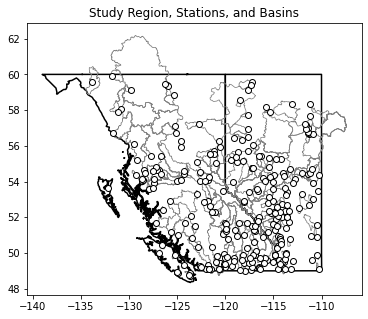

In [9]:
#visualize study region

saveIt = 0

fig, ax = plt.subplots(figsize = (6,5))

plot_prov_ax(prov, ax)
for basin in stationBasins:
  if basin is not None:
    x,y = basin.exterior.xy
    ax.plot(x, y, color = 'gray', linewidth = 0.75)
ax.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', zorder = 3)
ax.set_title('Study Region, Stations, and Basins')

if saveIt:
  plt.savefig('study_region.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [10]:
#reduce spatial extent to only bound the stations of interest (reduce memory requirements)

bounding_box = 1 #1/0: yes/no if you want to reduce the spatial extent
border = 1 #number of pixels to border the outermost stations

if bounding_box:

### SOUTH

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds_south])
  maxLon = np.max(stationLon[stationInds_south])
  minLat = np.min(stationLat[stationInds_south])
  maxLat = np.max(stationLat[stationInds_south])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA_south = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA_south = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA_south = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA_south = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA_south + border > len(eraLat) - 1:
    indMinLatERA_south = len(eraLat) - 1
  else:
    indMinLatERA_south = indMinLatERA_south + border

  if indMaxLatERA_south - border < 1:
    indMaxLatERA_south = 0
  else:
    indMaxLatERA_south = indMaxLatERA_south - border + 1

  if indMaxLonERA_south + border > len(eraLon) - 1:
    indMaxLonERA_south = len(eraLon) - 1
  else:
    indMaxLonERA_south = indMaxLonERA_south + border

  if indMinLonERA_south - border < 1:
    indMinLonERA_south = 0
  else:
    indMinLonERA_south = indMinLonERA_south - border

  #trim temp/precip data to only those values within bounding box
  Tmax_south = Tmax[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  Tmin_south = Tmin[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  P_south = P[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  E_south = E[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
  PE_south = PE[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA_south = [eraLon[indMinLonERA_south] - d_eraLon/2,eraLon[indMaxLonERA_south] + d_eraLon/2,eraLat[indMinLatERA_south] - d_eraLat/2,eraLat[indMaxLatERA_south] + d_eraLat/2]
  eraLon_south = eraLon[indMinLonERA_south:indMaxLonERA_south+1]
  eraLat_south = eraLat[indMaxLatERA_south:indMinLatERA_south+1]

### NORTH

  #find max/min lat/lon of stations in set
  minLon = np.min(stationLon[stationInds_north])
  maxLon = np.max(stationLon[stationInds_north])
  minLat = np.min(stationLat[stationInds_north])
  maxLat = np.max(stationLat[stationInds_north])

  #find corresponding indices in ERA lat/lon 
  indMinLonERA_north = np.argmin(np.abs(eraLon - minLon))
  indMaxLonERA_north = np.argmin(np.abs(eraLon - maxLon))
  indMinLatERA_north = np.argmin(np.abs(eraLat - minLat))
  indMaxLatERA_north = np.argmin(np.abs(eraLat - maxLat))

  #pad the bounding box by the value specified by border, if there is room in ERA dataset
  if indMinLatERA_north + border > len(eraLat) - 1:
    indMinLatERA_north = len(eraLat) - 1
  else:
    indMinLatERA_north = indMinLatERA_north + border

  if indMaxLatERA_north - border < 1:
    indMaxLatERA_north = 0
  else:
    indMaxLatERA_north = indMaxLatERA_north - border + 1

  if indMaxLonERA_north + border > len(eraLon) - 1:
    indMaxLonERA_north = len(eraLon) - 1
  else:
    indMaxLonERA_north = indMaxLonERA_north + border

  if indMinLonERA_north - border < 1:
    indMinLonERA_north = 0
  else:
    indMinLonERA_north = indMinLonERA_north - border

  #trim temp/precip data to only those values within bounding box
  Tmax_north = Tmax[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  Tmin_north = Tmin[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  P_north = P[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  E_north = E[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
  PE_north = PE[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]

  #spatial resolution in lat/lon dimensions
  d_eraLon = eraLon[1] - eraLon[0]
  d_eraLat = eraLat[0] - eraLat[1]

  #for visualization using plt.imshow -- define extent
  extentERA_north = [eraLon[indMinLonERA_north] - d_eraLon/2,eraLon[indMaxLonERA_north] + d_eraLon/2,eraLat[indMinLatERA_north] - d_eraLat/2,eraLat[indMaxLatERA_north] + d_eraLat/2]
  eraLon_north = eraLon[indMinLonERA_north:indMaxLonERA_north+1]
  eraLat_north = eraLat[indMaxLatERA_north:indMinLatERA_north+1]

In [11]:
#years/indices of testing/training
trainStartYear = 1979
trainFinYear = 2000
valStartYear = 2001
valFinYear = 2010
testStartYear = 2011
testFinYear = 2015
testFinYear = 2020

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
valInds = np.squeeze(np.argwhere((flowYears>=valStartYear) & (flowYears<=valFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))
Ntrain = len(trainInds)
Nval = len(valInds)
Ntest = len(testInds)

In [12]:
#NORTH: standardize data relative to training time period

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train_north = np.mean([Tmax_north[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train_north = np.std([Tmax_north[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm_north = (Tmax_north - Tmaxmean_train_north)/Tmaxstd_train_north
Tmaxnorm_north = np.single(Tmaxnorm_north)

Tminmean_train_north = np.mean([Tmin_north[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train_north = np.std([Tmin_north[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm_north = (Tmin_north - Tminmean_train_north)/Tminstd_train_north
Tminnorm_north = np.single(Tminnorm_north)

Pmean_train_north = np.mean([P_north[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train_north = np.std([P_north[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm_north = (P_north - Pmean_train_north)/Pstd_train_north
Pnorm_north = np.single(Pnorm_north)

Emean_train_north = np.mean([E_north[trainInds[ii]] for ii in range(len(trainInds))])
Estd_train_north = np.std([E_north[trainInds[ii]] for ii in range(len(trainInds))])
Enorm_north = (E_north - Emean_train_north)/Estd_train_north
Enorm_north = np.single(Enorm_north)

PEmean_train_north = np.mean([PE_north[trainInds[ii]] for ii in range(len(trainInds))])
PEstd_train_north = np.std([PE_north[trainInds[ii]] for ii in range(len(trainInds))])
PEnorm_north = (PE_north - PEmean_train_north)/PEstd_train_north
PEnorm_north = np.single(PEnorm_north)

#normalize flow wrt to training period for each station
F_north = F[:,stationInds_north]
Fnorm_north = np.empty_like(F_north)
Fmean_north = np.zeros(len(stationInds_north))
Fstd_north = np.zeros(len(stationInds_north))
for station in range(np.shape(Fnorm_north)[1]):
  Fmean_north[station] = np.mean(F_north[trainInds,station])
  Fstd_north[station] = np.std(F_north[trainInds,station])
  Fnorm_north[:,station] = (F_north[:,station] - Fmean_north[station]) / Fstd_north[station]

In [13]:
#SOUTH: standardize data relative to training time period

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxmean_train_south = np.mean([Tmax_south[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train_south = np.std([Tmax_south[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm_south = (Tmax_south - Tmaxmean_train_south)/Tmaxstd_train_south
Tmaxnorm_south = np.single(Tmaxnorm_south)

Tminmean_train_south = np.mean([Tmin_south[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train_south = np.std([Tmin_south[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm_south = (Tmin_south - Tminmean_train_south)/Tminstd_train_south
Tminnorm_south = np.single(Tminnorm_south)

Pmean_train_south = np.mean([P_south[trainInds[ii]] for ii in range(len(trainInds))])
Pstd_train_south = np.std([P_south[trainInds[ii]] for ii in range(len(trainInds))])
Pnorm_south = (P_south - Pmean_train_south)/Pstd_train_south
Pnorm_south = np.single(Pnorm_south)

Emean_train_south = np.mean([E_south[trainInds[ii]] for ii in range(len(trainInds))])
Estd_train_south = np.std([E_south[trainInds[ii]] for ii in range(len(trainInds))])
Enorm_south = (E_south - Emean_train_south)/Estd_train_south
Enorm_south = np.single(Enorm_south)

PEmean_train_south = np.mean([PE_south[trainInds[ii]] for ii in range(len(trainInds))])
PEstd_train_south = np.std([PE_south[trainInds[ii]] for ii in range(len(trainInds))])
PEnorm_south = (PE_south - PEmean_train_south)/PEstd_train_south
PEnorm_south = np.single(PEnorm_south)

#normalize flow wrt to training period for each station
F_south = F[:,stationInds_south]
Fnorm_south = np.empty_like(F_south)
Fmean_south = np.zeros(len(stationInds_south))
Fstd_south = np.zeros(len(stationInds_south))
for station in range(np.shape(Fnorm_south)[1]):
  Fmean_south[station] = np.mean(F_south[trainInds,station])
  Fstd_south[station] = np.std(F_south[trainInds,station])
  Fnorm_south[:,station] = (F_south[:,station] - Fmean_south[station]) / Fstd_south[station]

Fmean = np.zeros(len(stationInds))
Fmean[stationInds_north] = Fmean_north
Fmean[stationInds_south] = Fmean_south

Fstd = np.zeros(len(stationInds))
Fstd[stationInds_north] = Fstd_north
Fstd[stationInds_south] = Fstd_south

# Cluster seasonal flow: 1979 - 2015

In [14]:
#SOUTH : create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds_south), len_input))

flowseason_south = flowDict['all_flowseason_NF'][stationInds_south,:]
stationLat_norm = (stationLat[stationInds_south] - np.mean(stationLat[stationInds_south])) / np.std(stationLat[stationInds_south])
stationLon_norm = (stationLon[stationInds_south] - np.mean(stationLon[stationInds_south])) / np.std(stationLon[stationInds_south])

for station in range(len(stationInds_south)):
  cluster_input[station,:365] = (flowseason_south[station,:] - np.mean(flowseason_south[station,:])) / np.std(flowseason_south[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal_south = 6
seasonal_clustering_south = AgglomerativeClustering(n_clusters = n_clusters_seasonal_south).fit(cluster_input)

#calculate average of each cluster
cluster_patterns_south = np.empty((n_clusters_seasonal_south, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal_south):
  cluster_inds = np.argwhere(seasonal_clustering_south.labels_ == cluster)
  cluster_patterns_south[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [15]:
#NORTH : create cluster input: half seasonal, quarter lat, quarter lon -- we want stations which have similar streamflow characteristics AND are nearby in space

frac_space = 0.5 #fraction of input vector to be the lat/lon
len_input = int(365/frac_space)
cluster_input = np.empty((len(stationInds_north), len_input))

flowseason_north = flowDict['all_flowseason_NF'][stationInds_north,:]
stationLat_norm = (stationLat[stationInds_north] - np.mean(stationLat[stationInds_north])) / np.std(stationLat[stationInds_north])
stationLon_norm = (stationLon[stationInds_north] - np.mean(stationLon[stationInds_north])) / np.std(stationLon[stationInds_north])

for station in range(len(stationInds_north)):
  cluster_input[station,:365] = (flowseason_north[station,:] - np.mean(flowseason_north[station,:])) / np.std(flowseason_north[station,:]) #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal_north = 2
seasonal_clustering_north = AgglomerativeClustering(n_clusters = n_clusters_seasonal_north).fit(cluster_input)

#calculate average of each cluster
cluster_patterns_north = np.empty((n_clusters_seasonal_north, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal_north):
  cluster_inds = np.argwhere(seasonal_clustering_north.labels_ == cluster)
  cluster_patterns_north[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [16]:
n_clusters_seasonal = n_clusters_seasonal_north + n_clusters_seasonal_south

In [17]:
flowseason = np.zeros((len(stationInds), 365))
flowseason[stationInds_south] = flowseason_south
flowseason[stationInds_north] = flowseason_north

flowseason_norm = np.zeros((len(stationInds), 365))

for station in range(len(flowseason)):
  flowseason_norm[station,:] = ( flowseason[station,:] - np.mean(flowseason[station,:]) ) / np.std(flowseason[station,:])

stationLat_norm = (stationLat[stationInds] - np.mean(stationLat[stationInds])) / np.std(stationLat[stationInds])
stationLon_norm = (stationLon[stationInds] - np.mean(stationLon[stationInds])) / np.std(stationLon[stationInds])

cluster_input = np.empty((len(stationInds), len_input))
for station in range(len(stationInds)):
  cluster_input[station,:365] = flowseason_norm[station,:] #first half is normalized seasonal streamflow
  lat_inds = np.arange(365,365 + int((len_input - 365)/2)) #third quarter is normalized latitude
  lon_inds = np.arange(365 + int((len_input - 365)/2), len_input) #fourth quarter is normalized longitude
  cluster_input[station,lat_inds] = stationLat_norm[station] * np.ones_like(lat_inds)
  cluster_input[station,lon_inds] = stationLon_norm[station] * np.ones_like(lon_inds)

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_seasonal = 6
seasonal_clustering = AgglomerativeClustering(n_clusters = n_clusters_seasonal).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters_seasonal, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_seasonal):
  cluster_inds = np.argwhere(seasonal_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [18]:
labels = seasonal_clustering.labels_

In [19]:
# labels = np.zeros(len(stationInds))
# labels[stationInds_south] = seasonal_clustering_south.labels_
# labels[stationInds_north] = seasonal_clustering_north.labels_ + n_clusters_seasonal_south

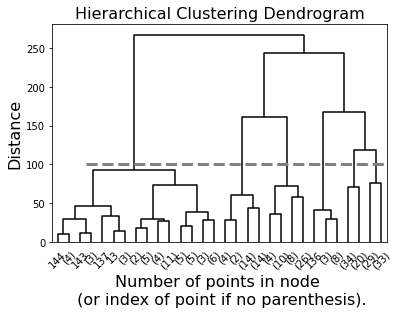

In [20]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)


# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [21]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#assign geographically relevant names for each cluster
cluster_names = [
                 'Central',       #cluster 0
                 'Southern',      #cluster 1
                 'Eastern',       #etc
                 'Coastal',
                 'North-Western',
                 'North-Eastern',
                 'Far North-West',
                 'Far North-East'
]

cluster_names = [
                 'North-Western',       #cluster 0
                 'Southern',      #cluster 1
                 'North-Eastern',       #etc
                 'Coastal',
                 'Eastern',
                 'Central'
]

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256

first_days_of_month = np.array([1,32,61,92,122,153,183,214,245,275,306,336]) #day-of-year of the first day of each month

months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.5, 1.0, 'Clusters in Space')

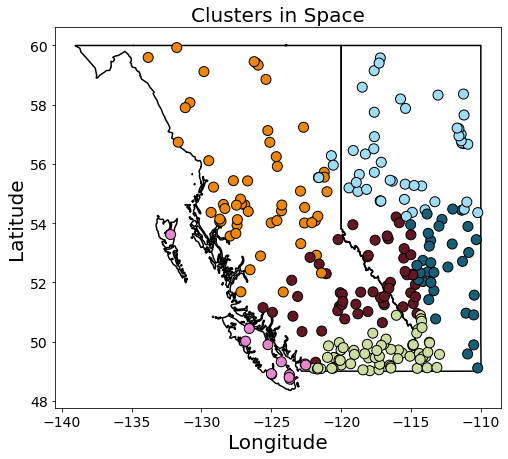

In [22]:
#visualize clustering results (spatial patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig, ax = plt.subplots(figsize = (8,7))

#left side: spatial map of stations, coloured by cluster to which they belong
plot_prov_ax(prov=prov, ax = ax)
ax.scatter(stationLon[stationInds], stationLat[stationInds], c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
ax.tick_params(labelsize = fs-6)
ax.set_xlabel('Longitude', fontsize = fs)
ax.set_ylabel('Latitude', fontsize = fs)
ax.set_title('Clusters in Space', fontsize = fs)


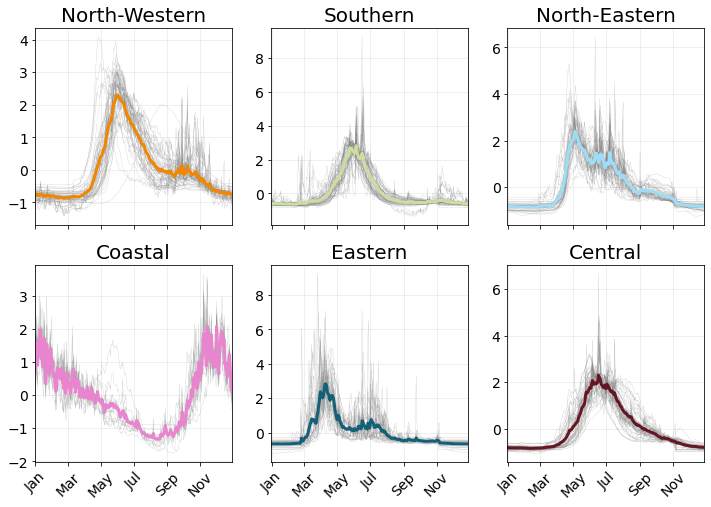

In [23]:
#temporal patterns

nrows = 2
ncols = int(np.ceil(n_clusters_seasonal/2))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*4, nrows*4))

for cluster, ax in enumerate(axes.flatten()):

  ax.set_xticks(first_days_of_month[::2])
  ax.set_xlim((0,364))
  ax.set_xticklabels(months_str[::2], rotation = 45)#, ha = 'right')
  if cluster<3:
    ax.set_xticklabels([])
  cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
  ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.tick_params(labelsize = fs - 6)
  ax.set_title(cluster_names[cluster], fontsize = fs)
  ax.grid(True, alpha = 0.25)

plt.show()

# Predict Streamflow 1979 - 2020

In [ ]:
np.shape(Tmaxnorm_south)

(15341, 12, 32)

In [ ]:
testInds = np.arange(np.max(valInds), 15339)
Ntest = len(testInds)
print(Ntest)

3652


In [ ]:
#SOUTH: construct train and test predictor/target tensors

# #target data
# y_train_south = np.squeeze([Fnorm_south[365:trainInds[-1]+1,ii] for ii in range(np.shape(F_south)[1])]).T #drop first 365 days since those are used to predict first flow day
# y_val_south = np.squeeze([Fnorm_south[valInds,ii] for ii in range(np.shape(F_south)[1])]).T
# y_test_south = np.squeeze([Fnorm_south[testInds,ii] for ii in range(np.shape(F_south)[1])]).T

# y_train_south = y_train_south.astype(dtype = np.float16)
# y_val_south = y_val_south.astype(dtype = np.float16)
# y_test_south = y_test_south.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_train_south = np.empty((Ntrain-365, 365, ) + np.shape(Tmaxnorm_south)[1:] + (nchannels,),dtype=np.float16)
x_val_south = np.empty((Nval, 365,) + np.shape(Tmaxnorm_south)[1:] + (nchannels,), dtype = np.float16)
x_test_south = np.empty((Ntest, 365,) + np.shape(Tmaxnorm_south)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm_south[:-1]) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm_south[:-1]
x_intermediate[:,:,:,1] = Tminnorm_south[:-1]
x_intermediate[:,:,:,2] = Pnorm_south

#training
for ii in range(Ntrain-365):
  x_train_south[ii] = x_intermediate[ii:ii+365]

#validation
for ii in range(Nval):
  x_val_south[ii] = x_intermediate[ii + Ntrain - 365 : ii + Ntrain]

#testing
for ii in range(Ntest):
  x_test_south[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

#convert predict/target arrays to tensors
x_test_south = tf.convert_to_tensor(x_test_south)
x_val_south = tf.convert_to_tensor(x_val_south)
x_train_south = tf.convert_to_tensor(x_train_south)
# y_test_south = tf.convert_to_tensor(y_test_south)
# y_val_south = tf.convert_to_tensor(y_val_south)
# y_train_south = tf.convert_to_tensor(y_train_south)

NameError: ignored

In [ ]:
#SOUTH: compute output from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]

#initialize
y_train_predict_fine_runs = np.empty((len(runs), Ntrain-365, len(stationInds))) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((len(runs), Nval, len(stationInds))) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run
y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

y_train_predict_fine_runs_south = np.empty((len(runs), Ntrain-365, len(stationInds_south))) #fine-tuned model predictions of each run
y_val_predict_fine_runs_south = np.empty((len(runs), Nval, len(stationInds_south))) #fine-tuned model predictions of each run
y_test_predict_fine_runs_south = np.empty((len(runs), Ntest, len(stationInds_south))) #fine-tuned model predictions of each run
y_all_predict_fine_runs_south = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds_south)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  # filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  # filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  # filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

  # y_train_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  # y_val_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  # y_test_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  # y_train_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_train_fine, header = None))
  # y_val_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_val_fine, header = None))
  # y_test_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_test_fine, header = None))

  # y_train_predict_fine_runs[ii,:,stationInds_south] = y_train_predict_fine_south.T
  # y_val_predict_fine_runs[ii,:,stationInds_south] = y_val_predict_fine_south.T
  # y_test_predict_fine_runs[ii,:,stationInds_south] = y_test_predict_fine_south.T

  # y_train_predict_fine_runs[ii,:,stationInds_north] = y_train_predict_fine_north.T
  # y_val_predict_fine_runs[ii,:,stationInds_north] = y_val_predict_fine_north.T
  # y_test_predict_fine_runs[ii,:,stationInds_north] = y_test_predict_fine_north.T

  # HERE: Predict flow, rather than load flow
  for cluster in range(n_clusters_seasonal_south):
    
    print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_south))

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering_south.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster

    # load model
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

    y_train_intermediate = model_fine.predict(x_train_south, verbose = 0)
    y_val_intermediate = model_fine.predict(x_val_south, verbose = 0)
    y_test_intermediate = model_fine.predict(x_test_south, verbose = 1)

    for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
        y_train_predict_fine_runs_south[run,:,station] = y_train_intermediate[:,zz]
        y_val_predict_fine_runs_south[run,:,station] = y_val_intermediate[:,zz]
        y_test_predict_fine_runs_south[run,:,station] = y_test_intermediate[:,zz]

y_train_predict_fine_runs[:,:,stationInds_south] = y_train_predict_fine_runs_south
y_val_predict_fine_runs[:,:,stationInds_south] = y_val_predict_fine_runs_south
y_test_predict_fine_runs[:,:,stationInds_south] = y_test_predict_fine_runs_south

Run 0
Fine model, cluster 1 / 6
115/115 [==============================] - 6s 48ms/step
Fine model, cluster 2 / 6
115/115 [==============================] - 6s 48ms/step
Fine model, cluster 3 / 6
115/115 [==============================] - 6s 48ms/step
Fine model, cluster 4 / 6
115/115 [==============================] - 5s 48ms/step
Fine model, cluster 5 / 6
115/115 [==============================] - 6s 48ms/step
Fine model, cluster 6 / 6
115/115 [==============================] - 5s 47ms/step
Run 1
Fine model, cluster 1 / 6
115/115 [==============================] - 5s 47ms/step
Fine model, cluster 2 / 6
115/115 [==============================] - 5s 47ms/step
Fine model, cluster 3 / 6
115/115 [==============================] - 5s 47ms/step
Fine model, cluster 4 / 6
115/115 [==============================] - 5s 47ms/step
Fine model, cluster 5 / 6
115/115 [==============================] - 5s 47ms/step
Fine model, cluster 6 / 6
115/115 [==============================] - 5s 47ms/step
Run 

In [ ]:
del x_train_south, x_val_south, x_test_south

In [ ]:
#NORTH: construct train and test predictor/target tensors

# #target data
# y_train_north = np.squeeze([Fnorm_north[365:trainInds[-1]+1,ii] for ii in range(np.shape(F_north)[1])]).T #drop first 365 days since those are used to predict first flow day
# y_val_north = np.squeeze([Fnorm_north[valInds,ii] for ii in range(np.shape(F_north)[1])]).T
# y_test_north = np.squeeze([Fnorm_north[testInds,ii] for ii in range(np.shape(F_north)[1])]).T

# y_train_north = y_train_north.astype(dtype = np.float16)
# y_val_north = y_val_north.astype(dtype = np.float16)
# y_test_north = y_test_north.astype(dtype = np.float16)

#predictor data
nchannels = 3 
x_train_north = np.empty((Ntrain-365, 365, ) + np.shape(Tmaxnorm_north)[1:] + (nchannels,),dtype=np.float16)
x_val_north = np.empty((Nval, 365,) + np.shape(Tmaxnorm_north)[1:] + (nchannels,), dtype = np.float16)
x_test_north = np.empty((Ntest, 365,) + np.shape(Tmaxnorm_north)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Tmaxnorm_north[:-1]) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm_north[:-1]
x_intermediate[:,:,:,1] = Tminnorm_north[:-1]
x_intermediate[:,:,:,2] = Pnorm_north

#training
for ii in range(Ntrain-365):
  x_train_north[ii] = x_intermediate[ii:ii+365]

#validation
for ii in range(Nval):
  x_val_north[ii] = x_intermediate[ii + Ntrain - 365 : ii + Ntrain]

#testing
for ii in range(Ntest):
  x_test_north[ii] = x_intermediate[ii + Ntrain + Nval - 365 : ii + Ntrain + Nval]

#convert predict/target arrays to tensors
x_test_north = tf.convert_to_tensor(x_test_north)
x_val_north = tf.convert_to_tensor(x_val_north)
x_train_north = tf.convert_to_tensor(x_train_north)
# y_test_north = tf.convert_to_tensor(y_test_north)
# y_val_north = tf.convert_to_tensor(y_val_north)
# y_train_north = tf.convert_to_tensor(y_train_north)

In [ ]:
#NORTH: compute output from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]

#initialize
y_train_predict_fine_runs_north = np.empty((len(runs), Ntrain-365, len(stationInds_north))) #fine-tuned model predictions of each run
y_val_predict_fine_runs_north = np.empty((len(runs), Nval, len(stationInds_north))) #fine-tuned model predictions of each run
y_test_predict_fine_runs_north = np.empty((len(runs), Ntest, len(stationInds_north))) #fine-tuned model predictions of each run
y_all_predict_fine_runs_north = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds_north)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  # filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  # filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  # filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

  # y_train_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  # y_val_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  # y_test_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  # y_train_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_train_fine, header = None))
  # y_val_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_val_fine, header = None))
  # y_test_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_test_fine, header = None))

  # y_train_predict_fine_runs[ii,:,stationInds_south] = y_train_predict_fine_south.T
  # y_val_predict_fine_runs[ii,:,stationInds_south] = y_val_predict_fine_south.T
  # y_test_predict_fine_runs[ii,:,stationInds_south] = y_test_predict_fine_south.T

  # y_train_predict_fine_runs[ii,:,stationInds_north] = y_train_predict_fine_north.T
  # y_val_predict_fine_runs[ii,:,stationInds_north] = y_val_predict_fine_north.T
  # y_test_predict_fine_runs[ii,:,stationInds_north] = y_test_predict_fine_north.T

  # HERE: Predict flow, rather than load flow
  for cluster in range(n_clusters_seasonal_north):
    
    print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering_north.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster

    # load model
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine = tf.keras.models.load_model(dir_models_north + '/' + model_name)

    y_train_intermediate = model_fine.predict(x_train_north, verbose = 0)
    y_val_intermediate = model_fine.predict(x_val_north, verbose = 0)
    y_test_intermediate = model_fine.predict(x_test_north, verbose = 1)

    for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
        y_train_predict_fine_runs_north[run,:,station] = y_train_intermediate[:,zz]
        y_val_predict_fine_runs_north[run,:,station] = y_val_intermediate[:,zz]
        y_test_predict_fine_runs_north[run,:,station] = y_test_intermediate[:,zz]

y_train_predict_fine_runs[:,:,stationInds_north] = y_train_predict_fine_runs_north
y_val_predict_fine_runs[:,:,stationInds_north] = y_val_predict_fine_runs_north
y_test_predict_fine_runs[:,:,stationInds_north] = y_test_predict_fine_runs_north

Run 0
Fine model, cluster 1 / 6
115/115 [==============================] - 4s 37ms/step
Fine model, cluster 2 / 6
115/115 [==============================] - 4s 38ms/step
Run 1
Fine model, cluster 1 / 6
115/115 [==============================] - 4s 37ms/step
Fine model, cluster 2 / 6
115/115 [==============================] - 4s 38ms/step
Run 2
Fine model, cluster 1 / 6
115/115 [==============================] - 4s 37ms/step
Fine model, cluster 2 / 6
115/115 [==============================] - 4s 37ms/step
Run 3
Fine model, cluster 1 / 6
115/115 [==============================] - 4s 37ms/step
Fine model, cluster 2 / 6
115/115 [==============================] - 4s 37ms/step
Run 4
Fine model, cluster 1 / 6
115/115 [==============================] - 4s 38ms/step
Fine model, cluster 2 / 6
115/115 [==============================] - 4s 37ms/step
Run 5
Fine model, cluster 1 / 6
115/115 [==============================] - 4s 38ms/step
Fine model, cluster 2 / 6
115/115 [===========================

In [ ]:
del x_train_north, x_val_north, x_test_north

In [ ]:
#save outputs through 2020
for ii, run in enumerate(runs):

  file_train = 'y_train_fine_predict_' + str(ii) + '.csv'
  file_val = 'y_val_fine_predict_' + str(ii) + '.csv'
  file_test = 'y_test_fine_predict_' + str(ii) + '.csv'

  np.savetxt(dir_output + '/2020/' + file_train, y_train_predict_fine_runs[ii,:,:], delimiter = ',')
  np.savetxt(dir_output + '/2020/' + file_val, y_val_predict_fine_runs[ii,:,:], delimiter = ',')
  np.savetxt(dir_output + '/2020/' + file_test, y_test_predict_fine_runs[ii,:,:], delimiter = ',')

# Load model streamflow: 1979 - 2015

In [24]:
stationNames = flowDict['stationName'][stationInds]

In [25]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#initialize
y_train_predict_fine_runs = np.empty((len(runs), Ntrain-365, len(stationInds))) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((len(runs), Nval, len(stationInds))) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run
y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

  y_train_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  y_val_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  y_test_predict_fine_south = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))

  y_train_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_train_fine, header = None))
  y_val_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_val_fine, header = None))
  y_test_predict_fine_north = np.asarray(pd.read_csv(dir_output_north + '/' + filename_test_fine, header = None))

  y_train_predict_fine_runs[ii,:,stationInds_south] = y_train_predict_fine_south.T
  y_val_predict_fine_runs[ii,:,stationInds_south] = y_val_predict_fine_south.T
  y_test_predict_fine_runs[ii,:,stationInds_south] = y_test_predict_fine_south.T

  y_train_predict_fine_runs[ii,:,stationInds_north] = y_train_predict_fine_north.T
  y_val_predict_fine_runs[ii,:,stationInds_north] = y_val_predict_fine_north.T
  y_test_predict_fine_runs[ii,:,stationInds_north] = y_test_predict_fine_north.T

  # # HERE: Predict flow, rather than load flow
  # for cluster in range(n_clusters_seasonal):
    
  #   print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal))

  #   stations_fine = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster)) #stations in this cluster
  #   N_stations = len(stations_fine) #number of stations in this cluster

  #   # load model
  #   model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
  #   model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

  #   y_train_intermediate = model_fine.predict(x_train, verbose = 0)
  #   y_val_intermediate = model_fine.predict(x_val, verbose = 0)
  #   y_test_intermediate = model_fine.predict(x_test, verbose = 1)

  #   for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
  #       y_train_predict_fine_runs[run,:,station] = y_train_intermediate[:,zz]
  #       y_val_predict_fine_runs[run,:,station] = y_val_intermediate[:,zz]
  #       y_test_predict_fine_runs[run,:,station] = y_test_intermediate[:,zz]

  

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [26]:
y_train_ensemble_predict = np.mean(y_train_predict_fine_runs, axis = 0)
y_val_ensemble_predict = np.mean(y_val_predict_fine_runs, axis = 0)
y_test_ensemble_predict = np.mean(y_test_predict_fine_runs, axis = 0)
y_modern_predict = np.vstack([y_train_ensemble_predict, y_val_ensemble_predict, y_test_ensemble_predict])

# Prep data (south): 1950 - 1978 Hindcast

In [27]:
# #first, delete high-memory old data
# del x_train, x_val, x_test, y_train, y_val, y_test

In [28]:
#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)

#unpack data
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])
E = np.asarray(evapDict['E'])
PE = P+E

eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_hind = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

del tempDict, precDict, evapDict

#restrict to region of interest determined above
Tmax = Tmax[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
Tmin = Tmin[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
P = P[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
E = E[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]
PE = PE[:, indMaxLatERA_south:indMinLatERA_south+1, indMinLonERA_south:indMaxLonERA_south+1]

#standardize data relative to training time period

#years/indices of hindcast
hindStartYear = 1950
hindFinYear = 1978

hindInds = np.arange(len(eraDays)-1)
Nhind = len(hindInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxnorm = (Tmax - Tmaxmean_train_south)/Tmaxstd_train_south
Tmaxnorm = np.single(Tmaxnorm)

Tminnorm = (Tmin - Tminmean_train_south)/Tminstd_train_south
Tminnorm = np.single(Tminnorm)

Pnorm = (P - Pmean_train_south)/Pstd_train_south
Pnorm = np.single(Pnorm)

Enorm = (E - Emean_train_south)/Estd_train_south
Enorm = np.single(Enorm)

PEnorm = (PE - PEmean_train_south)/PEstd_train_south
PEnorm = np.single(PEnorm)

Tminnorm = Tminnorm[:-1]
Tmaxnorm = Tmaxnorm[:-1]

#construct train and test predictor tensors

#predictor data
nchannels = 3 
x_hind = np.empty((Nhind-365,365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Pnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#hindcast
for ii in range(Nhind-365):
  x_hind[ii] = x_intermediate[ii:ii+365]

#convert predict/target arrays to tensors
x_hind = tf.convert_to_tensor(x_hind)

# Predict streamflow (south): 1950 - 1978

In [ ]:
#predict and save streamflow hindcast data

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
runs = [0, 1, 2, 3, 4]

#initialize
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds_south))) #fine-tuned model predictions of each run
y_hind_predict_fine = np.empty((Nhind-365, len(stationInds_south))) #fine-tuned model predictions of each run

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  for cluster in range(n_clusters_seasonal_south):
    
    print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_south))

    stations_fine = np.squeeze(np.argwhere(seasonal_clustering_south.labels_ == cluster)) #stations in this cluster
    N_stations = len(stations_fine) #number of stations in this cluster

    #load model
    model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
    model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

    y_hind_intermediate = model_fine.predict(x_hind, verbose = 0)

    for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
        # y_hind_predict_fine_runs[run,:,station] = y_hind_intermediate[:,zz]
        y_hind_predict_fine[:,station] = y_hind_intermediate[:,zz]

  # #save fine-tuned model predictions
  # file_hind = 'y_hind_fine_predict_' + str(ii) + '.csv'
  # np.savetxt(dir_output + '/' + file_hind, y_hind_predict_fine, delimiter = ',')


# Prep data (north): 1950 - 1978 Hindcast

In [29]:
#first, delete high-memory old data
del x_intermediate, x_hind

In [30]:
#load daily temperature data
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)

#load daily evaporation data
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)

#unpack data
Tmax = np.asarray(tempDict['Tmax'])
Tmin = np.asarray(tempDict['Tmin'])
P = np.asarray(precDict['P'])
E = np.asarray(evapDict['E'])
PE = P+E

eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_hind = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

del tempDict, precDict, evapDict

#restrict to region of interest determined above
Tmax = Tmax[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
Tmin = Tmin[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
P = P[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
E = E[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]
PE = PE[:, indMaxLatERA_north:indMinLatERA_north+1, indMinLonERA_north:indMaxLonERA_north+1]

#standardize data relative to training time period

#years/indices of hindcast
hindStartYear = 1950
hindFinYear = 1978

hindInds = np.arange(len(eraDays)-1)
Nhind = len(hindInds)

#standardize weather variables (normalize wrt training period), then reformat for memory
Tmaxnorm = (Tmax - Tmaxmean_train_north)/Tmaxstd_train_north
Tmaxnorm = np.single(Tmaxnorm)

Tminnorm = (Tmin - Tminmean_train_north)/Tminstd_train_north
Tminnorm = np.single(Tminnorm)

Pnorm = (P - Pmean_train_north)/Pstd_train_north
Pnorm = np.single(Pnorm)

Enorm = (E - Emean_train_north)/Estd_train_north
Enorm = np.single(Enorm)

PEnorm = (PE - PEmean_train_north)/PEstd_train_north
PEnorm = np.single(PEnorm)

Tminnorm = Tminnorm[:-1]
Tmaxnorm = Tmaxnorm[:-1]

#construct train and test predictor tensors

#predictor data
nchannels = 3 
x_hind = np.empty((Nhind-365,365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

#first, make (n_time x n_lon x n_lat x n_channels) tensor -- will be used to form weather videos 
x_intermediate = np.empty(np.shape(Pnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm

#hindcast
for ii in range(Nhind-365):
  x_hind[ii] = x_intermediate[ii:ii+365]

#convert predict/target arrays to tensors
x_hind = tf.convert_to_tensor(x_hind)

# Predict streamflow (north): 1950 - 1978

In [ ]:
#predict and save streamflow hindcast data

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]

#initialize
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds_north))) #fine-tuned model predictions of each run
y_hind_predict_fine = np.empty((Nhind-365, len(stationInds_north))) #fine-tuned model predictions of each run

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  if ii > 4:

    print('Run ' + str(run))

    for cluster in range(n_clusters_seasonal_north):
      
      print('Fine model, cluster ' + str(cluster+1) + ' / ' + str(n_clusters_seasonal_north))

      stations_fine = np.squeeze(np.argwhere(seasonal_clustering_north.labels_ == cluster)) #stations in this cluster
      N_stations = len(stations_fine) #number of stations in this cluster

      #load model
      model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster) + '.h5'
      model_fine = tf.keras.models.load_model(dir_models_north + '/' + model_name)

      y_hind_intermediate = model_fine.predict(x_hind, verbose = 0)

      for zz,station in enumerate(stations_fine): #reorganize heatmaps into array that matches the bulk heatmap order (e.g. heat_mean_fine[:,0] and heat_mean_bulk[:,0] are the same station)
          # y_hind_predict_fine_runs[run,:,station] = y_hind_intermediate[:,zz]
          y_hind_predict_fine[:,station] = y_hind_intermediate[:,zz]

    #save fine-tuned model predictions
    file_hind = 'y_hind_fine_predict_' + str(ii) + '.csv'
    np.savetxt(dir_output_north + '/' + file_hind, y_hind_predict_fine, delimiter = ',')


Run 5
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 6
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 7
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 8
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2
Run 9
Fine model, cluster 1 / 2
Fine model, cluster 2 / 2


# Load model streamflow: 1950 - 2015

In [31]:
del x_intermediate, x_hind

In [32]:
Ntest = int(Ntest*2)

In [33]:
#compare results from different model runs

#model runs to explore
runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# runs = [0, 1, 2, 3, 4]

#initialize
y_train_predict_fine_runs = np.empty((len(runs), Ntrain-365, len(stationInds))) #fine-tuned model predictions of each run
y_val_predict_fine_runs = np.empty((len(runs), Nval, len(stationInds))) #fine-tuned model predictions of each run
y_test_predict_fine_runs = np.empty((len(runs), Ntest, len(stationInds))) #fine-tuned model predictions of each run
y_hind_predict_fine_runs = np.empty((len(runs), Nhind-365, len(stationInds))) #fine-tuned model predictions of each run

y_all_predict_fine_runs = np.empty((len(runs), Ntrain + Nval + Ntest - 365, len(stationInds)))

#loop through each run, open model outputs/heatmaps, calculate NSE and A
for ii, run in enumerate(runs):

  print('Run ' + str(run))

  filename_hind_fine = 'y_hind_fine_predict_' + str(run) + '.csv'
  filename_train_fine = 'y_train_fine_predict_' + str(run) + '.csv'
  filename_val_fine = 'y_val_fine_predict_' + str(run) + '.csv'
  filename_test_fine = 'y_test_fine_predict_' + str(run) + '.csv'

### SOUTH

  y_hind_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_hind_fine, header = None))
  # y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_train_fine, header = None))
  # y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_val_fine, header = None))
  # y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/' + filename_test_fine, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_train_fine, header = None))[:,stationInds_south]
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_val_fine, header = None))[:,stationInds_south]
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_test_fine, header = None))[:,stationInds_south]

  y_hind_predict_fine_runs[ii,:,stationInds_south] = y_hind_predict_fine.T
  y_train_predict_fine_runs[ii,:,stationInds_south] = y_train_predict_fine.T
  y_val_predict_fine_runs[ii,:,stationInds_south] = y_val_predict_fine.T
  y_test_predict_fine_runs[ii,:,stationInds_south] = y_test_predict_fine.T

### NORTH

  y_hind_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_hind_fine, header = None))
  # y_train_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_train_fine, header = None))
  # y_val_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_val_fine, header = None))
  # y_test_predict_fine = np.asarray(pd.read_csv(dir_output_north + '/' + filename_test_fine, header = None))
  y_train_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_train_fine, header = None))[:,stationInds_north]
  y_val_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_val_fine, header = None))[:,stationInds_north]
  y_test_predict_fine = np.asarray(pd.read_csv(dir_output + '/2020/' + filename_test_fine, header = None))[:,stationInds_north]

  y_hind_predict_fine_runs[ii,:,stationInds_north] = y_hind_predict_fine.T
  y_train_predict_fine_runs[ii,:,stationInds_north] = y_train_predict_fine.T
  y_val_predict_fine_runs[ii,:,stationInds_north] = y_val_predict_fine.T
  y_test_predict_fine_runs[ii,:,stationInds_north] = y_test_predict_fine.T

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


In [34]:
y_hind_predict = np.mean(y_hind_predict_fine_runs, axis = 0)
y_train_predict = np.mean(y_train_predict_fine_runs, axis = 0)
y_val_predict = np.mean(y_val_predict_fine_runs, axis = 0)
y_test_predict = np.mean(y_test_predict_fine_runs, axis = 0)
y_modern_predict = np.vstack([y_train_predict, y_val_predict, y_test_predict])

y_hind_std = np.std(y_hind_predict_fine_runs, axis = 0)
y_train_std = np.std(y_train_predict_fine_runs, axis = 0)
y_val_std = np.std(y_val_predict_fine_runs, axis = 0)
y_test_std = np.std(y_test_predict_fine_runs, axis = 0)
y_modern_std = np.vstack([y_train_std, y_val_std, y_test_std])

# Load observations: 1950 - 2015

In [35]:
flowpickle = ['BC_flowvars_1950_2015_missing_10_10_0.pickle', 'AB_flowvars_1950_2015_missing_10_10_0.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

flowpickle = ['BC_flowvars_1950_2020_missing_10_10_0.pickle', 'AB_flowvars_1950_2020_missing_10_10_0.pickle'] #filenames of .pickle files which contain AB/BC streamflow data

#open flow data; since flow data is provided at provincial level, loop through/open/concatenate data from desired provinces
flowDicts = []
for flowfile in flowpickle:
  pickle_in = open(dir_data + '/' + flowfile,'rb')
  flowDicts.append(pickle.load(pickle_in))

#store flow data as a dictionary
flowDict_long = {
    'stationID' : np.hstack((flowDicts[0]['stationID'],flowDicts[1]['stationID'])), #station ID numbers
    'stationName' : np.hstack((flowDicts[0]['stationName'],flowDicts[1]['stationName'])), #station names
    'stationLat' : np.hstack((flowDicts[0]['stationLat'],flowDicts[1]['stationLat'])), #latitude of each station, in degrees
    'stationLon' : np.hstack((flowDicts[0]['stationLon'],flowDicts[1]['stationLon'])), #longitude of each station, in degrees
    'stationDrainageArea' : np.hstack((flowDicts[0]['stationDrainageArea'],flowDicts[1]['stationDrainageArea'])), #drainage area of each station
    'all_flowseason' : np.vstack((flowDicts[0]['all_flowseason'],flowDicts[1]['all_flowseason'])), #seasonal flow of each station, as evaluated across all years
    'all_flowseason_NF' : np.vstack((flowDicts[0]['all_flowseason_NF'],flowDicts[1]['all_flowseason_NF'])), #seasonal flow of each station, but with missing data filled with minimum value
    'all_flow' : np.vstack((flowDicts[0]['all_flow'],flowDicts[1]['all_flow'])), #daily flow data for each station
    'all_flow_NF' : np.vstack((flowDicts[0]['all_flow_NF'], flowDicts[1]['all_flow_NF'])), #daily flow data for each station, with missing data filled by seasonal value of the missing day
    'windowDates' : flowDicts[0]['windowDates'], #dates within window ("window" refers to time period of interest; here: 1979 - 2015)
    'windowYears' : flowDicts[0]['windowYears'], #years of each day within window
    'windowMonths' : flowDicts[0]['windowMonths'], #months of each day within window
    'windowDays' : flowDicts[0]['windowDays'], #day of month of each day within window
}

#unpack data
stationLat_long = flowDict_long['stationLat']
stationLon_long = flowDict_long['stationLon']

flowDays_long = flowDict_long['windowDays']
flowMonths_long = flowDict_long['windowMonths']
flowYears_long = flowDict_long['windowYears']

date_str = [str(int(flowDays_long[kk])) + '-' +  str(int(flowMonths_long[kk])) + '-' + str(int(flowYears_long[kk])) for kk in range(len(flowYears_long))]
flowDate_long = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

F_long = np.squeeze(flowDict_long['all_flow']).T
stationNames_long = flowDict_long['stationName']


In [36]:
del flowDict

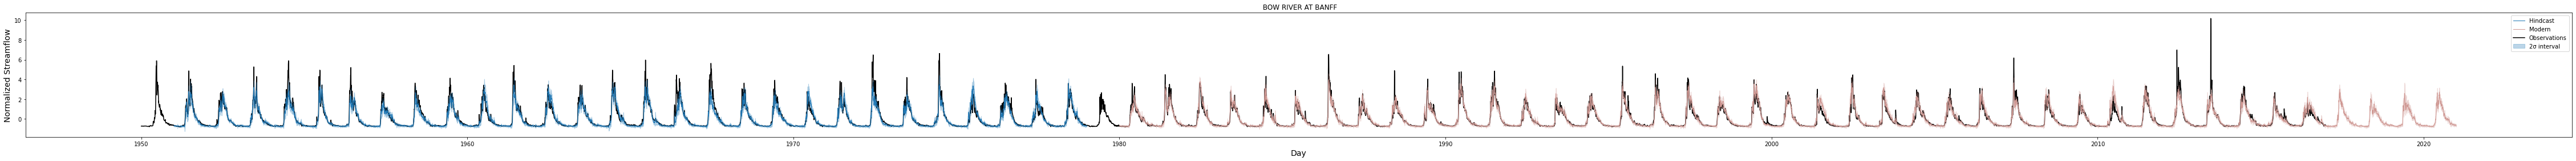

In [37]:
saveIt = 0

fs = 14

#ELK: 109
#BANFF: 141
#PEMBINA:
#CHEMAINUS: 31
#PEMBINA: 206
ind = 157
stationName = stationNames[ind]

ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
rgb = '#1f77b4' #colour for shading that I like (picked from coolors.co)
rgb_mod = '#CF9893'

fig, ax = plt.subplots(nrows =1, ncols = 1, figsize = (80,4))

fb_hind1 = y_hind_predict[:,ind] - 2*y_hind_std[:,ind]
fb_hind2 = y_hind_predict[:,ind] + 2*y_hind_std[:,ind]

fb_mod1 = y_modern_predict[:,ind] - 2*y_modern_std[:,ind]
fb_mod2 = y_modern_predict[:,ind] + 2*y_modern_std[:,ind]

#hindcast model
ax.plot(eraDate_hind[365:-1], y_hind_predict[:,ind], label = 'Hindcast', color = rgb, linewidth = 1)
ax.fill_between(eraDate_hind[365:-1], fb_hind1, fb_hind2, alpha = 0.3, label = '2\u03C3 interval', color = rgb)

#modern model
ax.plot(eraDate_modern[365:-1], y_modern_predict[:,ind], label = 'Modern', color = rgb_mod, linewidth = 1)
ax.fill_between(eraDate_modern[365:-1], fb_mod1, fb_mod2, alpha = 0.3, color = rgb_mod)

#entire observation
ax.plot(flowDate_long, (F_long[:,ind_long] - Fmean[ind]) / Fstd[ind], 'k', label = 'Observations', zOrder = 0)

ax.set_ylabel('Normalized Streamflow', fontsize = fs)
ax.set_xlabel('Day', fontsize = fs)
ax.set_title(stationNames[ind])
ax.legend(fontsize = fs-4)

# ax.set_xlim((
#     datetime(2001,1,1),
#     datetime(2009,1,1)
# ))

if saveIt:
  plt.savefig(stationNames[ind] + '_hind_modern.png', bbox_inches = 'tight', dpi = 250)

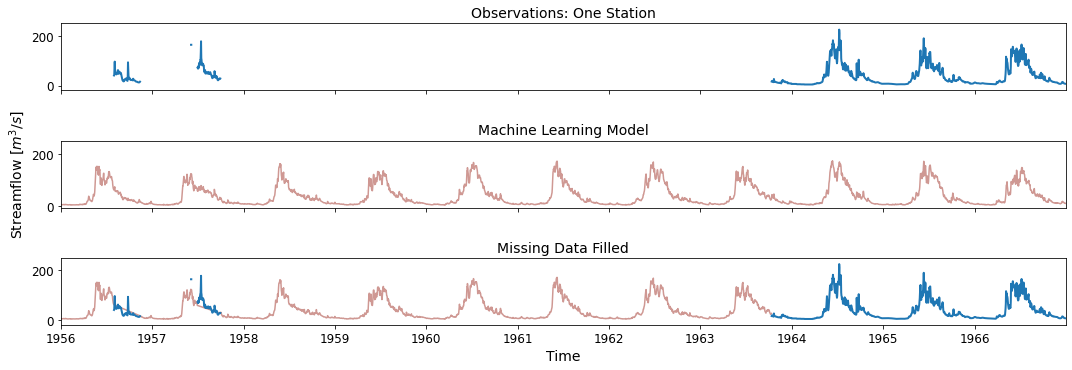

In [38]:
saveIt = 0

ind = 93

stationName = stationNames[ind]
ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

rgb_obs = '#1f77b4' #colour for shading that I like (picked from coolors.co)
rgb_mod = '#CF9893'

nrows = 3
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (15*ncols, 1.75*nrows))

year_start = 1956
year_fin = 1966
dt_start = datetime(year = year_start, month = 1, day = 1)
dt_fin = datetime(year = year_fin, month = 12, day = 31)
ymax = 250#np.nanmax(F_long[:,ind_long])

#observations
axes[0].plot(flowDate_long, F_long[:,ind_long], color = rgb_obs, label = 'Observations', linewidth = 2)
axes[0].set_xlim(left = dt_start, right = dt_fin)
axes[0].set_ylim(top = ymax)
axes[0].set_title('Observations: One Station', fontsize = fs)

#model
axes[1].plot(eraDate_hind[365:-1], y_hind_predict[:,ind]*Fstd[ind] + Fmean[ind], label = 'Model', color = rgb_mod)
axes[1].set_xlim(left = dt_start, right = dt_fin)
axes[1].set_ylim(top = ymax)
axes[1].set_title('Machine Learning Model', fontsize = fs)
axes[1].set_ylabel('Streamflow [$m^3/s$]', fontsize = fs)

#obsermodelvations
missing_inds = np.squeeze(np.argwhere(np.isnan(F_long[:6000,ind_long])))
axes[2].plot(flowDate_long, F_long[:,ind_long], color = rgb_obs, label = 'Observations', zOrder = 0, linewidth = 2)
axes[2].plot([eraDate_hind[kk] for kk in missing_inds], y_hind_predict[-365+missing_inds,ind]*Fstd[ind] + Fmean[ind], color = rgb_mod, zOrder = -1)
axes[2].set_xlim(left = dt_start, right = dt_fin)
axes[2].set_ylim(top = ymax)
axes[2].set_title('Missing Data Filled', fontsize = fs)
axes[2].set_xlabel('Time', fontsize = fs)

axes[0].tick_params(labelbottom = False, labelsize = fs - 2)
axes[1].tick_params(labelbottom = False, labelsize = fs - 2)
axes[2].tick_params(labelsize = fs - 2)

plt.tight_layout()

if saveIt:
  plt.savefig('missing_data_filled_example.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [39]:
#fraction missing data during period 1950 - 1978
hind_missing = np.zeros(len(stationInds))
start = flowDate_long.index(datetime(1951,1,1))
fin = flowDate_long.index(datetime(1978,12,31))
for kk, stationName in enumerate(stationNames):
  ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
  Nnan = len(np.argwhere(np.isnan(F_long[start:fin, ind_long])))
  Ndays = len(F_long[start:fin, ind_long])
  hind_missing[kk] = Nnan / Ndays

#yearly fraction missing data during period 1950 - 1978
yrs = range(1951, 2021)
hind_missing_yearly = np.zeros((len(stationInds), len(yrs)))
for kk, stationName in enumerate(stationNames):
  ind_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))
  for jj, yr in enumerate(yrs):
    start = flowDate_long.index(datetime(yr,1,1))
    fin = flowDate_long.index(datetime(yr,12,31))
    Nnan = len(np.argwhere(np.isnan(F_long[start:fin, ind_long])))
    Ndays = len(F_long[start:fin, ind_long])
    hind_missing_yearly[kk,jj] = Nnan / Ndays

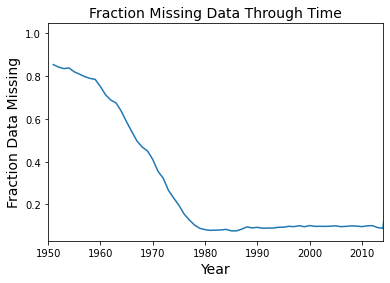

In [40]:
#fraction missing data in time

saveIt = 0

fs = 14

fig, ax = plt.subplots()
ax.plot(yrs, np.mean(hind_missing_yearly, axis = 0))
ax.set_xlabel('Year', fontsize = fs)
ax.set_ylabel('Fraction Data Missing', fontsize = fs)
ax.set_title('Fraction Missing Data Through Time', fontsize = fs)
ax.set_xlim((1950,2014))

if saveIt:
  plt.savefig('missing_data_in_time.png', dpi = 300, bbox_inches = 'tight')

plt.show()

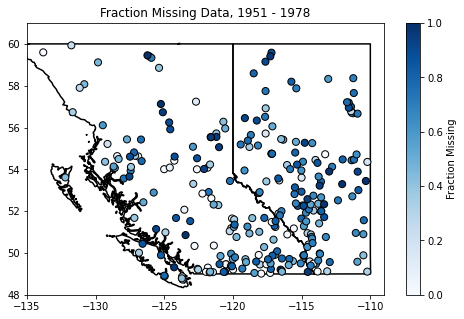

In [41]:
#fraction missing data in space

saveIt = 0

fig, ax = plt.subplots(figsize = (8,5))
s = ax.scatter(stationLon[stationInds], stationLat[stationInds], c = hind_missing, cmap = 'Blues', linewidth = 1, edgecolor = 'k', s = 50, zOrder = 3)
plot_prov_ax(prov, ax)
cb = plt.colorbar(s)
cb.set_label('Fraction Missing')
ax.set_title('Fraction Missing Data, 1951 - 1978')
ax.set_xlim((-135,-109))
ax.set_ylim((48,61))

if saveIt:
  plt.savefig('frac_missing_hindcast.png', bbox_inches = 'tight', dpi = 300)

plt.show()

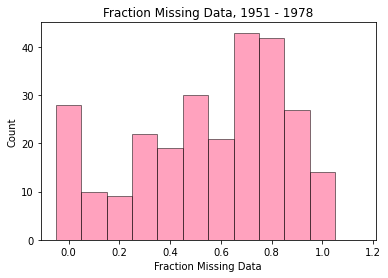

In [42]:
#fraction missing data histogram

saveIt = 0

dbin = 0.1
bins = np.arange(-0.5*dbin,1+2*dbin, dbin)

plt.hist(hind_missing, bins = bins, edgecolor = 'k', alpha = 0.5, facecolor = '#FF477E')
plt.title('Fraction Missing Data, 1951 - 1978')
plt.xlabel('Fraction Missing Data')
plt.ylabel('Count')

if saveIt:
  plt.savefig('frac_missing_hindcast_hist.png', bbox_inches = 'tight', dpi = 300)

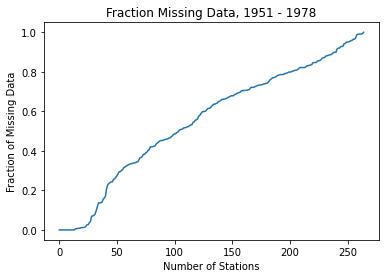

In [43]:
#fraction missing vs number of stations

plt.plot(np.sort(hind_missing))
plt.xlabel('Number of Stations')
plt.ylabel('Fraction of Missing Data')
plt.title('Fraction Missing Data, 1951 - 1978')

plt.show()

# Calculate % Glaciation

In [64]:
dir_rgi = dir_data + '/RGI/'
# hypso_filename = '02_rgi60_WesternCanadaUS_hypso.csv'
poly_filename = '02_rgi60_WesternCanadaUS.shp'
polys = gpd.read_file(dir_rgi + poly_filename)
cenLon = polys['CenLon']
cenLat = polys['CenLat']
area = polys['Area']

In [65]:
glacier_points = [Point(lon, lat) for lon, lat in zip(cenLon, cenLat)]
glacier_area_in = np.zeros(len(stationInds))
area_glaciers_in = np.zeros(len(stationInds))

for jj, basin in enumerate(stationBasins):

  if basin is not None:

    glaciers_in = np.zeros(len(cenLon))

    for kk, point in enumerate(glacier_points):
        glaciers_in[kk] = basin.contains(point)

    glaciers_in_inds = np.squeeze(np.argwhere(glaciers_in))
    area_glaciers_in[jj] = np.sum(area[glaciers_in_inds])

stationArea = np.array([float(flowDict['stationDrainageArea'][stationInds][kk][1:]) for kk in range(len(stationInds))])
stationPG = area_glaciers_in / stationArea

In [69]:
stationArea = np.array([float(flowDict['stationDrainageArea'][stationInds][kk][1:]) for kk in range(len(stationInds))])
stationPG = area_glaciers_in / stationArea

NameError: ignored

In [70]:
del polys, cenLon, cenLat, area, 

NameError: ignored

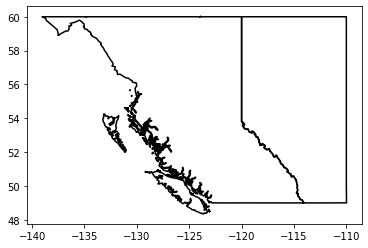

In [71]:
fig, ax = plt.subplots()

plot_prov_ax(['AB', 'BC'], ax)

plt.scatter(stationLon[stationInds], stationLat[stationInds], c = np.log(stationPG), edgecolor = 'k', s = 100, cmap = 'Blues')

# Evaluate model performance

In [44]:
eraDate_hind = eraDate_hind[365:]
eraDate_modern = eraDate_modern[365:]

In [45]:
start_obs = flowDate_long.index(datetime(1951,1,1))
fin_obs = flowDate_long.index(datetime(1978,12,31))

start_model = eraDate_hind.index(datetime(1951,1,1))
fin_model = eraDate_hind.index(datetime(1978,12,31))

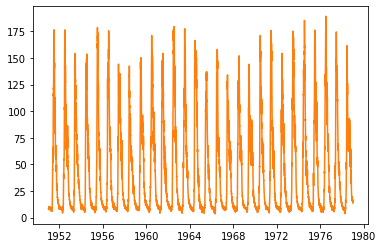

In [46]:
dd = np.array(eraDate_hind[start_model:fin_model])
station = 141
stationName = stationNames[station]
station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

# y_obs = F_long[start_obs:fin_obs, station_long]
y_obs = F_long[start_obs:fin_obs, station]
y_model = y_hind_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

plt.plot(dd, y_obs)
plt.plot(dd, y_model)

In [47]:
NSE_hind = np.zeros(len(stationInds))
NSE_modern = np.zeros(len(stationInds))

frac_max_missing_data = 1.#18/28
full_stations = np.squeeze(np.argwhere(hind_missing <= frac_max_missing_data))

for station in range(len(stationInds)):

  if hind_missing[station] < frac_max_missing_data:
    # print(station)

    stationName = stationNames[station]
    station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

    ### hindcast NSE

    start_obs = flowDate_long.index(datetime(1951,1,1))
    fin_obs = flowDate_long.index(datetime(1978,12,31))

    start_model = eraDate_hind.index(datetime(1951,1,1))
    fin_model = eraDate_hind.index(datetime(1978,12,31))

    dd = np.array(eraDate_hind[start_model:fin_model])

    y_obs = F_long[start_obs:fin_obs, station_long]
    # y_obs = F_long[start_obs:fin_obs, station]
    y_model = y_hind_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

    inds = np.squeeze(np.argwhere(np.isfinite(y_obs)))

    NSE_hind[station] = nse(y_obs = y_obs[inds],
                            y_model = y_model[inds])
    
    ### modern NSE

    start_obs = flowDate_long.index(datetime(1980,1,1))
    fin_obs = flowDate_long.index(datetime(2015,12,31))

    start_model = eraDate_modern.index(datetime(1980,1,1))
    fin_model = eraDate_modern.index(datetime(2015,12,31))

    start_obs = flowDate_long.index(datetime(2011,1,1))
    fin_obs = flowDate_long.index(datetime(2015,12,31))

    start_model = eraDate_modern.index(datetime(2011,1,1))
    fin_model = eraDate_modern.index(datetime(2015,12,31))

    dd = np.array(eraDate_hind[start_model:fin_model])

    y_obs = F_long[start_obs:fin_obs, station_long]
    # y_obs = F_long[start_obs:fin_obs, station]
    y_model = y_modern_predict[start_model:fin_model, station]*Fstd[station] + Fmean[station]

    inds = np.squeeze(np.argwhere(np.isfinite(y_obs)))

    NSE_modern[station] = nse(y_obs = y_obs[inds],
                            y_model = y_model[inds])

dNSE = NSE_hind - NSE_modern

(array([  1.,   0.,   0.,   1.,  13.,  34.,  40.,  28.,  48., 100.]),
 array([-0.77263469, -0.599806  , -0.42697731, -0.25414862, -0.08131993,
         0.09150876,  0.26433745,  0.43716614,  0.60999483,  0.78282352,
         0.95565221]),
 <a list of 10 Patch objects>)

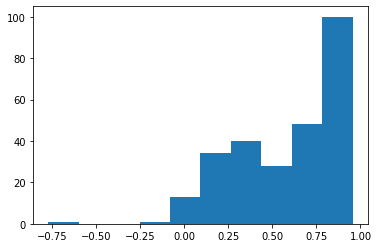

In [48]:
plt.hist(NSE_modern)

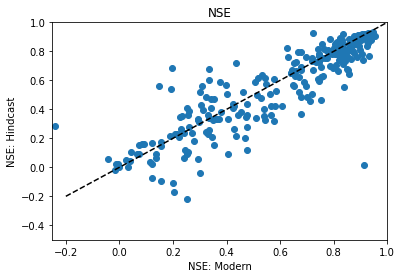

In [49]:
#compare NSE between modern/hindcast

saveIt = 0

plt.scatter(NSE_modern[full_stations], NSE_hind[full_stations])
plt.plot([-0.2,1],[-0.2,1], 'k--')
plt.ylim((-0.5,1))
plt.xlim((-0.25, 1))
plt.xlabel('NSE: Modern')
plt.ylabel('NSE: Hindcast')
plt.title('NSE')

if saveIt:
  plt.savefig('NSE_modern_hind_scatter.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
# #details for plotting/visualizations 

# #determine RGB values of colormap to use: chosen from coolors.co
# rgbs = [[241, 135, 1], #cluster 0
#       [205, 223, 160], #cluster 1
#       [159, 222, 249], #etc
#       [233, 134, 207],
#       [21, 96, 121],
#       [100, 23, 35],
#       [250, 200, 205],
#       [177, 15, 46]]

# rgbas = [[241, 135, 1,256],
#       [205, 223, 160,256],
#       [159, 222, 249,256],
#       [233, 134, 207,256],
#       [21, 96, 121,256],
#       [100, 23, 35,256],
#       [250, 200, 205, 256],
#       [177, 15, 46, 256]]

# rgbs_array = np.asarray(rgbs)/256
# rgbas_array = np.asarray(rgbas)/256

# #colours of each station
# cStations = np.empty((len(stationInds), 3))
# for kk in range(len(stationInds)):
#   cStations[kk,:] = rgbs[int(labels[kk])]
# cStations /= 256

# #assign geographically relevant names for each cluster
# cluster_names = [
#                  'Central',       #cluster 0
#                  'Southern',      #cluster 1
#                  'Eastern',       #etc
#                  'Coastal',
#                  'North-Western',
#                  'North-Eastern',
#                  'Far North-West',
#                  'Far North-East'
# ]

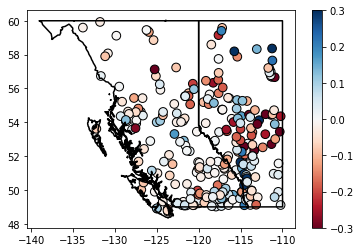

In [ ]:
fig, ax = plt.subplots()
plot_prov_ax(prov = prov, ax = ax)
s = ax.scatter(stationLon[stationInds][full_stations], 
               stationLat[stationInds][full_stations], 
               c = dNSE[full_stations], 
               s = 75,
               edgecolor = 'k',
               cmap = 'RdBu',
               vmin = -0.3, 
               vmax = 0.3)#vmin = -0.5, vmax = 1, )
fig.colorbar(s)

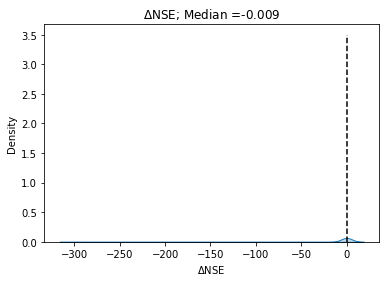

In [ ]:
#dNSE distribution

saveIt = 0

xx = np.sort(dNSE[full_stations])#[2:]
dNSE_median = np.median(dNSE[full_stations])

fig, ax = plt.subplots()
kde = sns.kdeplot(xx, ax = ax, shade = True)
ax.plot([dNSE_median,dNSE_median],[0, 3.5], 'k--')
ax.set_ylim(bottom = 0)
ax.set_xlabel('$\Delta$NSE')
ax.set_title('$\Delta$NSE; Median =' + str(np.round(dNSE_median, decimals = 3)))

if saveIt:
  plt.savefig('dNSE_kde.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
full_glaciers = np.intersect1d(full_stations, np.argwhere(stationPG>0))
full_no_glaciers = np.intersect1d(full_stations, np.argwhere(stationPG==0))

In [ ]:
dNSE_glaciers_median = np.median(dNSE[full_glaciers])
dNSE_no_glaciers_median = np.median(dNSE[full_no_glaciers])
dNSE_glaciers_median, dNSE_no_glaciers_median, dNSE_median

(-0.01757730168847238, -0.0024639587916815975, -0.0089421032144682)

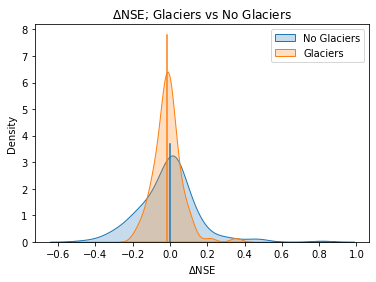

In [ ]:
#compare non-glacier-fed to glacier-fed

saveIt = 0

fig, ax = plt.subplots()
xx = np.sort(dNSE[full_no_glaciers])[2:]
dNSE_median = np.median(dNSE[full_no_glaciers])
kde = sns.kdeplot(xx, ax = ax, shade = True, label = 'No Glaciers')
ax.plot([dNSE_median,dNSE_median],[0, 3.7])#, 'k--')

xx = np.sort(dNSE[full_glaciers])[2:]
dNSE_median = np.median(dNSE[full_glaciers])
kde = sns.kdeplot(xx, ax = ax, shade = True, label = 'Glaciers')
ax.plot([dNSE_median,dNSE_median],[0, 7.8])#, 'k--')

plt.legend()
ax.set_xlabel('$\Delta$NSE')
ax.set_title('$\Delta$NSE; Glaciers vs No Glaciers')

if saveIt:
  plt.savefig('dNSE_kde_non_glacier_vs_glacier.png', bbox_inches = 'tight', dpi = 300)

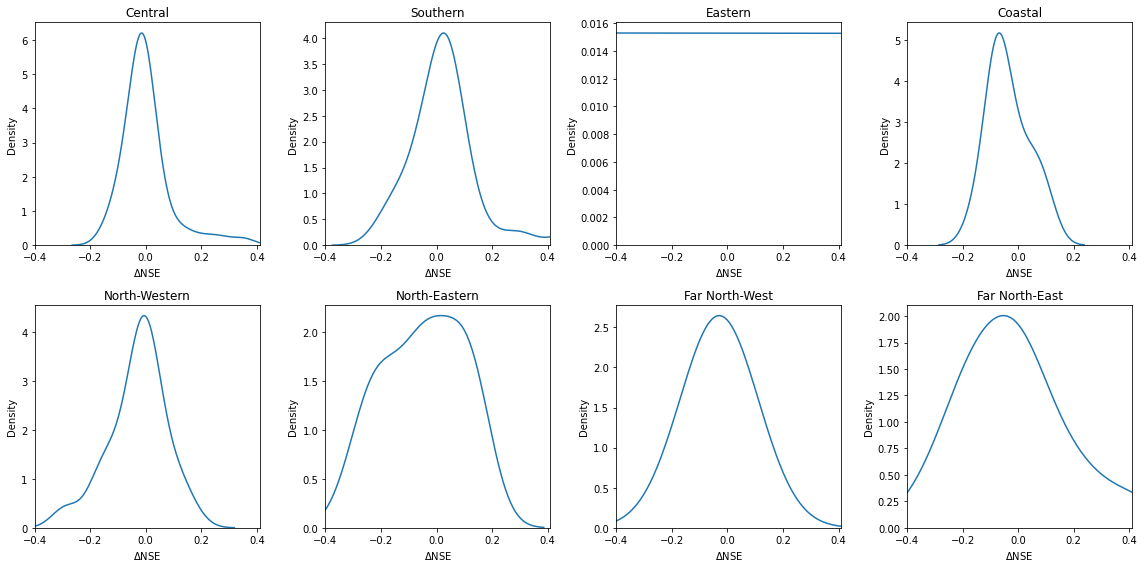

In [ ]:
nrows = 2
ncols = 4

fix, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):
  cluster_inds = np.squeeze(np.argwhere(labels == cluster))
  kde = sns.kdeplot(dNSE[cluster_inds], ax = ax)#, color = rgbas_array[cluster,:], fill = True, alpha = 0.5, edgecolor = 'k')
  ax.set_xlim((-0.4,0.41))
  ax.set_title(cluster_names[cluster])
  ax.set_xlabel('$\Delta$NSE')

plt.tight_layout()


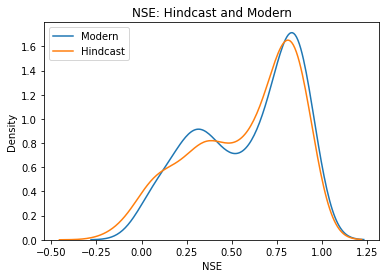

In [ ]:
sns.kdeplot(NSE_modern[full_stations][NSE_modern[full_stations]>np.sort(NSE_modern[full_stations])[2]], label = 'Modern')
sns.kdeplot(NSE_hind[full_stations][NSE_hind[full_stations]>np.sort(NSE_hind[full_stations])[2]], label = 'Hindcast')
plt.xlabel('NSE')
plt.title('NSE: Hindcast and Modern')
plt.legend()

plt.show()

(array([ 4., 18., 13., 17., 26., 20., 20., 26., 44., 54., 18.,  0.]),
 array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
         1. ,  1.1]),
 <a list of 12 Patch objects>)

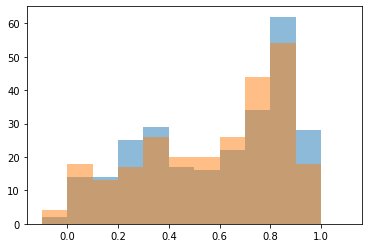

In [ ]:
bins = np.arange(-0.1,1.1,0.1)
plt.hist(NSE_modern, bins = bins, alpha = 0.5)
plt.hist(NSE_hind, bins = bins, alpha = 0.5)


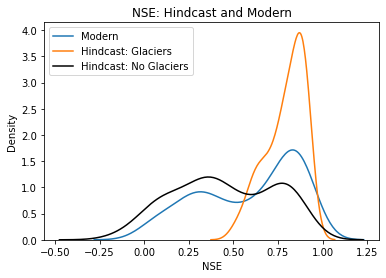

In [ ]:
sns.kdeplot(NSE_modern[full_stations][NSE_modern[full_stations]>np.sort(NSE_modern[full_stations])[2]], label = 'Modern')
sns.kdeplot(NSE_hind[full_glaciers][NSE_hind[full_glaciers]>np.sort(NSE_hind[full_glaciers])[2]], label = 'Hindcast: Glaciers')
sns.kdeplot(NSE_hind[full_no_glaciers][NSE_hind[full_no_glaciers]>np.sort(NSE_hind[full_no_glaciers])[2]], color = 'k', label = 'Hindcast: No Glaciers')
plt.xlabel('NSE')
plt.title('NSE: Hindcast and Modern')
plt.legend()

plt.show()

# Check hydrological indices

In [ ]:
#plan: evaluate set of indices over modern period as well as hind casted period -- see if they are substantially different
#goal: want stations where hindcast is not much different than modern

In [ ]:
#total yearly flow

total_flow_modern = np.zeros((36,len(stationInds)))
total_flow_hind = np.zeros((28,len(stationInds)))

total_flow_modern_model = np.zeros((36,len(stationInds)))
total_flow_hind_model = np.zeros((28,len(stationInds)))

for station in range(len(stationInds)):

  stationName = stationNames[station]
  station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

### hindcast

  #un-normalize
  F_hind_predict = y_hind_predict[:,station]#*Fstd[station] + Fmean[station]
  F_hind = (F_long[:, station_long] - Fmean[station]) / Fstd[station]

  #total yearly flow
  for kk, year in enumerate(range(1951,1979)):

    start = datetime(year, 1, 1)
    fin = start + timedelta(days=364)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_hind.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_hind.index(fin)

    total_flow_hind_model[kk, station] = np.nansum(F_hind_predict[start_mod:fin_mod])
    total_flow_hind[kk,station] = np.nansum(F_hind[start_obs:fin_obs])

### modern

  #un-normalize
  F_modern_predict = y_modern_predict[:,station]#*Fstd[station] + Fmean[station]
  F_modern = (F_long[:, station_long] - Fmean[station]) / Fstd[station]

  #total yearly flow
  for kk, year in enumerate(range(1980,2016)):
    
    start = datetime(year, 1, 1)
    fin = start + timedelta(days=364)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_modern.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_modern.index(fin)

    # print(F_modern[start_obs:fin_obs])
    total_flow_modern_model[kk, station] = np.nansum(F_modern_predict[start_mod:fin_mod])
    total_flow_modern[kk,station] = np.nansum(F_modern[start_obs:fin_obs])

total_flow = np.vstack([total_flow_hind, total_flow_modern])
total_flow_model = np.vstack([total_flow_hind_model, total_flow_modern_model])

In [ ]:
#total JAS flow

JAS_flow_modern = np.zeros((36,len(stationInds)))
JAS_flow_hind = np.zeros((28,len(stationInds)))

JAS_flow_modern_model = np.zeros((36,len(stationInds)))
JAS_flow_hind_model = np.zeros((28,len(stationInds)))

for station in range(len(stationInds)):

  stationName = stationNames[station]
  station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

### hindcast

  #un-normalize
  F_hind_predict = y_hind_predict[:,station]#*Fstd[station] + Fmean[station]
  F_hind = (F_long[:, station_long] - Fmean[station]) / Fstd[station]

  #total yearly flow
  for kk, year in enumerate(range(1951,1979)):

    start = datetime(year, 7, 1)
    fin = datetime(year, 9, 30)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_hind.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_hind.index(fin)

    JAS_flow_hind_model[kk, station] = np.nansum(F_hind_predict[start_mod:fin_mod]) 
    JAS_flow_hind[kk,station] = np.nansum(F_hind[start_obs:fin_obs]) 

### modern

  #un-normalize
  F_modern_predict = y_modern_predict[:,station]#*Fstd[station] + Fmean[station]
  F_modern = (F_long[:, station_long] - Fmean[station]) / Fstd[station]

  #total yearly flow
  for kk, year in enumerate(range(1980,2016)):
    
    start = datetime(year, 7, 1)
    fin = datetime(year, 9, 30)

    start_obs = flowDate_long.index(start)
    start_mod = eraDate_modern.index(start)

    fin_obs = flowDate_long.index(fin)
    fin_mod = eraDate_modern.index(fin)

    JAS_flow_modern_model[kk, station] = np.nansum(F_modern_predict[start_mod:fin_mod]) 
    JAS_flow_modern[kk,station] = np.nansum(F_modern[start_obs:fin_obs]) 

JAS_flow = np.vstack([JAS_flow_hind, JAS_flow_modern])
JAS_flow_model = np.vstack([JAS_flow_hind_model, JAS_flow_modern_model])

#set 0s to nans
for station in range(len(stationInds)):
  # nan_inds = np.squeeze(np.argwhere)
  total_flow[total_flow[:,station] == 0,station] = np.nan
  JAS_flow[JAS_flow[:,station] == 0,station] = np.nan

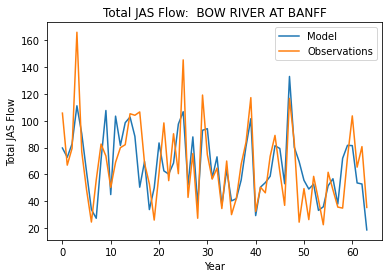

In [ ]:
saveIt = 0

ind = 157

plt.figure(figsize = (6,4))

# plt.subplot(121)
# plt.plot(total_flow_model[:,ind], label = 'Model')
# plt.plot(total_flow[:,ind], label = 'Observations')
# plt.title('Total Yearly Flow')
# plt.legend()

plt.subplot(111)
plt.plot(JAS_flow_model[:,ind], label = 'Model')
plt.plot(JAS_flow[:,ind], label = 'Observations')
plt.title('Total JAS Flow: ' + stationNames[ind])
plt.xlabel('Year')
plt.ylabel('Total JAS Flow')

plt.legend()

if saveIt:
  plt.savefig('JAS_Banff.png', bbox_inches = 'tight', dpi = 300)

plt.show()

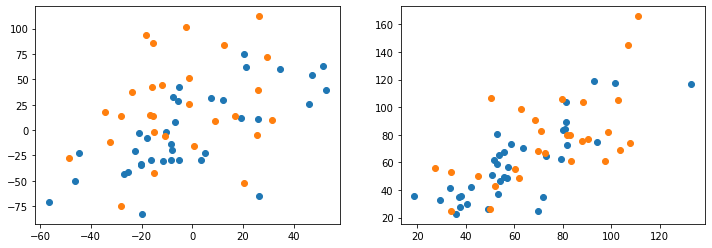

In [ ]:
# ind = 141
plt.figure(figsize = (12,4))

plt.subplot(121)
plt.scatter(total_flow_modern_model[:,ind], total_flow_modern[:,ind])
plt.scatter(total_flow_hind_model[:,ind], total_flow_hind[:,ind])

plt.subplot(122)
plt.scatter(JAS_flow_modern_model[:,ind], JAS_flow_modern[:,ind])
plt.scatter(JAS_flow_hind_model[:,ind], JAS_flow_hind[:,ind])

In [ ]:
# #freshet correlation by regime

# fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize  =(8,4))

# sns.boxplot(x = labels[full_stations], 
#             y = JAS_corr_modern[full_stations],
#             ax = axes[0])
# axes[0].set_title('Modern: Freshet Correlation')
# axes[0].set_ylim((0,1))

# sns.boxplot(x = labels[full_stations], 
#             y = JAS_corr_hind[full_stations],
#             ax = axes[1])
# axes[1].set_title('Hindcast: Freshet Correlation')
# axes[1].set_ylim((0,1))



In [ ]:
# fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 5))

# for cluster, ax in enumerate(axes.flatten()):
#   cluster_inds = np.squeeze(np.argwhere(labels == cluster))
#   inds = np.intersect1d(full_stations,cluster_inds)
#   sns.kdeplot(freshet_corr_modern[inds], ax = ax, label = 'Modern')
#   # ax.hist(freshet_corr_modern[inds])
#   sns.kdeplot(freshet_corr_hind[inds], ax = ax, label = 'Hindcast')
#   ax.set_xlim((-0.5,1.2))
#   ax.set_title(cluster_names[cluster])
#   ax.legend()

# plt.tight_layout()

In [ ]:
#Mann-Kendall trends of modelled/observed JAS flow

JAS_trend_mod = np.zeros(len(stationInds))
JAS_p_mod = np.zeros(len(stationInds))

JAS_trend_obs = np.zeros(len(stationInds))
JAS_p_obs = np.zeros(len(stationInds))

total_trend_mod = np.zeros(len(stationInds))
total_p_mod = np.zeros(len(stationInds))

for station in range(len(stationInds)):

  MK = mk.original_test(JAS_flow_model[:,station])
  JAS_trend_mod[station] = MK.slope
  JAS_p_mod[station] = MK.p

  MK = mk.original_test(JAS_flow[:,station])
  JAS_trend_obs[station] = MK.slope
  JAS_p_obs[station] = MK.p

  # MK = mk.original_test(t_peak[:,station])
  # total_trend_mod[station] = MK.slope
  # total_p_mod[station] = MK.p

print(len(np.argwhere(JAS_p_mod < 0.1)))
# print(len(np.argwhere(peak_p_mod < 0.1)))
print(np.median(JAS_trend_mod))
print(np.median(JAS_trend_obs))


147
-0.20128013418435556
-0.18505248827047657


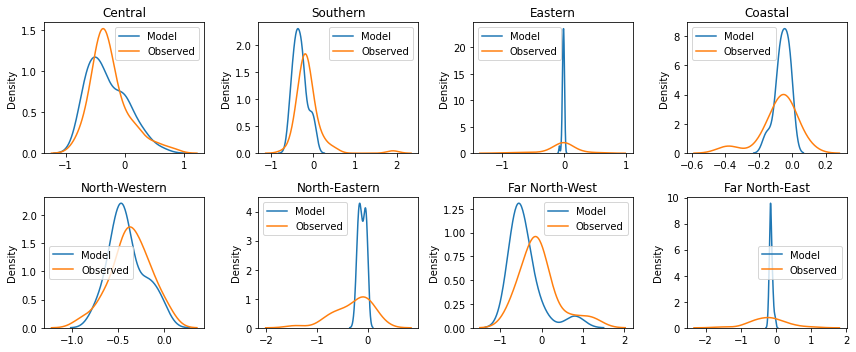

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 5))

for cluster, ax in enumerate(axes.flatten()):
  cluster_inds = np.squeeze(np.argwhere(labels == cluster))
  inds = np.intersect1d(full_stations,cluster_inds)
  sns.kdeplot(JAS_trend_mod[inds], ax = ax, label = 'Model')
  # ax.hist(freshet_corr_modern[inds])
  sns.kdeplot(JAS_trend_obs[inds], ax = ax, label = 'Observed')
  # ax.set_xlim((-0.5,1.2))
  ax.set_title(cluster_names[cluster])
  ax.legend()

plt.tight_layout()

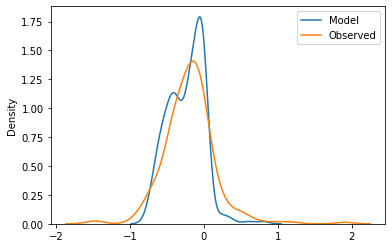

In [ ]:
# sns.kdeplot(freshet_trend_mod[full_stations], label = 'Model')
# sns.kdeplot(freshet_trend_obs[full_stations], label = 'Observed')

sns.kdeplot(JAS_trend_mod[full_stations], label = 'Model')
sns.kdeplot(JAS_trend_obs[full_stations], label = 'Observed')

plt.legend()

plt.show()

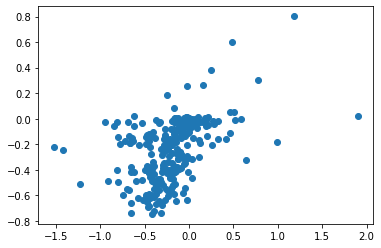

In [ ]:
plt.scatter(JAS_trend_obs, JAS_trend_mod)

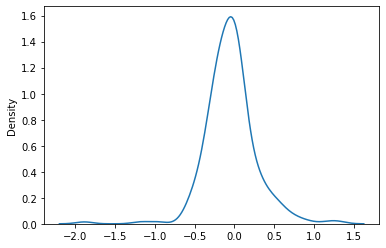

In [ ]:
d_JAS_trend = JAS_trend_mod - JAS_trend_obs
# d_JAS_corr = freshet_corr_hind - freshet_corr_modern

sns.kdeplot(d_JAS_trend[full_stations])

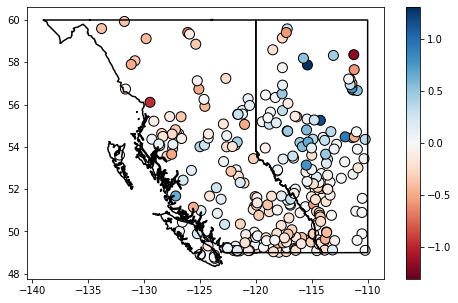

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

# cc = freshet_corr_modern
# cc = d_freshet_corr
cc = d_JAS_trend[full_stations]

vmax = np.nanmax(np.sort(np.abs(cc))[:-1])
vmin = -vmax

plot_prov_ax(prov, ax)
plt.scatter(stationLon[stationInds[full_stations]], 
            stationLat[stationInds[full_stations]], 
            c = cc, 
            s = 100, cmap = 'RdBu', edgecolor = 'k', vmin = vmin, vmax = vmax)
plt.colorbar()

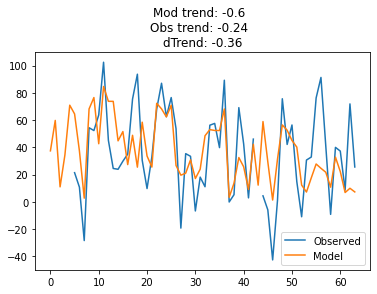

In [ ]:
ind = 138

# plt.plot(t_half_obs[:,full_stations[ind]], label = 'Observed')
# plt.plot(t_half[:,full_stations[ind]], label = 'Model')
# plt.title('Mod trend: ' + str(np.round(freshet_trend_mod[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\nObs trend: ' + str(np.round(freshet_trend_obs[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\ndTrend: ' + str(np.round(d_freshet_trend[full_stations[ind]], decimals = 2)) + ' ' + 
#           '\nModern corr: ' + str(np.round(freshet_corr_modern[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\nObserv corr: ' + str(np.round(freshet_corr_hind[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\ndCorr: ' + str(np.round(d_freshet_corr[full_stations[ind]], decimals = 2)))
# plt.legend()


plt.plot(JAS_flow[:,ind], label = 'Observed')
plt.plot(JAS_flow_model[:,ind], label = 'Model')
plt.title('Mod trend: ' + str(np.round(JAS_trend_mod[ind], decimals = 2)) + '  ' + 
          '\nObs trend: ' + str(np.round(JAS_trend_obs[ind], decimals = 2)) + '  ' + 
          '\ndTrend: ' + str(np.round(d_JAS_trend[ind], decimals = 2)))# + ' ' + 
          # '\nModern corr: ' + str(np.round(freshet_corr_modern[ind], decimals = 2)) + '  ' + 
          # '\nObserv corr: ' + str(np.round(freshet_corr_hind[ind], decimals = 2)) + '  ' + 
          # '\ndCorr: ' + str(np.round(d_freshet_corr[ind], decimals = 2)))
plt.legend()

plt.show()

In [ ]:
#RMSE: all time, low flow, and high flow

#by low/high
RMSE_low_modern = np.zeros(len(stationInds))
RMSE_low_hind = np.zeros(len(stationInds))

RMSE_high_modern = np.zeros(len(stationInds))
RMSE_high_hind = np.zeros(len(stationInds))

RMSE_modern = np.zeros(len(stationInds))
RMSE_hind = np.zeros(len(stationInds))

#normalized
# RMSE_low_modern_norm = np.zeros(len(stationInds))
# RMSE_low_hind_norm = np.zeros(len(stationInds))

# RMSE_high_modern_norm = np.zeros(len(stationInds))
# RMSE_high_hind_norm = np.zeros(len(stationInds))

# RMSE_modern_norm = np.zeros(len(stationInds))
# RMSE_hind_norm = np.zeros(len(stationInds))

#by season
RMSE_DJF_modern = np.zeros(len(stationInds))
RMSE_DJF_hind = np.zeros(len(stationInds))

RMSE_MAM_modern = np.zeros(len(stationInds))
RMSE_MAM_hind = np.zeros(len(stationInds))

RMSE_JJA_modern = np.zeros(len(stationInds))
RMSE_JJA_hind = np.zeros(len(stationInds))

RMSE_SON_modern = np.zeros(len(stationInds))
RMSE_SON_hind = np.zeros(len(stationInds))

#R^2
R2_modern = np.zeros(len(stationInds))
R2_hind = np.zeros(len(stationInds))

#calculate RMSE at each station
for station in range(len(stationInds)-1):

  stationName = stationNames[station]
  station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

### modern

  #time period
  start = datetime(2011, 1, 1)
  fin = datetime(2015,12,31)

  start_obs = flowDate_long.index(start)
  start_mod = eraDate_modern.index(start)

  fin_obs = flowDate_long.index(fin)
  fin_mod = eraDate_modern.index(fin)

  #un-normalize
  F_modern_predict = y_modern_predict[start_mod:fin_mod,station]#*Fstd[station] + Fmean[station]
  F_modern = (F_long[start_obs:fin_obs, station_long] - Fmean[station]) / Fstd[station]

  #low and high flow indices -- defined relative to modern observations
  low_flow_inds = np.argwhere(F_modern < 0.2*np.nanmean(F_modern))
  high_flow_inds = np.argwhere(F_modern > 0.8*np.nanmean(F_modern))

  #calculate RMSE by high/low
  RMSE_modern[station] = rmse(
      y_model = F_modern_predict, 
      y_obs = F_modern
      )
  
  RMSE_low_modern[station] = rmse(
      y_model = F_modern_predict[low_flow_inds], 
      y_obs = F_modern[low_flow_inds]
      )
  
  RMSE_high_modern[station] = rmse(
      y_model = F_modern_predict[high_flow_inds], 
      y_obs = F_modern[high_flow_inds]
      )
  
  #normalized
  # RMSE_modern_norm[station] = RMSE_modern[station] / Fmean[station]
  
  # RMSE_low_modern_norm[station] = RMSE_low_modern[station] / Fmean[station]
  
  # RMSE_high_modern_norm[station] = RMSE_high_modern[station] / Fmean[station]

  #RMSE by season

  inds_DJF_obs_m, inds_MAM_obs_m, inds_JJA_obs_m, inds_SON_obs_m = get_seasonal_inds_from_list(flowDate_long[start_obs : fin_obs])
  inds_DJF_mod_m, inds_MAM_mod_m, inds_JJA_mod_m, inds_SON_mod_m = get_seasonal_inds_from_list(eraDate_modern[start_mod : fin_mod])
  
  RMSE_DJF_modern[station] = rmse(
      y_model = F_modern_predict[inds_DJF_mod_m],
      y_obs = F_modern[inds_DJF_obs_m]
  ) #/ Fmean[station]

  RMSE_MAM_modern[station] = rmse(
      y_model = F_modern_predict[inds_MAM_mod_m],
      y_obs = F_modern[inds_MAM_obs_m]
  ) #/ Fmean[station]

  RMSE_JJA_modern[station] = rmse(
      y_model = F_modern_predict[inds_JJA_mod_m],
      y_obs = F_modern[inds_JJA_obs_m]
  ) #/ Fmean[station]

  RMSE_SON_modern[station] = rmse(
      y_model = F_modern_predict[inds_SON_mod_m],
      y_obs = F_modern[inds_SON_obs_m]
  ) #/ Fmean[station]

  #R^2 -- use pandas because it can easily handle nans
  df = pd.DataFrame({'x': F_modern, 'y': F_modern_predict})
  R2_modern[station] = df.corr()['x']['y']**2

### hindcast

  #time period
  start = datetime(1951, 1, 1)
  fin = datetime(1978,12,31)

  start_obs = flowDate_long.index(start)
  start_mod = eraDate_hind.index(start)

  fin_obs = flowDate_long.index(fin)
  fin_mod = eraDate_hind.index(fin)

  #un-normalize
  F_hind_predict = y_hind_predict[start_mod:fin_mod,station]#*Fstd[station] + Fmean[station]
  F_hind = (F_long[start_obs:fin_obs, station_long] - Fmean[station]) / Fstd[station]

  #low and high flow indices -- defined relative to observations
  low_flow_inds = np.argwhere(F_hind < 0.2*np.nanmean(F_modern))
  high_flow_inds = np.argwhere(F_hind > 0.8*np.nanmean(F_modern))

  RMSE_hind[station] = rmse(
      y_model = F_hind_predict, 
      y_obs = F_hind
      )
  
  RMSE_low_hind[station] = rmse(
      y_model = F_hind_predict[low_flow_inds], 
      y_obs = F_hind[low_flow_inds]
      )
  
  RMSE_high_hind[station] = rmse(
      y_model = F_hind_predict[high_flow_inds], 
      y_obs = F_hind[high_flow_inds]
      )
  
  # RMSE_hind_norm[station] = RMSE_hind[station] / Fmean[station]
  
  # RMSE_low_hind_norm[station] = RMSE_low_hind[station] / Fmean[station]
  
  # RMSE_high_hind_norm[station] = RMSE_high_hind[station] / Fmean[station]

  #RMSE by season

  inds_DJF_obs, inds_MAM_obs, inds_JJA_obs, inds_SON_obs = get_seasonal_inds_from_list(flowDate_long[start_obs : fin_obs])
  inds_DJF_mod, inds_MAM_mod, inds_JJA_mod, inds_SON_mod = get_seasonal_inds_from_list(eraDate_hind[start_mod : fin_mod])
  
  RMSE_DJF_hind[station] = rmse(
      y_model = F_hind_predict[inds_DJF_mod],
      y_obs = F_hind[inds_DJF_obs]
  ) #/ Fmean[station]

  RMSE_MAM_hind[station] = rmse(
      y_model = F_hind_predict[inds_MAM_mod],
      y_obs = F_hind[inds_MAM_obs]
  ) #/ Fmean[station]

  RMSE_JJA_hind[station] = rmse(
      y_model = F_hind_predict[inds_JJA_mod],
      y_obs = F_hind[inds_JJA_obs]
  ) #/ Fmean[station]

  RMSE_SON_hind[station] = rmse(
      y_model = F_hind_predict[inds_SON_mod],
      y_obs = F_hind[inds_SON_obs]
  ) #/ Fmean[station]

  #R^2 -- use pandas because it can easily handle nans
  df = pd.DataFrame({'x': F_hind, 'y': F_hind_predict})
  R2_hind[station] = df.corr()['x']['y']**2

#difference between hindcast and modern
dRMSE = RMSE_hind - RMSE_modern
dRMSE_low = RMSE_low_hind - RMSE_low_modern
dRMSE_high = RMSE_high_hind - RMSE_high_modern
dRMSE_DJF = RMSE_DJF_hind - RMSE_DJF_modern
dRMSE_MAM = RMSE_MAM_hind - RMSE_MAM_modern
dRMSE_JJA = RMSE_JJA_hind - RMSE_JJA_modern
dRMSE_SON = RMSE_SON_hind - RMSE_SON_modern

dR2 = R2_hind - R2_modern

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


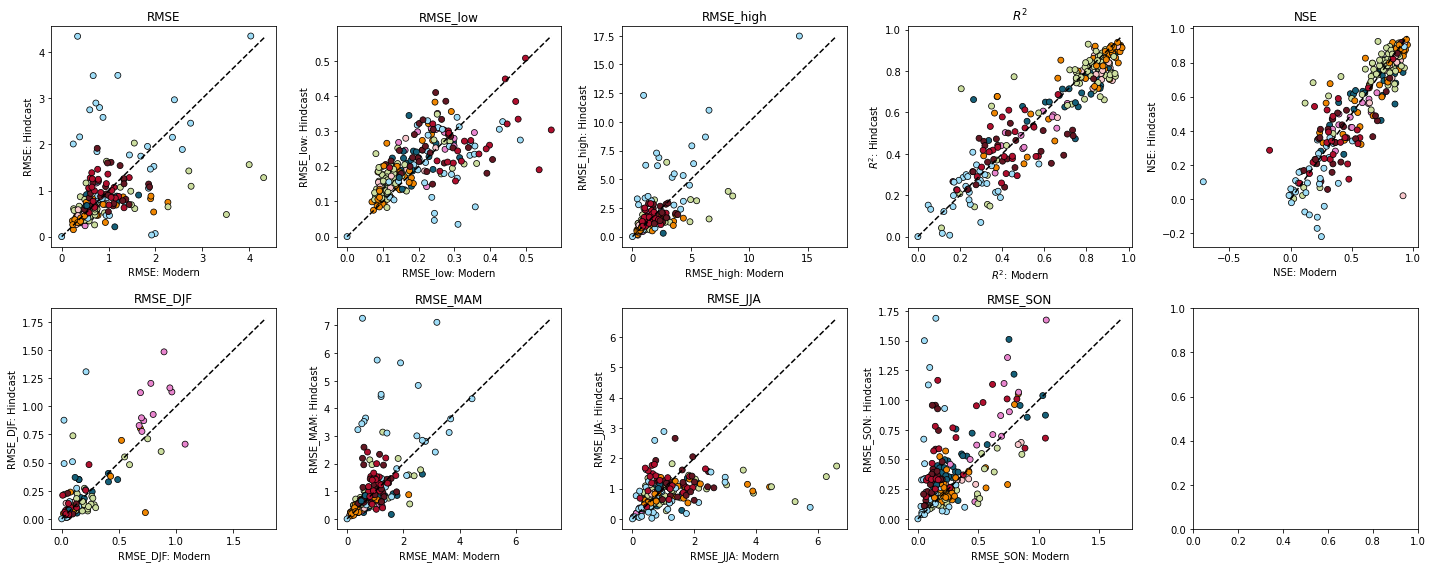

In [ ]:
metrics = {
    'RMSE': [RMSE_hind, RMSE_modern],
    'RMSE_low' : [RMSE_low_hind, RMSE_low_modern],
    'RMSE_high' : [RMSE_high_hind, RMSE_high_modern],
    '$R^2$' : [R2_hind, R2_modern],
    'NSE' : [NSE_hind, NSE_modern],
    'RMSE_DJF' : [RMSE_DJF_hind, RMSE_DJF_modern],
    'RMSE_MAM' : [RMSE_MAM_hind, RMSE_MAM_modern],
    'RMSE_JJA' : [RMSE_JJA_hind, RMSE_JJA_modern],
    'RMSE_SON' : [RMSE_SON_hind, RMSE_SON_modern]
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(metrics.keys()):

  xx = metrics[metric][1][full_stations]
  yy = metrics[metric][0][full_stations]

  ax = axes.flatten()[kk]

  if metric == 'NSE':
    xx = xx[yy>-10]
    yy = yy[yy>-10]
    ax.scatter(xx, yy, c = cStations[full_stations][np.squeeze(np.argwhere(yy>-10)),:], edgecolor = 'k', linewidth = 0.75)
  else:
    ax.scatter(xx, yy, c = cStations[full_stations], edgecolor = 'k', linewidth = 0.75)

  # ax.scatter(xx, yy, c = cStations)
  ax.plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
  ax.set_xlabel(metric + ': Modern')
  ax.set_ylabel(metric + ': Hindcast')
  ax.set_title(metric)

plt.tight_layout()

plt.show()

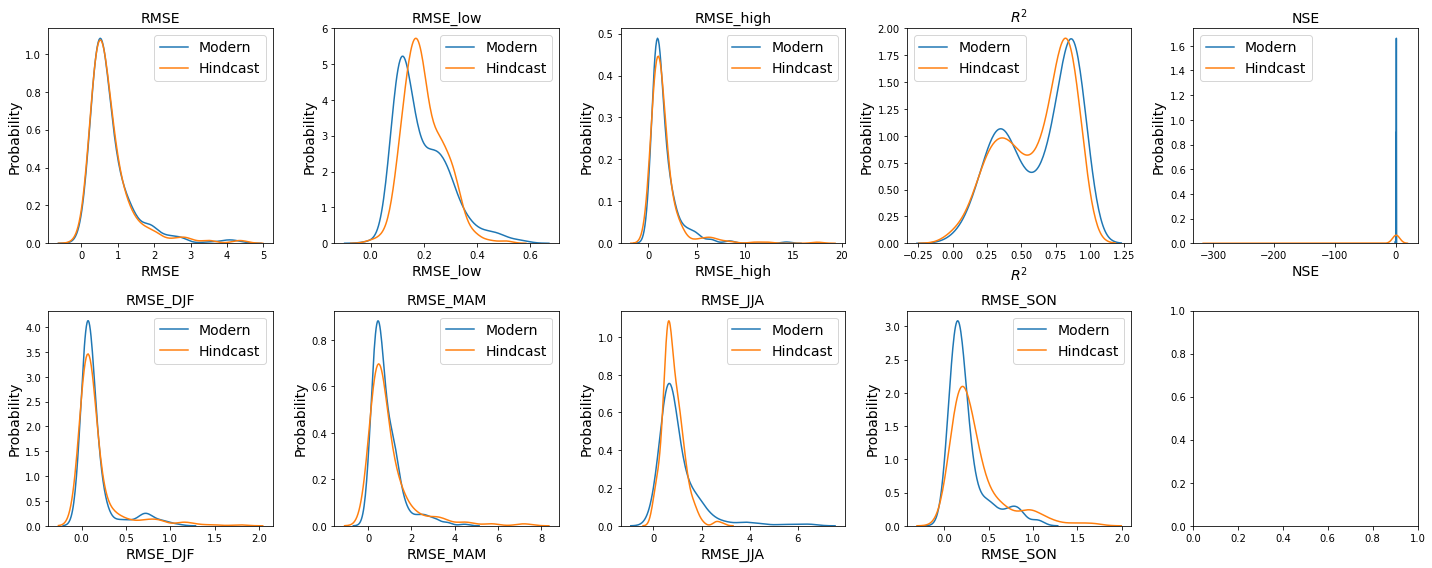

In [ ]:
saveIt = 0

metrics = {
    'RMSE': [RMSE_hind, RMSE_modern],
    'RMSE_low' : [RMSE_low_hind, RMSE_low_modern],
    'RMSE_high' : [RMSE_high_hind, RMSE_high_modern],
    '$R^2$' : [R2_hind, R2_modern],
    'NSE' : [NSE_hind, NSE_modern],
    'RMSE_DJF' : [RMSE_DJF_hind, RMSE_DJF_modern],
    'RMSE_MAM' : [RMSE_MAM_hind, RMSE_MAM_modern],
    'RMSE_JJA' : [RMSE_JJA_hind, RMSE_JJA_modern],
    'RMSE_SON' : [RMSE_SON_hind, RMSE_SON_modern]
}

fs = 14

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(metrics.keys()):

  xx = metrics[metric][1][full_stations]
  yy = metrics[metric][0][full_stations]

  ax = axes.flatten()[kk]

  # if metric == 'NSE':
  #   xx = xx[yy>-10]
  #   yy = yy[yy>-10]
  #   ax.scatter(xx, yy, c = cStations[full_stations][np.squeeze(np.argwhere(yy>-10)),:], edgecolor = 'k', linewidth = 0.75)
  # else:
  #   ax.scatter(xx, yy, c = cStations[full_stations], edgecolor = 'k', linewidth = 0.75)

  sns.kdeplot(xx, ax = ax, label = 'Modern')
  sns.kdeplot(yy, ax = ax, label = 'Hindcast')

  # ax.scatter(xx, yy, c = cStations)
  # ax.plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
  ax.set_xlabel(metric, fontsize = fs)
  ax.set_ylabel('Probability', fontsize = fs)
  ax.set_title(metric, fontsize = fs)
  ax.legend(fontsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('metric_hind_mod_compare.png', bbox_inches = 'tight', dpi = 300)

plt.show()

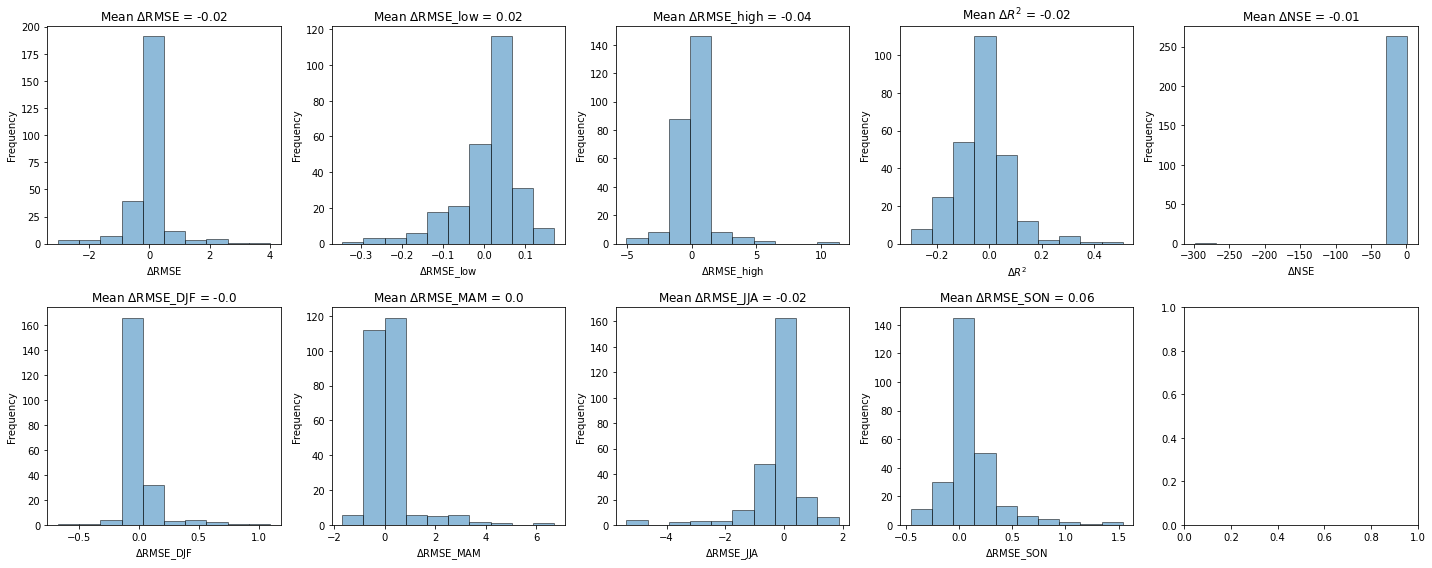

In [ ]:
dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2, 
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(dmetrics.keys()):

  xx = dmetrics[metric][full_stations]
  # if metric == '$\Delta$NSE':
  #   xx = xx[xx>-10]

  ax = axes.flatten()[kk]
  ax.hist(xx, edgecolor = 'k', alpha = 0.5)
  ax.set_xlabel(metric)
  ax.set_ylabel('Frequency')
  ax.set_title('Mean ' + metric + ' = ' + str(np.round(np.nanmedian(xx), decimals = 2)))

plt.tight_layout()

plt.show()

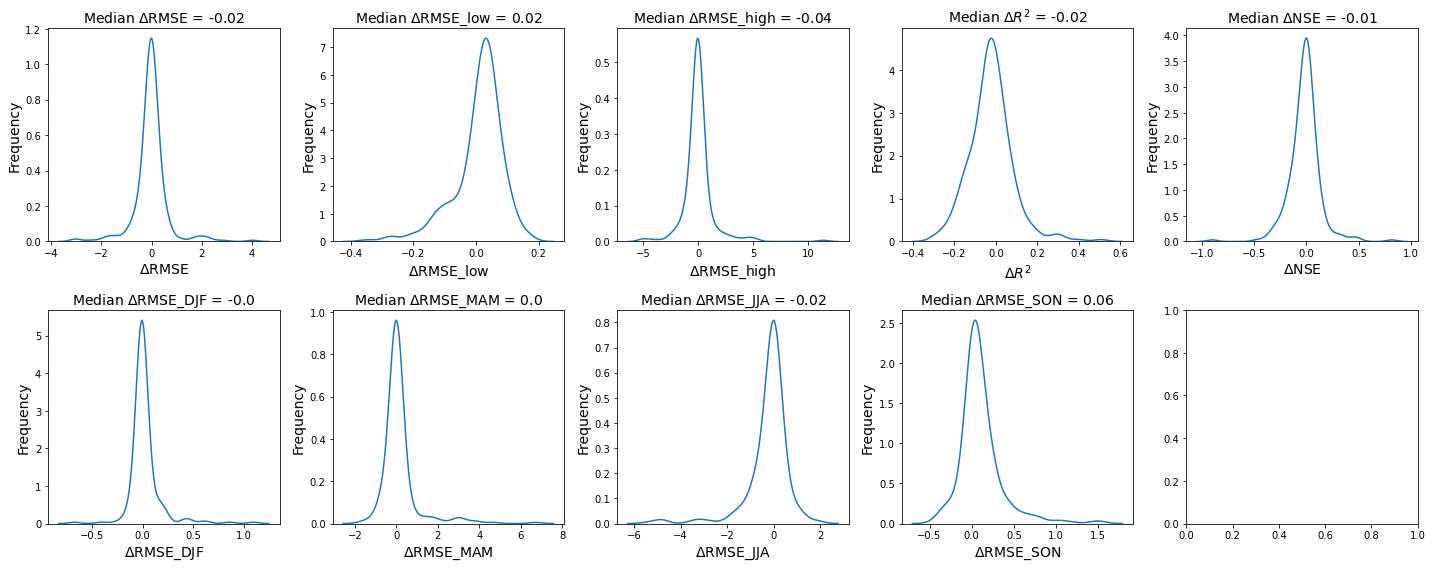

In [ ]:
dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2, 
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(dmetrics.keys()):

  xx = dmetrics[metric][full_stations]
  if metric == '$\Delta$NSE':
    xx = xx[xx>-10]

  ax = axes.flatten()[kk]
  sns.kdeplot(xx, ax = ax)#, edgecolor = 'k', alpha = 0.5)
  ax.set_xlabel(metric, fontsize = fs)
  ax.set_ylabel('Frequency', fontsize = fs)
  ax.set_title('Median ' + metric + ' = ' + str(np.round(np.nanmedian(xx), decimals = 2)), fontsize = fs)

plt.tight_layout()

plt.show()

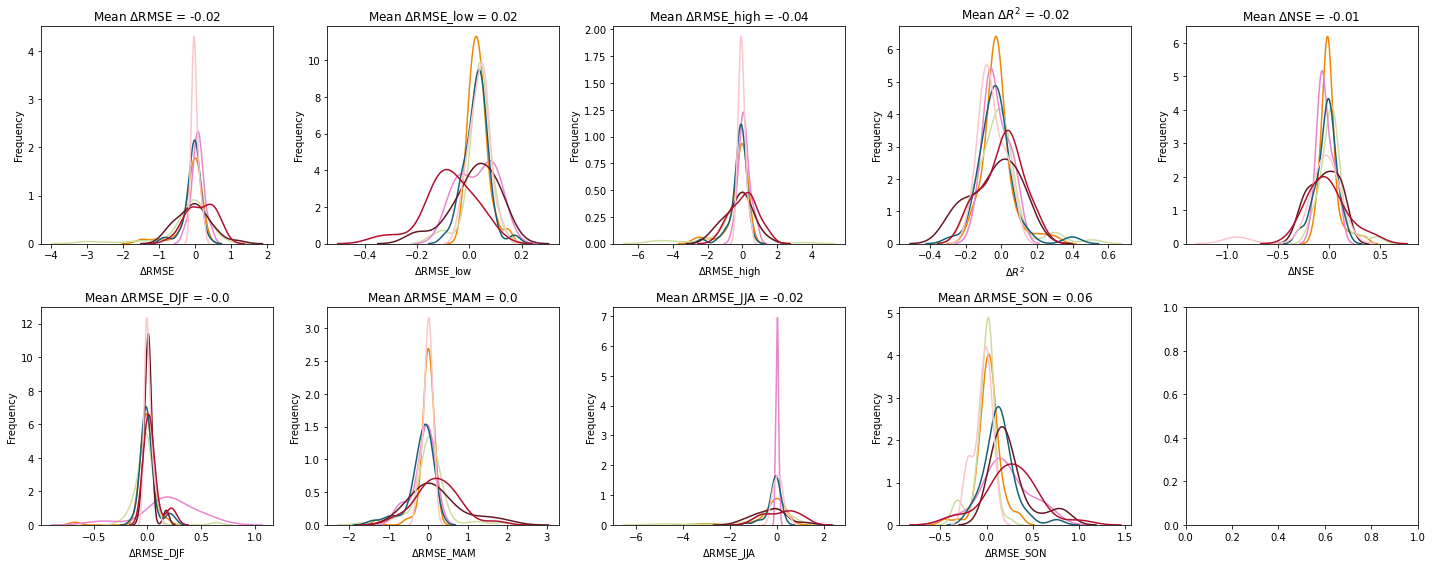

In [ ]:
#compare by cluster

dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2,
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(dmetrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster in range(n_clusters_seasonal):

  cluster_inds = np.squeeze(np.argwhere(labels == cluster))

  if cluster != 2:

    for kk, metric in enumerate(dmetrics.keys()):

      xx = dmetrics[metric][cluster_inds]

      if metric == '$\Delta$NSE':
        xx = xx[xx>-10]

      ax = axes.flatten()[kk]
      # ax.hist(xx, edgecolor = 'k', alpha = 0.5, facecolor = rgbas_array[cluster,:])
      sns.kdeplot(xx, color = rgbas_array[cluster,:], ax = ax)
      ax.set_xlabel(metric)
      ax.set_ylabel('Frequency')
      ax.set_title('Mean ' + metric + ' = ' + str(np.round(np.nanmedian(dmetrics[metric]), decimals = 2)))

      # if (metric == '$\Delta$RMSE_MAM') | (metric == '$\Delta$RMSE_JJA') | (metric == '$\Delta$RMSE_SON'):
      #   ax.set_xlim((-5,5))

plt.tight_layout()

plt.show()

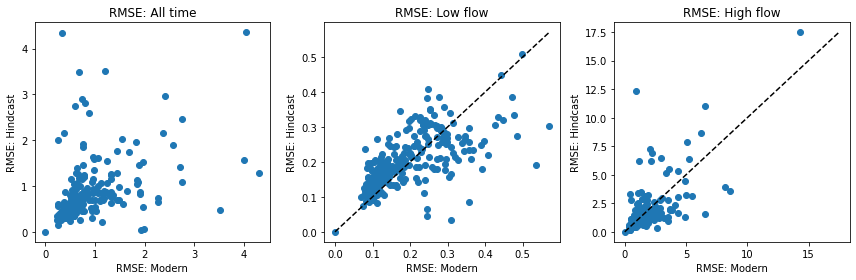

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

# RMSE: all flow

xx = RMSE_modern
yy = RMSE_hind

axes[0].scatter(xx, yy)
axes[0].plot([0,np.max([xx,yy])],[0,np.max([xx,yy])], 'k--')
axes[0].set_xlabel('RMSE: Modern')
axes[0].set_ylabel('RMSE: Hindcast')
axes[0].set_title('RMSE: All time')

# RMSE: low flow 

xx = RMSE_low_modern
yy = RMSE_low_hind

axes[1].scatter(xx, yy)
axes[1].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[1].set_xlabel('RMSE: Modern')
axes[1].set_ylabel('RMSE: Hindcast')
axes[1].set_title('RMSE: Low flow')

# RMSE: high flow

xx = RMSE_high_modern
yy = RMSE_high_hind

axes[2].scatter(xx, yy)
axes[2].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[2].set_xlabel('RMSE: Modern')
axes[2].set_ylabel('RMSE: Hindcast')
axes[2].set_title('RMSE: High flow')

plt.tight_layout()

plt.show()

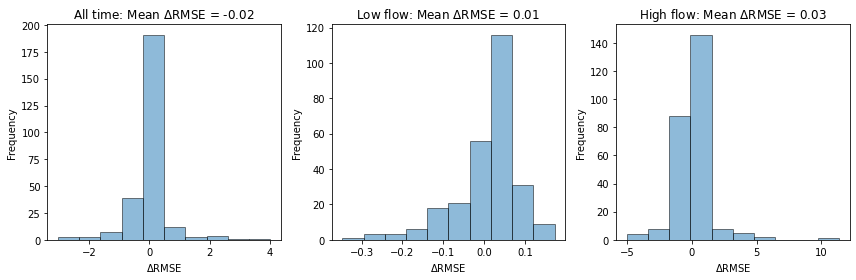

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

axes[0].hist(dRMSE, edgecolor = 'k', alpha = 0.5)
axes[0].set_xlabel('$\Delta$RMSE')
axes[0].set_ylabel('Frequency')
axes[0].set_title('All time: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE), decimals = 2)))

axes[1].hist(dRMSE_low, edgecolor = 'k', alpha = 0.5)
axes[1].set_xlabel('$\Delta$RMSE')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Low flow: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE_low), decimals = 2)))

axes[2].hist(dRMSE_high, edgecolor = 'k', alpha = 0.5)
axes[2].set_xlabel('$\Delta$RMSE')
axes[2].set_ylabel('Frequency')
axes[2].set_title('High flow: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE_high), decimals = 2)))

plt.tight_layout()

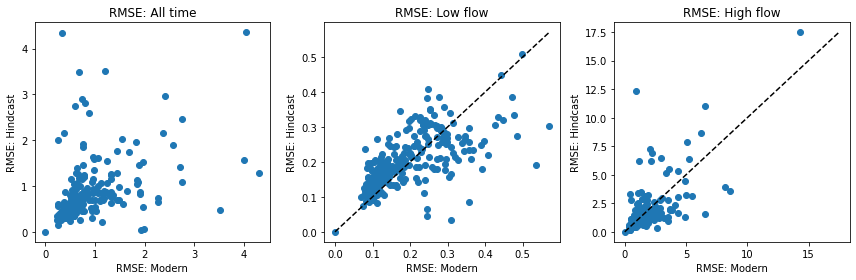

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

# RMSE: all flow

xx = RMSE_modern
yy = RMSE_hind

axes[0].scatter(xx, yy)
axes[0].plot([0,np.max([xx,yy])],[0,np.max([xx,yy])], 'k--')
axes[0].set_xlabel('RMSE: Modern')
axes[0].set_ylabel('RMSE: Hindcast')
axes[0].set_title('RMSE: All time')

# RMSE: low flow 

xx = RMSE_low_modern
yy = RMSE_low_hind

axes[1].scatter(xx, yy)
axes[1].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[1].set_xlabel('RMSE: Modern')
axes[1].set_ylabel('RMSE: Hindcast')
axes[1].set_title('RMSE: Low flow')

# RMSE: high flow

xx = RMSE_high_modern
yy = RMSE_high_hind

axes[2].scatter(xx, yy)
axes[2].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[2].set_xlabel('RMSE: Modern')
axes[2].set_ylabel('RMSE: Hindcast')
axes[2].set_title('RMSE: High flow')

plt.tight_layout()

plt.show()

# Check hydrological indices: glacierized stations

In [ ]:
#plan: evaluate set of indices over modern period as well as hind casted period -- see if they are substantially different
#goal: want stations where hindcast is not much different than modern

In [ ]:
# F_long = np.squeeze(flowDict_long['all_flow']).T

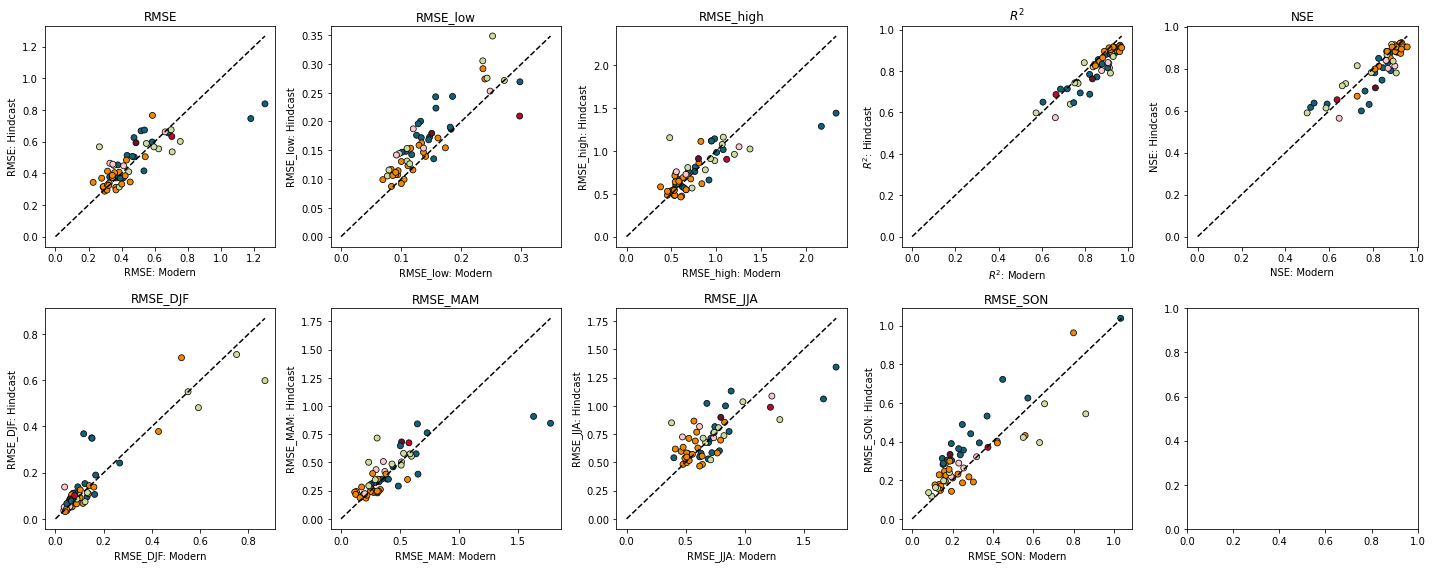

In [ ]:
metrics = {
    'RMSE': [RMSE_hind, RMSE_modern],
    'RMSE_low' : [RMSE_low_hind, RMSE_low_modern],
    'RMSE_high' : [RMSE_high_hind, RMSE_high_modern],
    '$R^2$' : [R2_hind, R2_modern],
    'NSE' : [NSE_hind, NSE_modern],
    'RMSE_DJF' : [RMSE_DJF_hind, RMSE_DJF_modern],
    'RMSE_MAM' : [RMSE_MAM_hind, RMSE_MAM_modern],
    'RMSE_JJA' : [RMSE_JJA_hind, RMSE_JJA_modern],
    'RMSE_SON' : [RMSE_SON_hind, RMSE_SON_modern]
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(metrics.keys()):

  xx = metrics[metric][1][full_glaciers]
  yy = metrics[metric][0][full_glaciers]

  ax = axes.flatten()[kk]

  if metric == 'NSE':
    xx = xx[yy>-10]
    yy = yy[yy>-10]
    ax.scatter(xx, yy, c = cStations[full_glaciers][np.squeeze(np.argwhere(yy>-10)),:], edgecolor = 'k', linewidth = 0.75)
  else:
    ax.scatter(xx, yy, c = cStations[full_glaciers], edgecolor = 'k', linewidth = 0.75)

  # ax.scatter(xx, yy, c = cStations)
  ax.plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
  ax.set_xlabel(metric + ': Modern')
  ax.set_ylabel(metric + ': Hindcast')
  ax.set_title(metric)

plt.tight_layout()

plt.show()

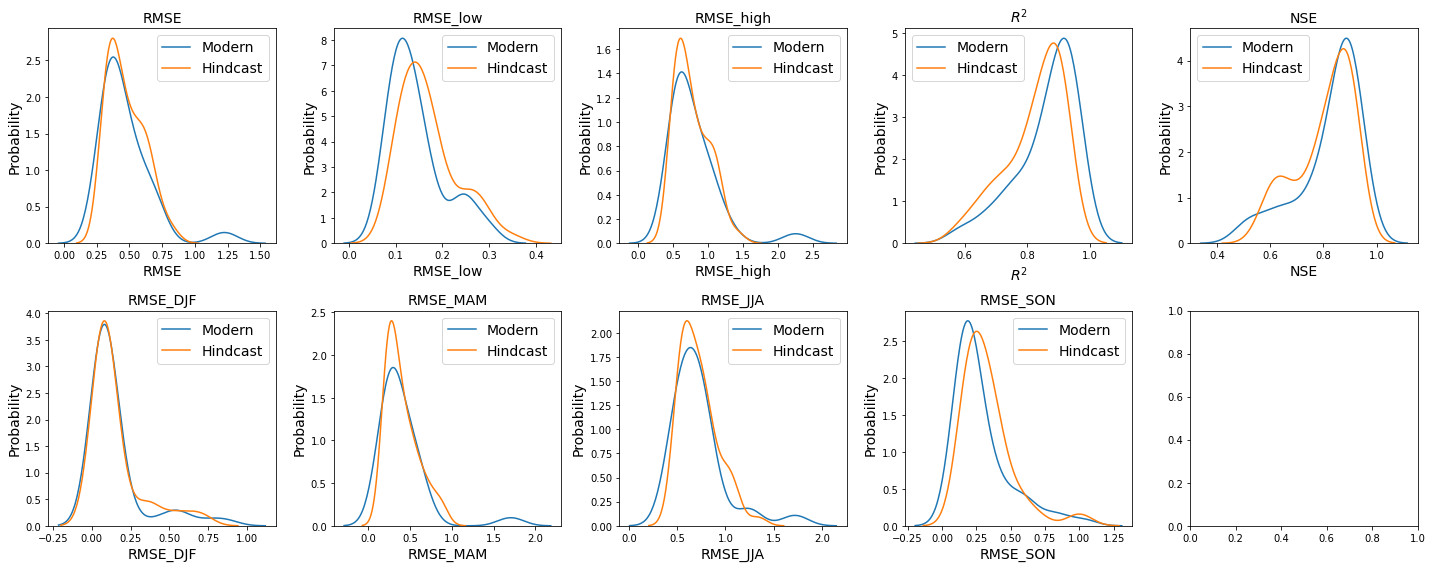

In [ ]:
saveIt = 0

metrics = {
    'RMSE': [RMSE_hind, RMSE_modern],
    'RMSE_low' : [RMSE_low_hind, RMSE_low_modern],
    'RMSE_high' : [RMSE_high_hind, RMSE_high_modern],
    '$R^2$' : [R2_hind, R2_modern],
    'NSE' : [NSE_hind, NSE_modern],
    'RMSE_DJF' : [RMSE_DJF_hind, RMSE_DJF_modern],
    'RMSE_MAM' : [RMSE_MAM_hind, RMSE_MAM_modern],
    'RMSE_JJA' : [RMSE_JJA_hind, RMSE_JJA_modern],
    'RMSE_SON' : [RMSE_SON_hind, RMSE_SON_modern]
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(metrics.keys()):

  xx = metrics[metric][1][full_glaciers]
  yy = metrics[metric][0][full_glaciers]

  ax = axes.flatten()[kk]

  # if metric == 'NSE':
  #   xx = xx[yy>-10]
  #   yy = yy[yy>-10]
  #   ax.scatter(xx, yy, c = cStations[full_stations][np.squeeze(np.argwhere(yy>-10)),:], edgecolor = 'k', linewidth = 0.75)
  # else:
  #   ax.scatter(xx, yy, c = cStations[full_stations], edgecolor = 'k', linewidth = 0.75)

  sns.kdeplot(xx, ax = ax, label = 'Modern')
  sns.kdeplot(yy, ax = ax, label = 'Hindcast')

  # ax.scatter(xx, yy, c = cStations)
  # ax.plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
  ax.set_xlabel(metric, fontsize = fs)
  ax.set_ylabel('Probability', fontsize = fs)
  ax.set_title(metric, fontsize = fs)
  # ax.set_xlim((0,2))
  ax.legend(fontsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('metric_hind_mod_glaciers_compare.png', bbox_inches = 'tight', dpi = 300)

plt.show()

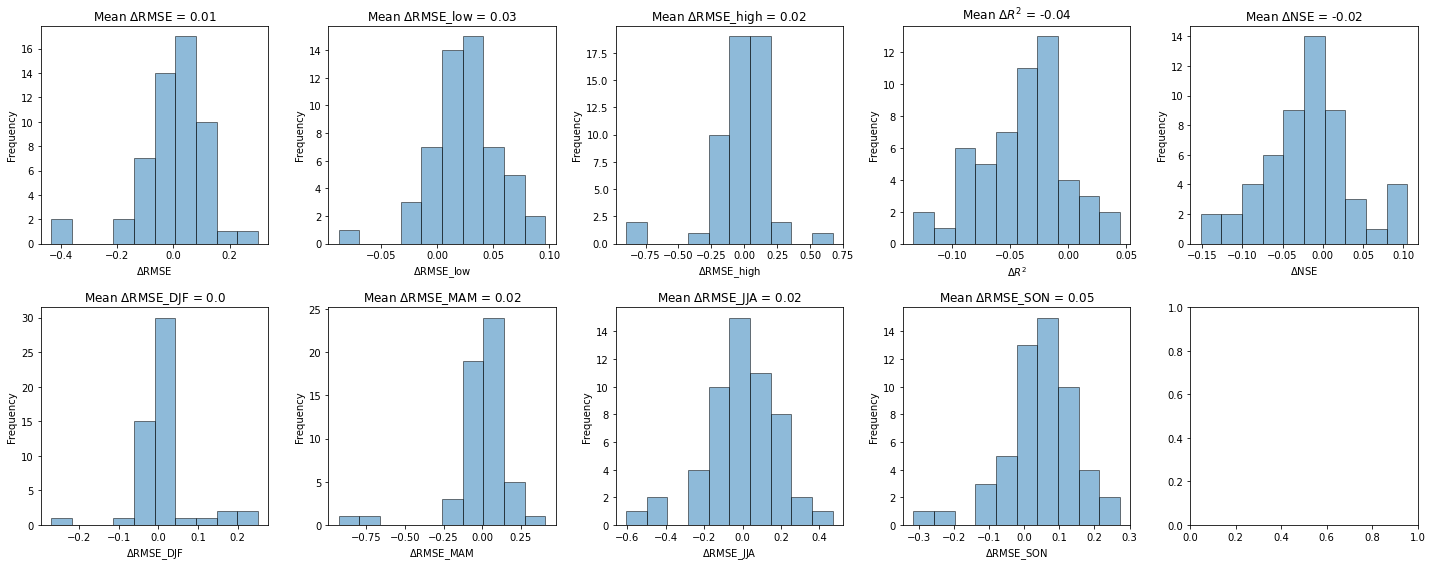

In [ ]:
dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2, 
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(dmetrics.keys()):

  xx = dmetrics[metric][full_glaciers]
  # if metric == '$\Delta$NSE':
  #   xx = xx[xx>-10]

  ax = axes.flatten()[kk]
  ax.hist(xx, edgecolor = 'k', alpha = 0.5)
  ax.set_xlabel(metric)
  ax.set_ylabel('Frequency')
  ax.set_title('Mean ' + metric + ' = ' + str(np.round(np.nanmedian(xx), decimals = 2)))

plt.tight_layout()

plt.show()

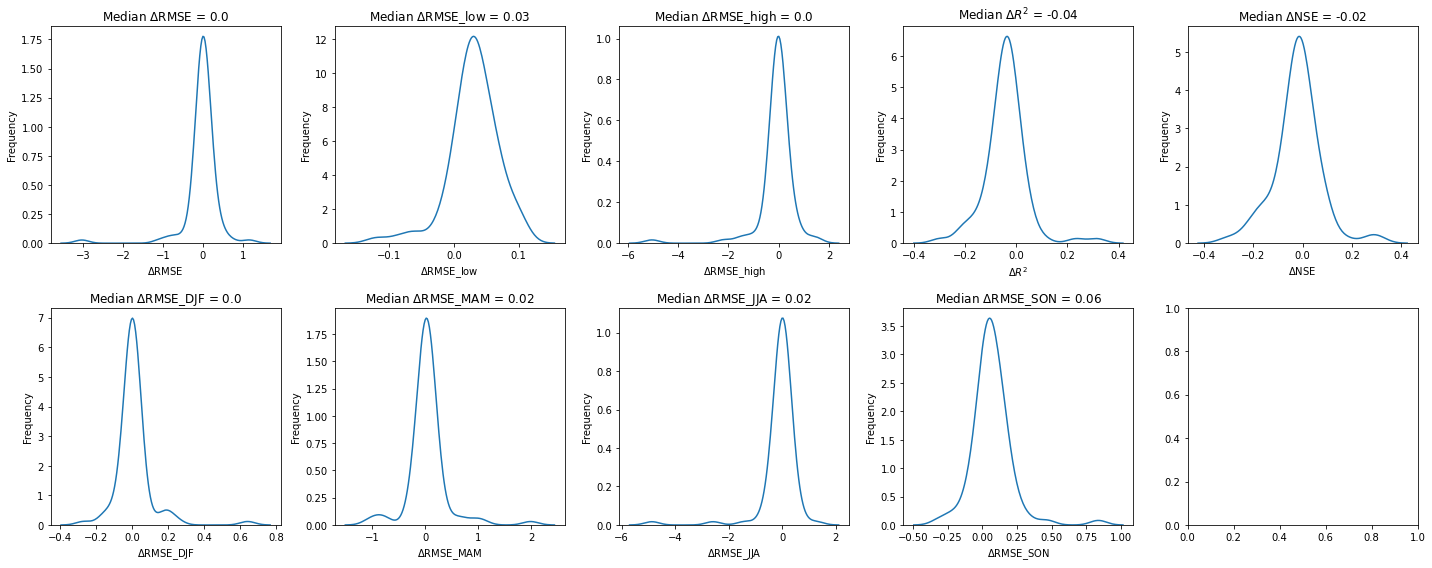

In [ ]:
dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2, 
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(metrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for kk, metric in enumerate(dmetrics.keys()):

  xx = dmetrics[metric][full_stations]
  if metric == '$\Delta$NSE':
    xx = xx[xx>-10]

  ax = axes.flatten()[kk]
  sns.kdeplot(xx, ax = ax)#, edgecolor = 'k', alpha = 0.5)
  ax.set_xlabel(metric)
  ax.set_ylabel('Frequency')
  ax.set_title('Median ' + metric + ' = ' + str(np.round(np.nanmedian(xx), decimals = 2)))

plt.tight_layout()

plt.show()

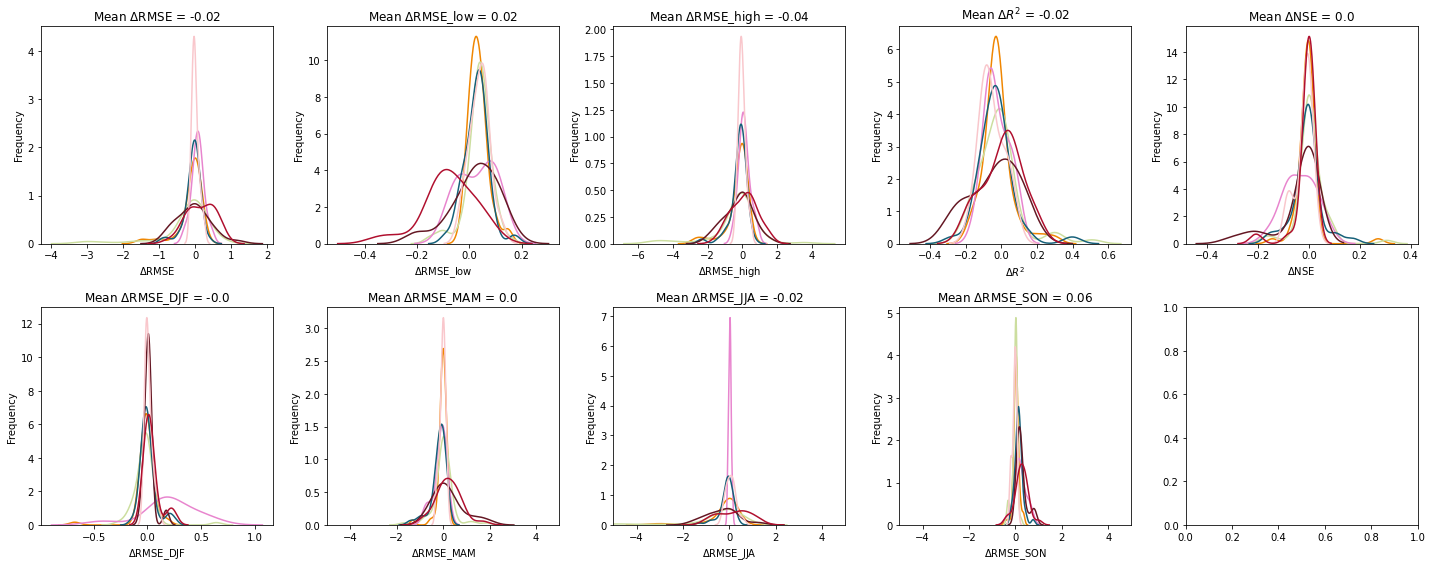

In [ ]:
#compare by cluster

dmetrics = {
    '$\Delta$RMSE': dRMSE,
    '$\Delta$RMSE_low' : dRMSE_low,
    '$\Delta$RMSE_high' : dRMSE_high,
    '$\Delta R^2$' : dR2,
    '$\Delta$NSE' : dNSE,
    '$\Delta$RMSE_DJF' : dRMSE_DJF,
    '$\Delta$RMSE_MAM' : dRMSE_MAM,
    '$\Delta$RMSE_JJA' : dRMSE_JJA,
    '$\Delta$RMSE_SON' : dRMSE_SON
}

nrows = 2
ncols = int(np.ceil(len(dmetrics) / 2))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster in range(n_clusters_seasonal):

  cluster_inds = np.squeeze(np.argwhere(labels == cluster))

  if cluster != 2:

    for kk, metric in enumerate(dmetrics.keys()):

      xx = dmetrics[metric][cluster_inds]

      if metric == '$\Delta$NSE':
        xx = xx[xx>-10]

      ax = axes.flatten()[kk]
      # ax.hist(xx, edgecolor = 'k', alpha = 0.5, facecolor = rgbas_array[cluster,:])
      sns.kdeplot(xx, color = rgbas_array[cluster,:], ax = ax)
      ax.set_xlabel(metric)
      ax.set_ylabel('Frequency')
      ax.set_title('Mean ' + metric + ' = ' + str(np.round(np.nanmedian(dmetrics[metric]), decimals = 2)))

      if (metric == '$\Delta$RMSE_MAM') | (metric == '$\Delta$RMSE_JJA') | (metric == '$\Delta$RMSE_SON'):
        ax.set_xlim((-5,5))

plt.tight_layout()

plt.show()

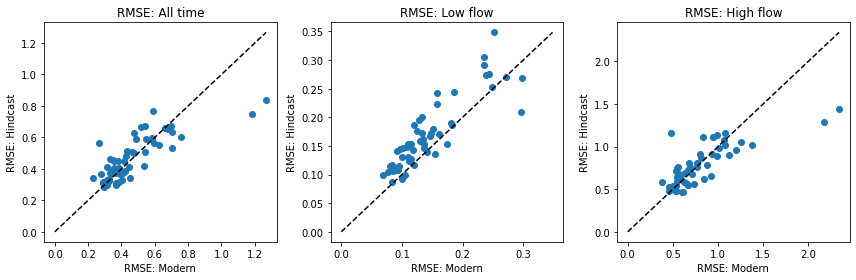

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

# RMSE: all flow

xx = RMSE_modern[full_glaciers]
yy = RMSE_hind[full_glaciers]

axes[0].scatter(xx, yy)
axes[0].plot([0,np.max([xx,yy])],[0,np.max([xx,yy])], 'k--')
axes[0].set_xlabel('RMSE: Modern')
axes[0].set_ylabel('RMSE: Hindcast')
axes[0].set_title('RMSE: All time')

# RMSE: low flow 

xx = RMSE_low_modern[full_glaciers]
yy = RMSE_low_hind[full_glaciers]

axes[1].scatter(xx, yy)
axes[1].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[1].set_xlabel('RMSE: Modern')
axes[1].set_ylabel('RMSE: Hindcast')
axes[1].set_title('RMSE: Low flow')

# RMSE: high flow

xx = RMSE_high_modern[full_glaciers]
yy = RMSE_high_hind[full_glaciers]

axes[2].scatter(xx, yy)
axes[2].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[2].set_xlabel('RMSE: Modern')
axes[2].set_ylabel('RMSE: Hindcast')
axes[2].set_title('RMSE: High flow')

plt.tight_layout()

plt.show()

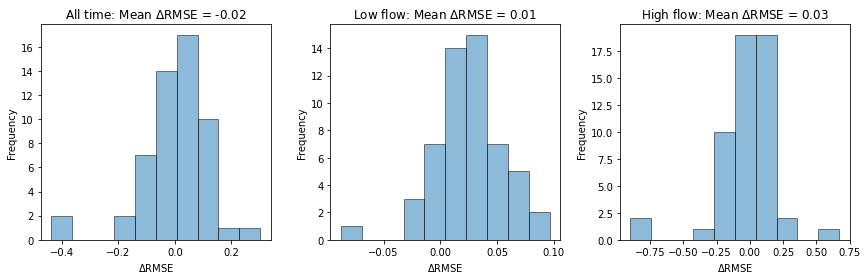

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

axes[0].hist(dRMSE[full_glaciers], edgecolor = 'k', alpha = 0.5)
axes[0].set_xlabel('$\Delta$RMSE')
axes[0].set_ylabel('Frequency')
axes[0].set_title('All time: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE), decimals = 2)))

axes[1].hist(dRMSE_low[full_glaciers], edgecolor = 'k', alpha = 0.5)
axes[1].set_xlabel('$\Delta$RMSE')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Low flow: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE_low), decimals = 2)))

axes[2].hist(dRMSE_high[full_glaciers], edgecolor = 'k', alpha = 0.5)
axes[2].set_xlabel('$\Delta$RMSE')
axes[2].set_ylabel('Frequency')
axes[2].set_title('High flow: Mean $\Delta$RMSE = ' + str(np.round(np.nanmean(dRMSE_high), decimals = 2)))

plt.tight_layout()

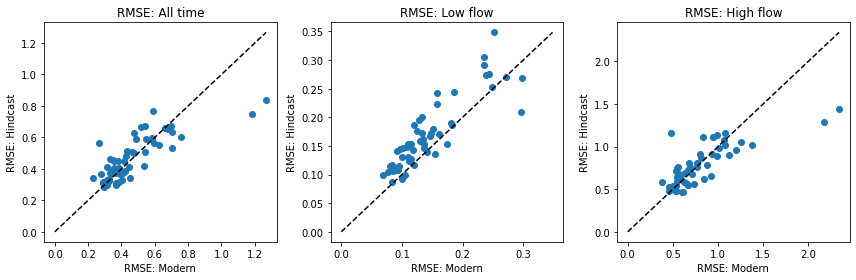

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

# RMSE: all flow

xx = RMSE_modern[full_glaciers]
yy = RMSE_hind[full_glaciers]

axes[0].scatter(xx, yy)
axes[0].plot([0,np.max([xx,yy])],[0,np.max([xx,yy])], 'k--')
axes[0].set_xlabel('RMSE: Modern')
axes[0].set_ylabel('RMSE: Hindcast')
axes[0].set_title('RMSE: All time')

# RMSE: low flow 

xx = RMSE_low_modern[full_glaciers]
yy = RMSE_low_hind[full_glaciers]

axes[1].scatter(xx, yy)
axes[1].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[1].set_xlabel('RMSE: Modern')
axes[1].set_ylabel('RMSE: Hindcast')
axes[1].set_title('RMSE: Low flow')

# RMSE: high flow

xx = RMSE_high_modern[full_glaciers]
yy = RMSE_high_hind[full_glaciers]

axes[2].scatter(xx, yy)
axes[2].plot([0,np.nanmax([xx,yy])],[0,np.nanmax([xx,yy])], 'k--')
axes[2].set_xlabel('RMSE: Modern')
axes[2].set_ylabel('RMSE: Hindcast')
axes[2].set_title('RMSE: High flow')

plt.tight_layout()

plt.show()

# Compare decadal-scale changes to seasonal

In [52]:
#select just the same stations in long-term observations as those in modern period
stations = range(len(stationInds))
stationInds_long = np.empty(len(stationInds), dtype = int)
for station in stations:
  stationName = stationNames[station]
  # print(np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long])))
  stationInds_long[station] = int(np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long])))

F_long = F_long[:,stationInds_long]

#normalize flow observations
F_long_norm = np.zeros(np.shape(F_long))
for station in range(len(stationInds)):
  F_long_norm[:,station] = (F_long[:,station] - Fmean[station]) / Fstd[station]

In [53]:
#MODEL: calculate seasonal flow (365-day long flows of each year, starting on Jan 1)

y_all_predict = np.vstack([y_hind_predict, y_modern_predict])
date_all = np.vstack([np.reshape(eraDate_hind, (-1,1)), np.reshape(eraDate_modern, (-1,1))])

delta = timedelta(days = 364)
year_start = 1951
year_fin = 2015
year_fin = 2020
year_fin = 2018

f_seasonal = np.zeros((365, len(stationInds)))
f_seasonal_yearly = np.zeros((365, len(stationInds), len(range(year_start, year_fin))))

kk = 0
for nn, year in enumerate(range(year_start, year_fin+1)):
  
  if year != 1979:

    start_date = datetime(year, 1, 1)
    fin_date = start_date + delta

    start_ind = np.argwhere(date_all==start_date)[0][0]
    fin_ind = np.argwhere(date_all==fin_date)[0][0]

    f = y_all_predict[start_ind:fin_ind+1,:]

    if (year==year_fin) and (np.mod(year_fin,4)==0): #if last year missing final day -- fill in with second last day
      f_new = np.zeros((365,265))
      f_new[:-1,:] = f
      f_new[-1,:] = f_new[-2,:]
      f = f_new

    # f_seasonal += f
    f_seasonal_yearly[:,:,kk] = f

    kk+=1

#calculate early period vs modern period seasonal flow of each cluster
seasonal_early = np.mean(f_seasonal_yearly[:,:,:35], axis = -1)
seasonal_modern = np.mean(f_seasonal_yearly[:,:,-35:], axis = -1)

seasonal_early_clusters = np.zeros((365,n_clusters_seasonal))
seasonal_modern_clusters = np.zeros((365,n_clusters_seasonal))

for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(labels==cluster))
  inds = np.intersect1d(full_stations, inds)
  seasonal_early_clusters[:,cluster] = np.mean(seasonal_early[:,inds], axis = -1)
  seasonal_modern_clusters[:,cluster] = np.mean(seasonal_modern[:,inds], axis = -1)


##########


#OBSERVATION: calculate seasonal flow (365-day long flows of each year, starting on Jan 1)

date_all = np.asarray(flowDate_long)
delta = timedelta(days = 364)
year_start = 1951
year_fin = 2020
year_fin = 2018

f_seasonal_obs = np.zeros((365, len(stationInds)))
f_seasonal_yearly_obs = np.zeros((365, len(stationInds), len(range(year_start, year_fin))))
missing_data = np.zeros((365, len(stationInds), len(range(year_start, year_fin))))

kk = 0
for nn, year in enumerate(range(year_start, year_fin+1)):
  
  if year != 1979:

    start_date = datetime(year, 1, 1)
    fin_date = start_date + delta

    start_ind = np.argwhere(date_all==start_date)[0][0]
    fin_ind = np.argwhere(date_all==fin_date)[0][0]

    f = F_long_norm[start_ind:fin_ind+1,:]

    f_seasonal_yearly_obs[:,:,kk] = f

    for missing_index in np.argwhere(np.isnan(f)):
      missing_data[missing_index[0], missing_index[1], kk] = 1

    kk+=1


seasonal_early_obs = np.nanmean(f_seasonal_yearly_obs[:,:,:35], axis = -1)
seasonal_modern_obs = np.nanmean(f_seasonal_yearly_obs[:,:,-35:], axis = -1)

seasonal_early_obs_clusters = np.zeros((365,n_clusters_seasonal))
seasonal_modern_obs_clusters = np.zeros((365,n_clusters_seasonal))

for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(labels==cluster))
  inds = np.intersect1d(full_stations, inds)
  seasonal_early_obs_clusters[:,cluster] = np.nanmean(seasonal_early_obs[:,inds], axis = -1)
  seasonal_modern_obs_clusters[:,cluster] = np.nanmean(seasonal_modern_obs[:,inds], axis = -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice


In [202]:
# del f_seasonal_yearly, f_seasonal_yearly_obs, f_seasonal, f_seasonal_obs

In [54]:
#smooth over subsequent years
N_years_window = 21
N_days_window = 31

kernel = np.ones(N_years_window) / N_years_window
start_year0 = 1951
start_year = np.copy(start_year0)
fin_year = start_year + N_years_window
extent = [0,364,2016.5 - N_years_window, 1950.5]
extent = [0, 364, 2015.5, 1950.5]

# Nyears = 48

# seasonal_window = np.zeros((365, len(stationInds), 67 - N_years_window + 1 - (start_year0 - 1951)))
# seasonal_window_obs = np.zeros((365, len(stationInds), 67 - N_years_window + 1 - (start_year0 - 1951)))
# missing_window = np.zeros((365, len(stationInds), 67 - N_years_window + 1 - (start_year0 - 1951)))

Ndays = 365
# Ndays -= (N_days_window-1)

Nstations = len(stationInds)

Nyears = len(np.arange(1951,2018))
# Nyears -= (N_years_window-1)

seasonal_window = np.zeros((Ndays, Nstations, Nyears))
seasonal_window_obs = np.zeros((Ndays, Nstations, Nyears))
missing_window = np.zeros((Ndays, Nstations, Nyears))

for day in range(Ndays): #for each day of the year, smooth over mutliple adjacent years
  for station in range(Nstations):
    
    xx = f_seasonal_yearly[day, station, :]
    xx = np.pad(xx,10, mode = 'edge')
    # seasonal_window[day, station, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()
    seasonal_window[day, station, :] = np.convolve(xx, kernel, mode = 'valid')

    xx = f_seasonal_yearly_obs[day, station, :]
    xx = np.pad(xx,10, mode = 'edge')
    # seasonal_window_obs[day, station, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()
    seasonal_window_obs[day, station, :] = np.convolve(xx, kernel, mode = 'valid')

    # xx = missing_data[day, station, :]
    # missing_window[day, station, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).sum()

In [99]:
#calculate anomalies (deviations from seasonal each day) and noramlized anomalies (deviations normalized by standard deviation of that day)

kernel = np.ones(N_days_window) / N_days_window

seasonal_window_anomaly = np.zeros(np.shape(seasonal_window))
seasonal_window_anomaly_obs = np.zeros(np.shape(seasonal_window_obs))

seasonal_window_anomaly_norm = np.zeros(np.shape(seasonal_window))
seasonal_window_anomaly_norm_obs = np.zeros(np.shape(seasonal_window_obs))

for station in range(len(stationInds)): #for each station
  
  seasonal = np.expand_dims(np.nanmean(seasonal_window[:,station,:], axis = -1), axis = -1) #seasonal average across all years
  seasonal_window_anomaly[:,station,:] = seasonal_window[:,station,:] - seasonal #deviations of each day from seasonal average

  seasonal_obs = np.expand_dims(np.nanmean(seasonal_window_obs[:,station,:], axis = -1), axis = -1) #seasonal average across all years
  seasonal_window_anomaly_obs[:,station,:] = seasonal_window_obs[:,station,:] - seasonal_obs #deviations of each day from seasonal average

  for year in range(len(seasonal_window_obs[0,0,:])): #for each year, smooth over subsequent days

    # seasonal_window_anomaly[:,station,year] = pd.Series(seasonal_window_anomaly[:,station,year]).rolling(window = 30, min_periods = 1).mean() 
    # seasonal_window_anomaly_obs[:,station,year] = pd.Series(seasonal_window_anomaly_obs[:,station,year]).rolling(window = 30, min_periods = 1).mean()

    xx = seasonal_window_anomaly[:,station,year]
    xx = np.pad(xx,15, mode = 'edge')
    a = xx
    seasonal_window_anomaly[:,station,year] = np.convolve(xx, kernel, mode = 'valid')

    xx = seasonal_window_anomaly_obs[:,station,year]
    xx = np.pad(xx,15, mode = 'edge')
    seasonal_window_anomaly_obs[:,station,year] = np.convolve(xx, kernel, mode = 'valid')

    # seasonal_window[:,station,year] = pd.Series(seasonal_window[:,station,year]).rolling(window = 30, min_periods = 1).mean()
    # seasonal_window_obs[:,station,year] = pd.Series(seasonal_window_obs[:,station,year]).rolling(window = 30, min_periods = 1).mean()

    xx = seasonal_window[:,station,year]
    xx = np.pad(xx,15, mode = 'edge')
    seasonal_window[:,station,year] = np.convolve(xx, kernel, mode = 'valid')

    xx = seasonal_window_obs[:,station,year]
    xx = np.pad(xx,15, mode = 'edge')
    seasonal_window_obs[:,station,year] = np.convolve(xx, kernel, mode = 'valid')

  # std = np.expand_dims(np.std(seasonal_window[:,station,:], axis = -1), axis = -1) #standard deviation across all years at each day
  std = np.expand_dims(np.std(seasonal_window_anomaly[:,station,:], axis = -1), axis = -1) #standard deviation across all years at each day
  seasonal_window_anomaly_norm[:,station,:] = seasonal_window_anomaly[:,station,:] / std #normalize anomaly by stddev ('how substantial is this anomaly?')

  # std = np.expand_dims(np.nanstd(seasonal_window_obs[:,station,:], axis = -1), axis = -1)
  std = np.expand_dims(np.nanstd(seasonal_window_anomaly_obs[:,station,:], axis = -1), axis = -1)
  seasonal_window_anomaly_norm_obs[:,station,:] = seasonal_window_anomaly_obs[:,station,:] / std

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


In [253]:
seasonal_clustering.labels_[63], stationNames[63]

(0, ' MOFFAT CREEK NEAR HORSEFLY')

In [205]:
# seasonal_window_anomaly = seasonal_window_anomaly[15:-15,:,10:-10]
# seasonal_window_anomaly_norm = seasonal_window_anomaly_norm[15:-15,:,10:-10]

# seasonal_window_anomaly_obs = seasonal_window_anomaly_obs[15:-15,:,10:-10]
# seasonal_window_anomaly_norm_obs = seasonal_window_anomaly_norm_obs[15:-15,:,10:-10]

# seasonal_window_obs = seasonal_window_obs[15:-15,:,10:-10]
# # seasonal_window_norm_obs = seasonal_window_norm_obs[15:-15,:,10:-10]

# seasonal_window = seasonal_window[15:-15,:,10:-10]
# # seasonal_window_norm = seasonal_window_norm[15:-15,:,10:-10]

In [102]:
#calculate average patterns by cluster

Ndays = 365
# Ndays -= (N_days_window)

Nstations = len(stationInds)

Nyears = len(np.arange(1951,2018))
# Nyears -= (N_years_window)

#initialize
seasonal_window_obs_clusters = np.zeros((Ndays, n_clusters_seasonal, Nyears))
seasonal_window_clusters = np.zeros((Ndays, n_clusters_seasonal, Nyears))
missing_window_clusters = np.zeros((Ndays, n_clusters_seasonal, Nyears))
missing_window_clusters_norm = np.zeros((Ndays, n_clusters_seasonal, Nyears))

seasonal_window_anomaly_obs_clusters = np.zeros((Ndays, n_clusters_seasonal, Nyears))
seasonal_window_anomaly_clusters = np.zeros((Ndays, n_clusters_seasonal, Nyears))

seasonal_window_anomaly_norm_obs_clusters = np.zeros((Ndays, n_clusters_seasonal, Nyears))
seasonal_window_anomaly_norm_clusters = np.zeros((Ndays, n_clusters_seasonal, Nyears))

for cluster in range(n_clusters_seasonal): #for each cluster

  inds = np.squeeze(np.argwhere(labels==cluster))
  inds = np.intersect1d(full_stations, inds)

  seasonal_window_obs_clusters[:,cluster,:] = np.nanmean(seasonal_window_obs[:,inds,:], axis = 1)
  seasonal_window_clusters[:,cluster,:] = np.mean(seasonal_window[:,inds,:], axis = 1)

  seasonal_window_anomaly_obs_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly_obs[:,inds,:], axis = 1)
  seasonal_window_anomaly_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly[:,inds,:], axis = 1)

  seasonal_window_anomaly_norm_obs_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly_norm_obs[:,inds,:], axis = 1)
  seasonal_window_anomaly_norm_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly_norm[:,inds,:], axis = 1)

  # missing_window_clusters[:,cluster,:] = np.sum(missing_window[:,inds,:], axis = 1)
  # missing_window_clusters_norm[:,cluster,:] = np.copy(missing_window_clusters[:,cluster,:]) / (len(inds) * N_years_window)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


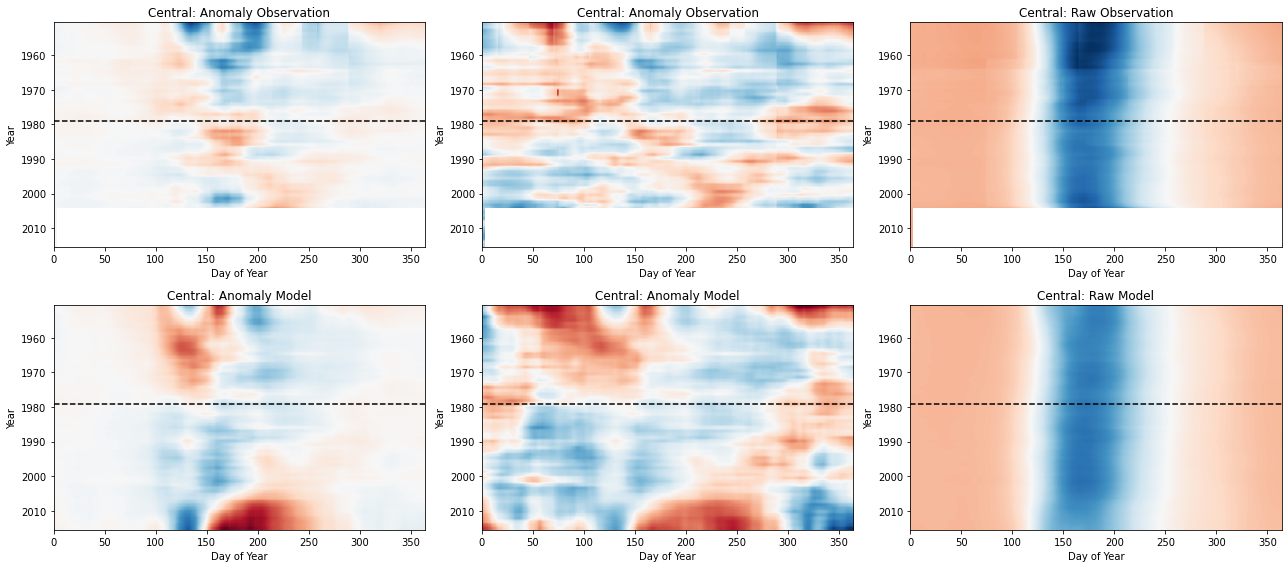

In [103]:
#visualize results by cluster

saveIt = 0

cluster = 5

xx = seasonal_window_anomaly_clusters[:,cluster,:].T
xx_obs = seasonal_window_anomaly_obs_clusters[:,cluster,:].T

xx_norm = seasonal_window_anomaly_norm_clusters[:,cluster,:].T
xx_norm_obs = seasonal_window_anomaly_norm_obs_clusters[:,cluster,:].T
xx_norm_obs[np.isinf(xx_norm_obs)] = 0

xx_raw = seasonal_window_clusters[:,cluster,:].T
xx_raw_obs = seasonal_window_obs_clusters[:,cluster,:].T

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18,8))

#observed anomaly
vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
im = axes[0][0].imshow(xx_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][0].plot(range(365), 1979*np.ones(365), 'k--')
# cb = plt.colorbar(im)
axes[0][0].set_title(cluster_names[cluster] + ': Anomaly Observation')
axes[0][0].set_xlabel('Day of Year')
axes[0][0].set_ylabel('Year')

#observed normalized anomaly
vmax = np.nanmax([np.abs(xx_norm), np.abs(xx_norm_obs)])
vmin = - vmax 
im = axes[0][1].imshow(xx_norm_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][1].plot(range(365), 1979*np.ones(365), 'k--')
# cb = plt.colorbar(im)
axes[0][1].set_title(cluster_names[cluster] + ': Anomaly Observation')
axes[0][1].set_xlabel('Day of Year')
axes[0][1].set_ylabel('Year')

#observed flow
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[0][2].imshow(xx_raw_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][2].plot(range(365), 1979*np.ones(365), 'k--')
# plt.colorbar()
axes[0][2].set_title(cluster_names[cluster] + ': Raw Observation')
axes[0][2].set_xlabel('Day of Year')
axes[0][2].set_ylabel('Year')

#model anomaly
vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
im = axes[1][0].imshow(xx, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[1][0].plot(range(365), 1979*np.ones(365), 'k--')
# plt.colorbar()
axes[1][0].set_title(cluster_names[cluster] + ': Anomaly Model')
axes[1][0].set_xlabel('Day of Year')
axes[1][0].set_ylabel('Year')

#model normalized anomaly
vmax = np.nanmax([np.abs(xx_norm), np.abs(xx_norm_obs)])
vmin = - vmax 
im = axes[1][1].imshow(xx_norm, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[1][1].plot(range(365), 1979*np.ones(365), 'k--')
# plt.colorbar()
axes[1][1].set_title(cluster_names[cluster] + ': Anomaly Model')
axes[1][1].set_xlabel('Day of Year')
axes[1][1].set_ylabel('Year')

#model normalized anomaly
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[1][2].imshow(xx_raw, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[1][2].plot(range(365), 1979*np.ones(365), 'k--')
# plt.colorbar()
axes[1][2].set_title(cluster_names[cluster] + ': Raw Model')
axes[1][2].set_xlabel('Day of Year')
axes[1][2].set_ylabel('Year')

# #plot missing data contours
# levels = np.arange(0.1,1.1,0.2)
# contour = axes[0,0].contour(missing_window_clusters_norm[:,cluster,:].T, levels = levels, colors = 'k', extent = extent)
# ax.clabel(contour, inline = True, fontsize = 10)
# contour = axes[0,1].contour(missing_window_clusters_norm[:,cluster,:].T, levels = levels, colors = 'k', extent = extent)
# ax.clabel(contour, inline = True, fontsize = 10)

plt.tight_layout()

if saveIt:
  plt.savefig('mod_obs_anomaly_clusters.png', bbox_inches = 'tight', dpi = 300)

plt.show()

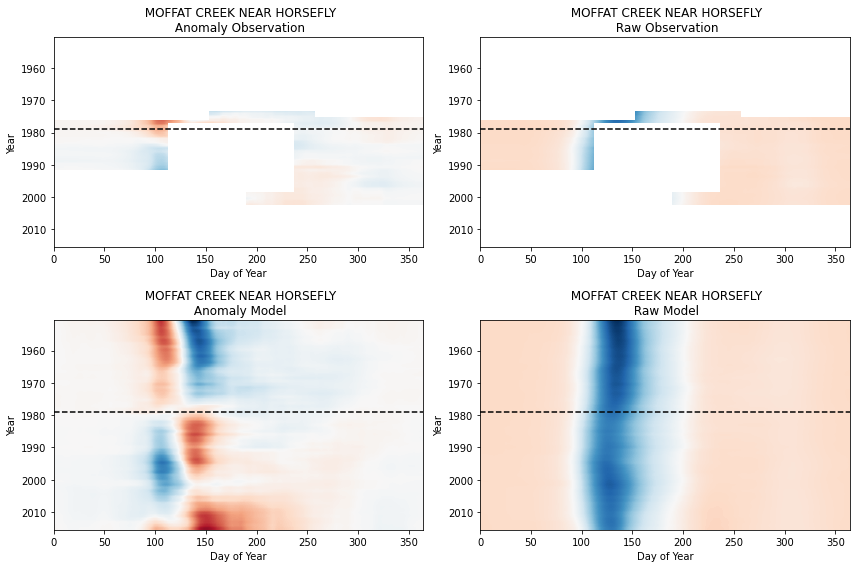

In [105]:
#visualize results by station

saveIt = 0

station = 157
station = 63

xx = seasonal_window_anomaly[:,station,:].T
xx_obs = seasonal_window_anomaly_obs[:,station,:].T

xx_raw = seasonal_window[:,station,:].T
xx_raw_obs = seasonal_window_obs[:,station,:].T


#mask
# xx_obs[missing_window_clusters_norm[:,cluster,:].T > 0.2] = np.nan
# xx_raw_obs[missing_window_clusters_norm[:,cluster,:].T > 0.2] = np.nan
# xx[missing_window_clusters_norm[:,cluster,:].T > 0.5] = np.nan
# xx_raw[missing_window_clusters_norm[:,cluster,:].T > 0.5] = np.nan

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

#observation: anomaly
vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
im = axes[0][0].imshow(xx_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][0].plot(range(365), 1979*np.ones(365), 'k--')
axes[0][0].set_title(stationNames[stationInds][station] + '\n Anomaly Observation')
axes[0][0].set_xlabel('Day of Year')
axes[0][0].set_ylabel('Year')

#observation: raw flow
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[0][1].imshow(xx_raw_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][1].plot(range(365), 1979*np.ones(365), 'k--')
axes[0][1].set_title(stationNames[stationInds][station] + '\n Raw Observation')
axes[0][1].set_xlabel('Day of Year')
axes[0][1].set_ylabel('Year')

#model: anomaly
vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
im = axes[1][0].imshow(xx, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax, extent = extent)
axes[1][0].plot(range(365), 1979*np.ones(365), 'k--')
axes[1][0].set_title(stationNames[stationInds][station] + '\n Anomaly Model')
axes[1][0].set_xlabel('Day of Year')
axes[1][0].set_ylabel('Year')

#model: raw flow
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[1][1].imshow(xx_raw, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax, extent = extent)
axes[1][1].plot(range(365), 1979*np.ones(365), 'k--')
axes[1][1].set_title(stationNames[stationInds][station] + '\n Raw Model')
axes[1][1].set_xlabel('Day of Year')
axes[1][1].set_ylabel('Year')

plt.tight_layout()

if saveIt:
  plt.savefig('mod_obs_anomaly_stations.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [114]:
#fill missing observations with model output, do PCA

seed = 99
np.random.seed(seed)

good_cluster_inds = np.argwhere(labels>=0)
good_cluster_inds = np.argwhere((labels==0)|(labels==1)|(labels==5))

good_cluster_inds = np.argwhere( ((labels==0)|(labels==1)|(labels==5)) & (NSE_modern>=0.7))

# good_cluster_inds = np.argwhere( ((labels==0)|(labels==1)|(labels==5)|(labels==2)|(labels==3)|(labels==4)))# & (NSE_modern>=0.7))
# good_cluster_inds = np.argwhere( ((labels==0)|(labels==1)|(labels==5)|(labels==2)|(labels==3)|(labels==4)) & (NSE_modern>=0.7))

stations_for_PCA = np.squeeze(np.intersect1d(full_stations, good_cluster_inds))
# stations_for_PCA = stationInds

data_to_format = np.copy(seasonal_window_anomaly_norm[:,stations_for_PCA,:])
data_to_format_obs = np.copy(seasonal_window_anomaly_norm_obs[:,stations_for_PCA,:])

# data_to_format = np.copy(seasonal_window_anomaly[:,stations_for_PCA,:])
# data_to_format_obs = np.copy(seasonal_window_anomaly_obs[:,stations_for_PCA,:])

Ndays = 365
Nstations = np.shape(data_to_format)[1]
Nyears = np.shape(data_to_format)[2]

# Ndays -= N_days_window

PCA_input_mod = np.zeros((Nstations*Nyears, Ndays))
PCA_input_obs = np.zeros((Nstations*Nyears, Ndays))

kk = 0
for station in range(Nstations):
  for year in range(Nyears):
    # if kk == 2707:
    #   print(station, year)
    PCA_input_mod[kk,:] = data_to_format[:,station,year]
    PCA_input_obs[kk,:] = data_to_format_obs[:,station,year]
    kk+=1

PCA_input_obs[np.isinf(PCA_input_obs)] = 0
PCA_input_obs[np.isnan(PCA_input_obs)] = PCA_input_mod[np.isnan(PCA_input_obs)]

PCA_input = np.copy(PCA_input_obs)
PCA_input[PCA_input<-3] = -3

In [115]:
# del seasonal_window, seasonal_window_anomaly, seasonal_window_anomaly_norm, seasonal_window_anomaly_obs, seasonal_window_anomaly_norm_obs

In [116]:
#do PCA

#develop PCA on model output (temporally complete)
n_components = 10#np.min(np.shape(PCA_input))
pca = PCA(n_components = n_components).fit(PCA_input)
frac_var = pca.explained_variance_ratio_
eigvecs = pca.components_ * -1

#model and observations
PCs = pca.transform(PCA_input) * -1

#model output
PCs_mod = pca.transform(PCA_input_mod) * -1

#transform observations
PCs_obs = pca.transform(PCA_input_obs) * -1

print(frac_var, np.sum(frac_var))

[0.4169598  0.1766308  0.08253278 0.0667829  0.05575651 0.04149993
 0.03384663 0.02237892 0.01903313 0.01579508] 0.9312164758113166


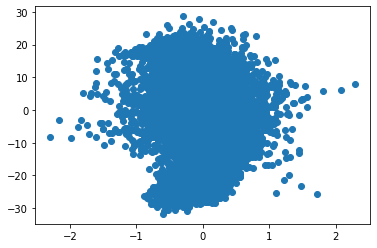

In [117]:
plt.scatter(np.mean(PCA_input, axis = 1), PCs[:,0])

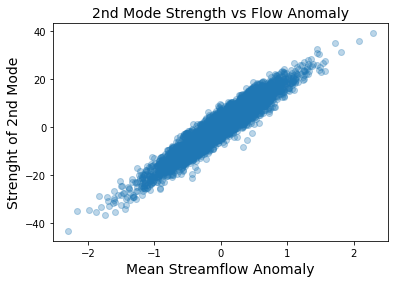

In [118]:
saveIt = 0

fig, ax = plt.subplots()
ax.scatter(np.mean(PCA_input, axis = 1), PCs[:,1], alpha = 0.3)
ax.set_xlabel('Mean Streamflow Anomaly', fontsize = fs)
ax.set_ylabel('Strenght of 2nd Mode', fontsize = fs)
ax.set_title('2nd Mode Strength vs Flow Anomaly', fontsize = fs)

if saveIt:
  plt.savefig('2nd_mode_PCs.png', bbox_inches = 'tight', dpi = 300)

plt.show()

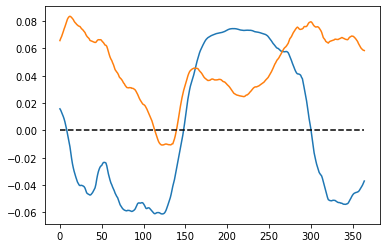

In [133]:
#visualize eigenvectors

plt.plot(eigvecs[0,:])
plt.plot(eigvecs[1,:])
plt.plot(np.arange(365), np.zeros(365), 'k--')

plt.show()

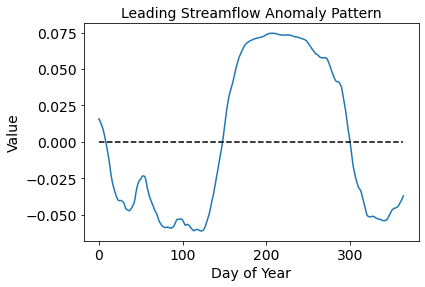

In [137]:
fig, ax = plt.subplots()

ax.plot(eigvecs[0,:])
ax.plot(np.arange(365), np.zeros(365), 'k--')
ax.plot()

ax.set_xlabel('Day of Year', fontsize = fs)
ax.set_ylabel('Value', fontsize = fs)
ax.set_title('Leading Streamflow Anomaly Pattern', fontsize = fs)
ax.tick_params(labelsize = fs)

In [120]:
#structure PCs as 3D array (years x stations x components)

PCs_mod_mat = np.zeros((Nyears, Nstations, n_components))
PCs_obs_mat = np.zeros((Nyears, Nstations, n_components))
PCs_mat = np.zeros((Nyears, Nstations, n_components))

for component in range(n_components):

  PCs_mod_mat[:,:,component] = np.reshape(PCs_mod[:,component], (Nstations,Nyears)).T
  PCs_obs_mat[:,:,component] = np.reshape(PCs_obs[:,component], (Nstations,Nyears)).T
  PCs_mat[:,:,component] = np.reshape(PCs[:,component], (Nstations,Nyears)).T

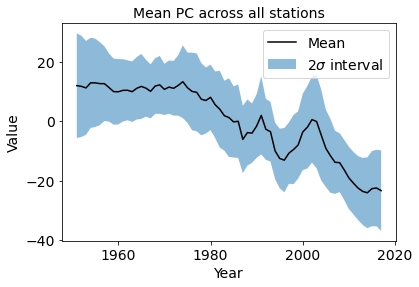

In [186]:
#visualize mean PC across stations

saveIt = 1

component = 0

fig, ax = plt.subplots()

x2 = np.mean(PCs_mat[:,:,component], axis = -1)
x2_std = np.std(PCs_mat[:,:,component], axis = -1)
err = 2*x2_std

yrs = np.arange(1951,2018)
# yrs = range(Nyears)
ax.plot(yrs, x2, color = 'k', label = 'Mean')
ax.fill_between(yrs, x2+err, x2-err, alpha = 0.5, label = '$2\sigma$ interval')
ax.set_xlabel('Year', fontsize = fs)
ax.set_ylabel('Value', fontsize = fs)
ax.set_title('Mean PC across all stations', fontsize = fs)
ax.legend(fontsize = fs)
ax.tick_params(labelsize = fs)

if saveIt:
  plt.savefig('mean_PCs_all.png', bbox_inches = 'tight', dpi = 300)

plt.show()

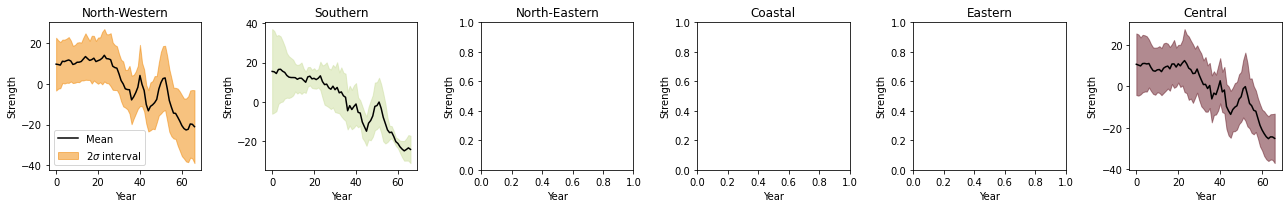

In [122]:
#PCs by cluster

saveIt = 0

component = 0

nrows = 2
ncols = int(np.ceil(n_clusters_seasonal/nrows))
# fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols,3*nrows))

nrows = 1
ncols = 6
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols,3*nrows))
clusters = [0,1,2,3,4,5]
for kk, ax in enumerate(axes.flatten()):

  cluster = clusters[kk]
  inds = np.squeeze(np.argwhere(labels[stations_for_PCA] == cluster))
  # inds = np.squeeze(np.array([np.argwhere(stations_for_PCA==ind) for ind in inds]))

  if np.size(inds) > 0:
    xx = np.mean(PCs_mat[:, inds, component], axis = -1)
    xx_std = np.std(PCs_mat[:,inds, component], axis = -1)
    err = 1*xx_std
    
    ax.plot(yrs, xx, 'k', label = 'Mean')
    # ax.fill_between(yrs, xx+err, xx-err, alpha = 0.5, color = rgbas_array[cluster,:])
    ax.fill_between(yrs, xx+2*err, xx-2*err, alpha = 0.5, color = rgbas_array[cluster,:], label = '2$\sigma$ interval')

    if kk == 0:
      ax.legend()

  
  ax.set_xlabel('Year')
  ax.set_ylabel('Strength')
  ax.set_title(cluster_names[cluster])

plt.tight_layout()

if saveIt:
  plt.savefig('PCs_by_cluster.png', bbox_inches = 'tight', dpi = 300)

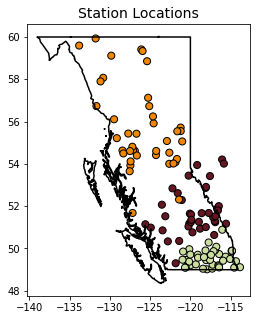

In [123]:
#station locations

saveIt = 0

fig, ax = plt.subplots(figsize = (4,5))

plot_prov_ax(prov = ['BC'], ax = ax)
ax.scatter(stationLon[stationInds][stations_for_PCA],
           stationLat[stationInds][stations_for_PCA],
           c = cStations[stations_for_PCA,:],
           edgecolor = 'k',
           s = 50)
ax.set_title('Station Locations', fontsize = fs)

if saveIt:
  plt.savefig('station_locations.png', bbox_inches = 'tight', dpi = 300)

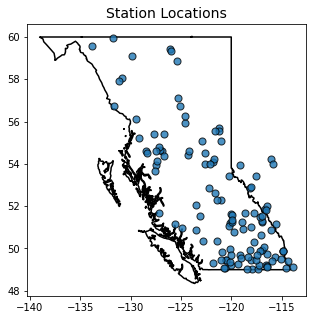

In [124]:
#station locations

saveIt = 0

fig, ax = plt.subplots(figsize = (5,5))

plot_prov_ax(prov = ['BC'], ax = ax)
ax.scatter(stationLon[stationInds][stations_for_PCA],
           stationLat[stationInds][stations_for_PCA],
           edgecolor = 'k',
           s = 50,
           zorder = 5, 
           alpha = 0.8)
ax.set_title('Station Locations', fontsize = fs)

if saveIt:
  plt.savefig('station_locations.png', bbox_inches = 'tight', dpi = 300)

In [125]:
#cluster in space of PC timeseries

component = 0

cluster_input = np.empty((len(stations_for_PCA), Nyears))

for station in range(len(stations_for_PCA)):
  cluster_input[station,:] = PCs_mat[:,station,component]

#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters = 3
PC_clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(PC_clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

labels_PCs = PC_clustering.labels_

#colours of each station
cStations = np.empty((len(stations_for_PCA), 3))
for kk in range(len(stations_for_PCA)):
  cStations[kk,:] = rgbs[PC_clustering.labels_[kk]]
cStations /= 256

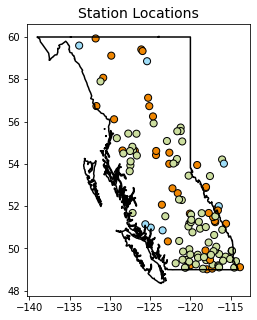

In [126]:
#station locations

saveIt = 0

fig, ax = plt.subplots(figsize = (4,5))

plot_prov_ax(prov = ['BC'], ax = ax)
ax.scatter(stationLon[stationInds][stations_for_PCA],
           stationLat[stationInds][stations_for_PCA],
           c = cStations,#[stations_for_PCA,:],
           edgecolor = 'k',
           s = 50)
ax.set_title('Station Locations', fontsize = fs)

if saveIt:
  plt.savefig('station_locations.png', bbox_inches = 'tight', dpi = 300)

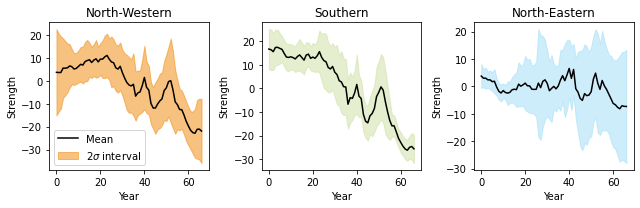

In [170]:
#PCs by cluster

saveIt = 0

component = 0

clusters = [0,1,2,3,4,5]
clusters = [0,1,5]
nrows = 1
ncols = len(clusters)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols,3*nrows))
clusters = [0,1,2,3,4,5]
for kk, ax in enumerate(axes.flatten()):

  cluster = clusters[kk]
  inds = np.squeeze(np.argwhere(labels_PCs == cluster))

  if np.size(inds) > 0:
    # xx = np.mean(PCs_mat[:, inds, component], axis = -1)
    # xx_std = np.std(PCs_mat[:,inds, component], axis = -1)
    xx = np.mean(cluster_input[inds, :], axis = 0)
    xx_std = np.std(cluster_input[inds, :], axis = 0)
    err = 1*xx_std
    
    ax.plot(xx, 'k', label = 'Mean')
    ax.fill_between(range(len(xx)), xx+2*err, xx-2*err, alpha = 0.5, color = rgbas_array[cluster,:], label = '2$\sigma$ interval')

    if kk == 0:
      ax.legend()
  
  ax.set_xlabel('Year')
  ax.set_ylabel('Strength')
  ax.set_title(cluster_names[cluster])

plt.tight_layout()

if saveIt:
  plt.savefig('PCs_by_cluster.png', bbox_inches = 'tight', dpi = 300)

In [128]:
#calculate linear slope of PCs

component = 0
PC_slope = np.zeros(len(stations_for_PCA))
PC_slope_p = np.zeros(len(stations_for_PCA))
for station in range(len(stations_for_PCA)):

  XX = np.arange(20,Nyears).reshape(-1,1)
  yy = PCs_mat[20:,station,component].reshape(-1,1)

  lm = LinearRegression().fit(X=XX, y=yy)
  MK = mk.original_test(yy)

  PC_slope[station] = lm.coef_ #MK.slope#
  PC_slope_p[station] = MK.p

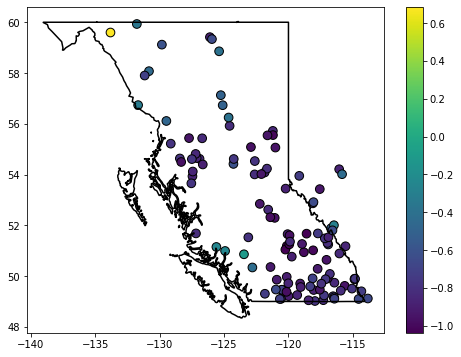

In [131]:
#visualize slope of PC series in space

fig, ax = plt.subplots(figsize = (8,6))
sig_p = np.argwhere(PC_slope_p < 0.05)
vmax = 0#np.sort(PC_slope[sig_p])[-2]
# vmax = -0.2
plot_prov_ax(['BC'], ax)
s = ax.scatter(stationLon[stationInds][stations_for_PCA][sig_p], 
               stationLat[stationInds][stations_for_PCA][sig_p], 
               c = PC_slope[sig_p], s = 75, edgecolor = 'k')#, vmax = vmax)
plt.colorbar(s)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


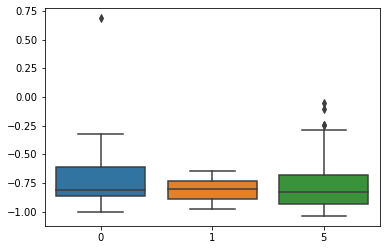

In [132]:
# sns.violinplot(labels, PC_slope)
sns.boxplot(labels[stations_for_PCA], PC_slope)

In [278]:
filename = 'temp_distribution_labels.csv'
labels_temp = np.squeeze(pd.read_csv(dir_data + '/' + filename, header = None).values)

In [279]:
filename = 'PC_warming_labels.csv'
np.savetxt(dir_data + '/' + filename, labels_PCs, delimiter = ',')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


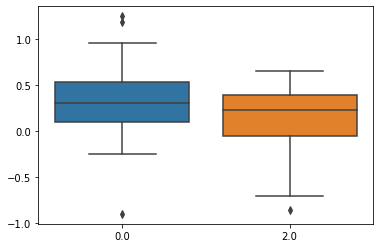

In [122]:
sns.boxplot(labels_temp[stations_for_PCA], PC_slope)

In [280]:
Nearly = 20
PC1_early = np.mean(PCs_mat[:Nearly,:,0], axis = 0)
PC1_late = np.mean(PCs_mat[-Nearly:,:,0], axis = 0)
dPC1 = PC1_late - PC1_early
PC2_early = np.mean(PCs_mat[:Nearly,:,1], axis = 0)
PC2_late = np.mean(PCs_mat[-Nearly:,:,1], axis = 0)
dPC2 = PC2_late - PC2_early

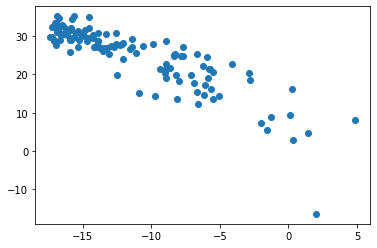

In [281]:
plt.scatter(PC1_early, dPC1)

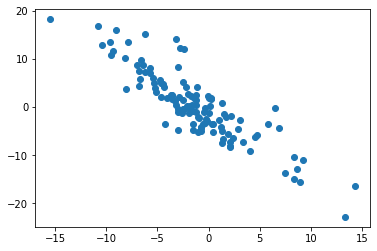

In [282]:
plt.scatter(PC2_early, dPC2)

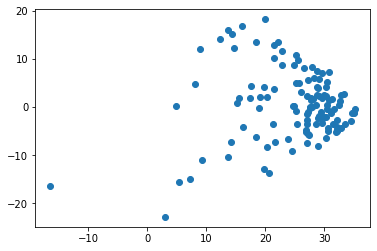

In [283]:
plt.scatter(dPC1, dPC2)

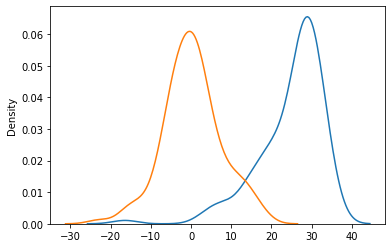

In [284]:
sns.kdeplot(dPC1)
sns.kdeplot(dPC2)

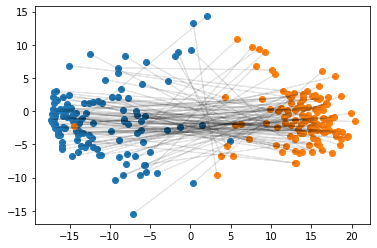

In [285]:
plt.scatter(PC1_early, PC2_early)
plt.scatter(PC1_late, PC2_late)
# plt.quiver(PC1_early, PC2_early, dPC1, dPC2, alpha = 0.1, scale = 100)
for ind in range(len(stations_for_PCA)):
  plt.arrow(PC1_early[ind], PC2_early[ind], dPC1[ind], dPC2[ind], alpha = 0.1)


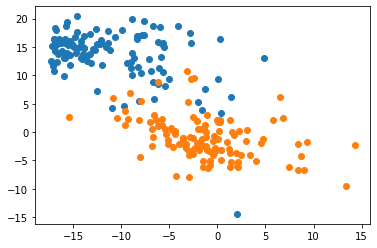

In [286]:
plt.scatter(PC1_early, PC1_late)
plt.scatter(PC2_early, PC2_late)

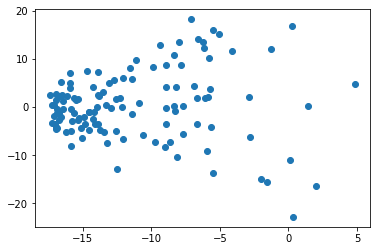

In [287]:
plt.scatter(PC1_early, dPC2)

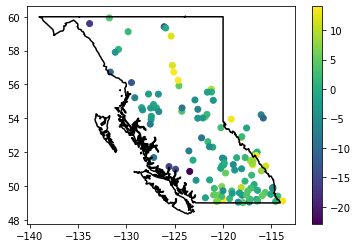

In [288]:
fig, ax = plt.subplots()
plot_prov_ax(prov = ['BC'], ax = ax)

c = dPC2
vmax = np.sort(c)[-5]

s = ax.scatter(
  stationLon[stationInds][stations_for_PCA],
  stationLat[stationInds][stations_for_PCA],
  c = c, vmax = vmax)

plt.colorbar(s)

# Climate Anomalies

In [187]:
#HIND

#load daily temperature data
# pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1950_1978_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
Tmax_hind = np.asarray(tempDict['Tmax'])
Tmin_hind = np.asarray(tempDict['Tmin'])
Tmean_hind = np.mean([Tmin_hind, Tmax_hind], axis = 0)
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_hind_T = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]
del tempDict

#load daily precipitation data
# pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1950_1978_025grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)
P_hind = np.asarray(precDict['P'])
del precDict

#load daily evaporation data
# pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1950_1978_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1950_1978_025grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)
E_hind = np.asarray(evapDict['E'])
PE_hind = P_hind + E_hind
del evapDict

print(hpy().heap())

#MODERN

# #load daily temperature data
# pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
# tempDict = pickle.load(pickle_in)

#load daily temperature data
pickle_in = open(dir_data + '/' + 'maxTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
Tmax_modern = np.asarray(tempDict['Tmax'])
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']
extentERA = [np.min(eraLon), np.max(eraLon), np.min(eraLat), np.max(eraLat)]
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate_modern_T = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]
del tempDict

pickle_in = open(dir_data + '/' + 'minTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
Tmin_modern = np.asarray(tempDict['Tmin'])
Tmean_modern = np.mean([Tmin_modern, Tmax_modern], axis = 0)
del tempDict

#load daily precipitation data
# pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)
P_modern = np.asarray(precDict['P'])
del precDict

#load daily evaporation data
# pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'evapDict_ERA5_1979_2020_025grid_AB_BC.pickle','rb')
evapDict = pickle.load(pickle_in)
E_modern = np.asarray(evapDict['E'])[:-731]
PE_modern = P_modern + E_modern
del evapDict

# #unpack data
# eraLat = tempDict['latERA']
# eraLon = tempDict['lonERA']
# extentERA = [np.min(eraLon), np.max(eraLon), np.min(eraLat), np.max(eraLat)]

# eraDays = tempDict['daysERA']
# eraMonths = tempDict['monthsERA']
# eraYears = tempDict['yearsERA']
# date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
# eraDate_modern_T = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]

Partition of a set of 1829243 objects. Total size = 6200306972 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0  24878   1 5618565684  91 5618565684  91 numpy.ndarray
     1    577   0 235435506   4 5854001190  94 pandas.core.series.Series
     2    567   0 117650232   2 5971651422  96 pandas.core.indexes.datetimes.DatetimeIndex
     3 558925  31 69161743   1 6040813165  97 str
     4 380119  21 33234144   1 6074047309  98 tuple
     5  50952   3 16144136   0 6090191445  98 dict (no owner)
     6  90063   5 12969072   0 6103160517  98 function
     7 155243   8 12758866   0 6115919383  99 bytes
     8  78461   4 11354096   0 6127273479  99 types.CodeType
     9   8663   0  8621408   0 6135894887  99 type
<2866 more rows. Type e.g. '_.more' to view.>


In [189]:
#format data by pixel
Nlat = np.shape(Tmax_hind)[1]
Nlon = np.shape(Tmax_hind)[2]
Npx = Nlat*Nlon #number of pixels

# Tmax_hind_px = Tmax_hind.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
# Tmax_modern_px = Tmax_modern.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
# Tmax_px = np.vstack([Tmax_hind_px, Tmax_modern_px])

# Tmin_hind_px = Tmin_hind.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
# Tmin_modern_px = Tmin_modern.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
# Tmin_px = np.vstack([Tmin_hind_px, Tmin_modern_px])

Tmean_hind_px = Tmean_hind.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmean_modern_px = Tmean_modern.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmean_px = np.vstack([Tmean_hind_px, Tmean_modern_px])

del Tmean_hind_px, Tmean_modern_px, Tmean_hind, Tmean_modern

P_hind_px = P_hind.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_modern_px = P_modern.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_px = np.vstack([P_hind_px, P_modern_px])

del P_hind_px, P_modern_px, P_hind, P_modern 

E_hind_px = E_hind.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
E_modern_px = E_modern.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
E_px = np.vstack([E_hind_px, E_modern_px])

del E_hind_px, E_modern_px, E_hind, E_modern

PE_hind_px = PE_hind.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
PE_modern_px = PE_modern.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
PE_px = np.vstack([PE_hind_px, PE_modern_px])

del PE_hind_px, PE_modern_px, PE_hind, PE_modern

date_all = np.vstack([np.reshape(eraDate_hind_T, (-1,1)), np.reshape(eraDate_modern_T, (-1,1))])

#reformat last few days
P_px_new = np.zeros(np.shape(Tmean_px))
P_px_new[:-2,:] = np.copy(P_px)
P_px = P_px_new
del P_px_new

E_px_new = np.zeros(np.shape(Tmean_px))
E_px_new[:-2,:] = np.copy(E_px)
E_px = E_px_new
del E_px_new

PE_px_new = np.zeros(np.shape(Tmean_px))
PE_px_new[:-2,:] = np.copy(PE_px)
PE_px = PE_px_new
del PE_px_new

In [190]:
delta = timedelta(days = 364)
year_start = 1951
year_fin = 2015
year_fin = 2020
year_fin = 2018

# Tmax_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
# Tmin_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
Tmean_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
P_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
E_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
PE_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))

kk = 0

for nn, year in enumerate(range(year_start, year_fin+1)):

  start_date = datetime(year, 1, 1)
  fin_date = start_date + delta

  start_ind = np.argwhere(date_all==start_date)[0][0]
  fin_ind = np.argwhere(date_all==fin_date)[0][0]

  # Tmax_seasonal_yearly[:,:,nn] = Tmax_px[start_ind:fin_ind+1,:]
  # Tmin_seasonal_yearly[:,:,nn] = Tmin_px[start_ind:fin_ind+1,:]
  Tmean_seasonal_yearly[:,:,nn] = Tmean_px[start_ind:fin_ind+1,:]
  P_seasonal_yearly[:,:,nn] = P_px[start_ind:fin_ind+1,:]
  E_seasonal_yearly[:,:,nn] = E_px[start_ind:fin_ind+1,:]
  PE_seasonal_yearly[:,:,nn] = PE_px[start_ind:fin_ind+1,:]

# Tmax_seasonal = np.mean(Tmax_seasonal_yearly, axis = -1)
# Tmax_anomaly = Tmax_seasonal_yearly - np.expand_dims(Tmax_seasonal, axis = -1)

# Tmin_seasonal = np.mean(Tmin_seasonal_yearly, axis = -1)
# Tmin_anomaly = Tmin_seasonal_yearly - np.expand_dims(Tmin_seasonal, axis = -1)

del Tmean_px, P_px, E_px, PE_px

Tmean_seasonal = np.mean(Tmean_seasonal_yearly, axis = -1)
Tmean_anomaly = Tmean_seasonal_yearly - np.expand_dims(Tmean_seasonal, axis = -1)

P_seasonal = np.mean(P_seasonal_yearly, axis = -1)
P_anomaly = P_seasonal_yearly - np.expand_dims(P_seasonal, axis = -1)

E_seasonal = np.mean(E_seasonal_yearly, axis = -1)
E_anomaly = E_seasonal_yearly - np.expand_dims(E_seasonal, axis = -1)

PE_seasonal = np.mean(PE_seasonal_yearly, axis = -1)
PE_anomaly = PE_seasonal_yearly - np.expand_dims(PE_seasonal, axis = -1)

# Tmean_seasonal_yearly = np.mean([Tmax_seasonal_yearly, Tmin_seasonal_yearly], axis = 0)
# Tmean_seasonal = np.mean(Tmean_seasonal_yearly, axis = -1)
# Tmean_anomaly = Tmean_seasonal_yearly - np.expand_dims(Tmean_seasonal, axis = -1)

In [191]:
#the large climate files can get hairy -- check in on memory usage and make sure things are good
hpy().heap()

Partition of a set of 1850123 objects. Total size = 15944390325 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0  24890   1 15361476364  96 15361476364  96 numpy.ndarray
     1    577   0 235435506   1 15596911870  98 pandas.core.series.Series
     2    567   0 117650232   1 15714562102  99 pandas.core.indexes.datetimes.DatetimeIndex
     3 563077  30 69414217   0 15783976319  99 str
     4 380864  21 33283344   0 15817259663  99 tuple
     5  50881   3 16125512   0 15833385175  99 dict (no owner)
     6  90494   5 13031136   0 15846416311  99 function
     7 155261   8 12747193   0 15859163504  99 bytes
     8  78483   4 11357264   0 15870520768 100 types.CodeType
     9   8663   0  8621408   0 15879142176 100 type
<2865 more rows. Type e.g. '_.more' to view.>

In [192]:
#smooth over subsequent years
N_years_window = 21
kernel = np.ones(N_years_window)/N_years_window
start_year0 = 1951
start_year = np.copy(start_year0)
fin_year = start_year + N_years_window
extent = [0,364,2016.5 - N_years_window, 1950.5]

Ndays = 365
Nyears = len(np.arange(1951,2019))
seasonal_window = np.zeros((Ndays, Nstations, Nyears))
seasonal_window_obs = np.zeros((Ndays, Nstations, Nyears))
missing_window = np.zeros((Ndays, Nstations, Nyears))

for day in range(Ndays): #for each day of the year, smooth over mutliple adjacent years
  for pixel in range(Npx):

    xx = Tmean_seasonal_yearly[day, pixel, :]
    xx = np.pad(xx, 10, mode = 'edge')
    # Tmean_seasonal_yearly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()
    Tmean_seasonal_yearly[day, pixel, :] = np.convolve(xx, kernel, mode = 'valid')

    xx = Tmean_anomaly[day, pixel, :]
    xx = np.pad(xx, 10, mode = 'edge')
    # Tmean_anomaly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()
    Tmean_anomaly[day, pixel, :] = np.convolve(xx, kernel, mode = 'valid')

    # xx = P_seasonal_yearly[day, pixel, :]
    # P_seasonal_yearly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()

    # xx = P_anomaly[day, pixel, :]
    # P_anomaly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()

    # xx = E_seasonal_yearly[day, pixel, :]
    # E_seasonal_yearly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()

    # xx = E_anomaly[day, pixel, :]
    # E_anomaly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()

    xx = PE_seasonal_yearly[day, pixel, :]
    xx = np.pad(xx, 10, mode = 'edge')
    # PE_seasonal_yearly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()
    PE_seasonal_yearly[day, pixel, :] = np.convolve(xx, kernel, mode = 'valid')

    xx = PE_anomaly[day, pixel, :]
    xx = np.pad(xx, 10, mode = 'edge')
    # PE_anomaly[day, pixel, :] = pd.Series(xx).rolling(window = N_years_window, min_periods = 1, center = True).mean()   
    PE_anomaly[day, pixel, :] = np.convolve(xx, kernel, mode = 'valid') 

In [ ]:
# Twinter_anomaly = Tmean_anomaly[:90,:,:]
Twinter_anomaly = Tmean_anomaly[150:210,:,:]

In [193]:
#smooth anomalies over subsequent days and normalize by variance

N_days_window = 31
kernel = np.ones(N_days_window) / N_days_window

# Tmean_anomaly_norm = np.zeros(np.shape(Tmean_anomaly))
# P_anomaly_norm = np.zeros(np.shape(P_anomaly))
# E_anomaly_norm = np.zeros(np.shape(E_anomaly))
# PE_anomaly_norm = np.zeros(np.shape(PE_anomaly))

for pixel in range(Npx): #for each pixel
  for year in range(len(Tmean_anomaly[0,0,:])): #for each year, smooth over subsequent days

    # Tmean_anomaly[:,pixel,year] = pd.Series(Tmean_anomaly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean() 
    # Tmean_seasonal_yearly[:,pixel,year] = pd.Series(Tmean_seasonal_yearly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean()

    xx = Tmean_anomaly[:,pixel,year]
    xx = np.pad(xx, 15, mode = 'edge')
    Tmean_anomaly[:,pixel,year] = np.convolve(xx, kernel, mode = 'valid')

    xx = Tmean_seasonal_yearly[:,pixel,year]
    xx = np.pad(xx, 15, mode = 'edge')
    Tmean_seasonal_yearly[:,pixel,year] = np.convolve(xx, kernel, mode = 'valid')

    # Twinter_anomaly[:,pixel,year] = pd.Series(Twinter_anomaly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean() 

    # P_anomaly[:,pixel,year] = pd.Series(P_anomaly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean() 
    # P_seasonal_yearly[:,pixel,year] = pd.Series(P_seasonal_yearly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean()

    # E_anomaly[:,pixel,year] = pd.Series(E_anomaly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean() 
    # E_seasonal_yearly[:,pixel,year] = pd.Series(E_seasonal_yearly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean()  

    # PE_anomaly[:,pixel,year] = pd.Series(PE_anomaly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean() 
    # PE_seasonal_yearly[:,pixel,year] = pd.Series(PE_seasonal_yearly[:,pixel,year]).rolling(window = 30, min_periods = 1).mean()    

    xx = PE_anomaly[:,pixel,year]
    xx = np.pad(xx, 15, mode = 'edge')
    PE_anomaly[:,pixel,year] = np.convolve(xx, kernel, mode = 'valid')

    xx = PE_seasonal_yearly[:,pixel,year]
    xx = np.pad(xx, 15, mode = 'edge')
    PE_seasonal_yearly[:,pixel,year] = np.convolve(xx, kernel, mode = 'valid')

  # std = np.expand_dims(np.std(Tmean_seasonal_yearly[:,pixel,:], axis = -1), axis = -1)
  # Tmean_anomaly_norm[:,pixel,:] = Tmean_anomaly[:,pixel,:] / std

  # std = np.expand_dims(np.std(P_seasonal_yearly[:,pixel,:], axis = -1), axis = -1)
  # P_anomaly_norm[:,pixel,:] = P_anomaly[:,pixel,:] / std

  # std = np.expand_dims(np.std(E_seasonal_yearly[:,pixel,:], axis = -1), axis = -1)
  # E_anomaly_norm[:,pixel,:] = E_anomaly[:,pixel,:] / std

  # std = np.expand_dims(np.std(PE_seasonal_yearly[:,pixel,:], axis = -1), axis = -1)
  # PE_anomaly_norm[:,pixel,:] = PE_anomaly[:,pixel,:] / std

# Tmean_anomaly_norm_mean = np.mean(Tmean_anomaly_norm, axis = 0)
Tmean_anomaly_mean = np.mean(Tmean_anomaly, axis = 0)

# Twinter_anomaly_mean = np.mean(Twinter_anomaly, axis = 0)

# P_anomaly_norm_mean = np.mean(P_anomaly_norm, axis = 0)
# P_anomaly_mean = np.mean(P_anomaly, axis = 0)

# E_anomaly_norm_mean = np.mean(E_anomaly_norm, axis = 0)
# E_anomaly_mean = np.mean(E_anomaly, axis = 0)

# PE_anomaly_norm_mean = np.mean(PE_anomaly_norm, axis = 0)
PE_anomaly_mean = np.mean(PE_anomaly, axis = 0)

In [194]:
del Tmean_seasonal_yearly, PE_seasonal_yearly, E_seasonal_yearly, P_seasonal_yearly, Tmean_anomaly, P_anomaly, E_anomaly, PE_anomaly

In [195]:
hpy().heap()

Partition of a set of 1851659 objects. Total size = 5515428038 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0  24884   1 4932392324  89 4932392324  89 numpy.ndarray
     1    577   0 235435506   4 5167827830  94 pandas.core.series.Series
     2    567   0 117650232   2 5285478062  96 pandas.core.indexes.datetimes.DatetimeIndex
     3 563425  30 69461184   1 5354939246  97 str
     4 380958  21 33290960   1 5388230206  98 tuple
     5  50888   3 16155176   0 5404385382  98 dict (no owner)
     6  90494   5 13031136   0 5417416518  98 function
     7 155267   8 12748003   0 5430164521  98 bytes
     8  78487   4 11357840   0 5441522361  99 types.CodeType
     9   8663   0  8621408   0 5450143769  99 type
<2863 more rows. Type e.g. '_.more' to view.>

In [196]:
T_PE_anomaly_series = np.hstack([Tmean_anomaly_mean / np.std(Tmean_anomaly_mean), PE_anomaly_mean/ np.std(PE_anomaly_mean)]) #shape: pixel x year
PCA_input_series = T_PE_anomaly_series.T

n_components = 5#np.min(np.shape(PCA_input))
pca_series = PCA(n_components = n_components).fit(PCA_input_series)
frac_var_series = pca_series.explained_variance_ratio_
eigvecs_series = pca_series.components_

#model and observations
PCs_series = pca_series.transform(PCA_input_series)

print(frac_var_series, np.sum(frac_var_series))

[0.61059564 0.17160372 0.09039582 0.06763326 0.02088845] 0.9611168805501277


In [197]:
#determine which pixels are over land
from matplotlib import path
prov = ['AB','BC']
prov_abbreviations = ['AB','SK','MB','NL','PE','NS','NT','NU','ON','NB','YT','BC','QC']

#load shapefile of provincial boundaries
provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
provshapes = gpd.read_file(provshapes_filename)

#loop through each input province/territory and plot borders
land_px = np.zeros(Npx) #1 if by land, 0 if by sea
lonn, latt = np.meshgrid(eraLon,eraLat)

lat = latt.flatten()[pixel]
lon = lonn.flatten()[pixel]

for pv in prov:

  #polygons of this province/territory
  prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

  #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
  if len(np.shape(prov_poly)) == 0: #if only one polygon in prov

    x,y = prov_poly.exterior.coords.xy 
    p = path.Path([[x[kk],y[kk]] for kk in range(len(x))])
    points = [[lo, la] for lo, la in zip(lonn.flatten(), latt.flatten())]
    land_px += p.contains_points(points, radius = -0.01)

  else: #if multiply polygons in shape to plot

    for ind in range(len(prov_poly)): 
      x,y = prov_poly[ind].exterior.xy
      p = path.Path([[x[kk],y[kk]] for kk in range(len(x))])
      points = [[lo, la] for lo, la in zip(lonn.flatten(), latt.flatten())]
      land_px += p.contains_points(points, radius = -0.01)

land_px[land_px>0] = True
land_px = np.array(land_px, dtype = 'bool')

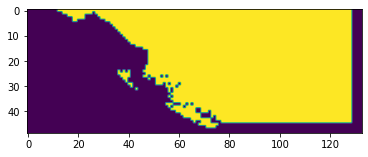

In [198]:
plt.imshow(land_px.reshape(Nlat,Nlon))

In [89]:
start_year = 0
T_PE_anomaly_series = np.hstack([Tmean_anomaly_mean[:,start_year:] / np.std(Tmean_anomaly_mean), PE_anomaly_mean[:,start_year:] / np.std(PE_anomaly_mean)]) #shape: pixel x year
cluster_input_series = T_PE_anomaly_series[land_px,:]

n_clusters = 8
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input_series)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input_series)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input_series[cluster_inds.reshape(-1,1),:], axis = 0)

labels = clustering.labels_

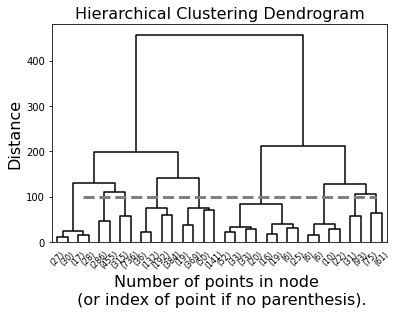

In [90]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input_series)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
cutoff = 100
linemin = 30
linemax = 310
plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [91]:
#details for plotting/visualizations 

#determine RGB values of colormap to use: chosen from coolors.co
rgbs = [[241, 135, 1], #cluster 0
      [205, 223, 160], #cluster 1
      [159, 222, 249], #etc
      [233, 134, 207],
      [21, 96, 121],
      [100, 23, 35]]

rgbas = [[241, 135, 1,256],
      [205, 223, 160,256],
      [159, 222, 249,256],
      [233, 134, 207,256],
      [21, 96, 121,256],
      [100, 23, 35,256]]

rgbs_array = np.asarray(rgbs)/256
rgbas_array = np.asarray(rgbas)/256

#assign geographically relevant names for each cluster
cluster_names = [
                 'North-Western',       #cluster 0
                 'Southern',      #cluster 1
                 'North-Eastern',       #etc
                 'Coastal',
                 'Eastern',
                 'Central'
]

#colours of each station
cStations = np.empty((len(stationInds), 3))
for kk in range(len(stationInds)):
  cStations[kk,:] = rgbs[seasonal_clustering.labels_[kk]]
cStations /= 256


Text(0.5, 1.0, 'Clusters in Space')

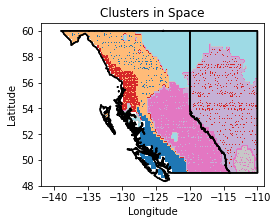

In [92]:
#visualize clustering results (spatial patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

cmap = matplotlib.colors.ListedColormap(rgbs_array)
cmap = cm.get_cmap('tab20')
bounds = np.arange(n_clusters, dtype = 'int')
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize = (4,3))

labels_plot = np.nan * np.ones(Npx)
labels_plot[land_px] = labels

#left side: spatial map of stations, coloured by cluster to which they belong
plot_prov_ax(prov=prov, ax = ax)
ax.imshow(labels_plot.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, cmap = cmap, norm = norm)#, c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
plot_prov_ax(prov = ['AB','BC'], ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clusters in Space')


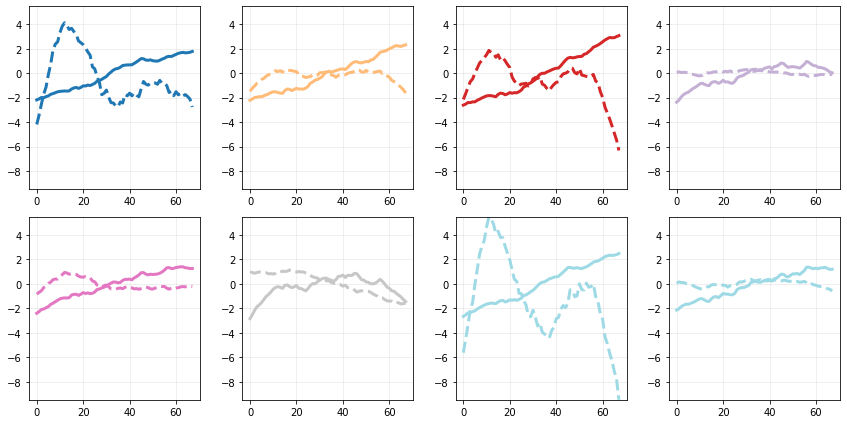

In [94]:
#temporal patterns

nrows = 2
ncols = int(np.ceil(n_clusters/2))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*3, nrows*3))

for cluster, ax in enumerate(axes.flatten()):
  if cluster < n_clusters:
    cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
    # ax.plot(cluster_input[cluster_inds,:70].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
    ax.plot(cluster_patterns[cluster,:int(len(cluster_patterns[0,:])/2)], color = cmap(norm(cluster)), linewidth = 3)
    ax.plot(cluster_patterns[cluster,int(len(cluster_patterns[0,:])/2):], color = cmap(norm(cluster)), linewidth = 3, linestyle = '--')
    # ax.set_title(cluster_names[cluster])
    ax.grid(True, alpha = 0.25)
    ax.set_ylim(bottom = np.min(cluster_patterns), top = np.max(cluster_patterns))

plt.tight_layout()

plt.show()

In [95]:
#cluster each decade
Npx_land = len(np.argwhere(land_px == True))
start_years = np.arange(0,50,step = 1, dtype = 'int')
labels = np.zeros((Npx_land,len(start_years)))

for kk, start_year in enumerate(start_years):

  T_PE_anomaly_series = np.hstack([Tmean_anomaly_mean[:,start_year:] / np.std(Tmean_anomaly_mean), PE_anomaly_mean[:,start_year:] / np.std(PE_anomaly_mean)]) #shape: pixel x year
  cluster_input_series = T_PE_anomaly_series[land_px,:]

  n_clusters = 8
  clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input_series)

  #calculate average of each cluster
  cluster_patterns = np.empty((n_clusters, np.shape(cluster_input_series)[1]))
  for cluster in range(n_clusters):
    cluster_inds = np.argwhere(clustering.labels_ == cluster)
    cluster_patterns[cluster,:] = np.mean(cluster_input_series[cluster_inds.reshape(-1,1),:], axis = 0)

  labels[:,kk] = clustering.labels_

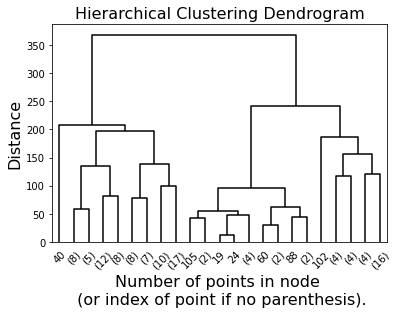

In [96]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_seasonal.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_seasonal.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [97]:
cluster_input = labels

n_clusters = 5
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input_series)

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(clustering.labels_ == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

labels2 = clustering.labels_

Text(0.5, 1.0, 'Clusters in Space')

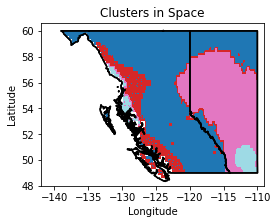

In [98]:
#visualize clustering results (spatial patterns)

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

cmap = matplotlib.colors.ListedColormap(rgbs_array)
cmap = cm.get_cmap('tab20')
bounds = np.arange(n_clusters, dtype = 'int')
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize = (4,3))

labels2_plot = np.nan*np.ones(Npx)
labels2_plot[land_px] = labels2

#left side: spatial map of stations, coloured by cluster to which they belong
plot_prov_ax(prov=prov, ax = ax)
ax.imshow(labels2_plot.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, cmap = cmap, norm = norm)#, c = cStations, s = 100, linewidth = 1, edgeColor = 'k', zOrder = 3)
plot_prov_ax(prov = ['AB','BC'], ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clusters in Space')


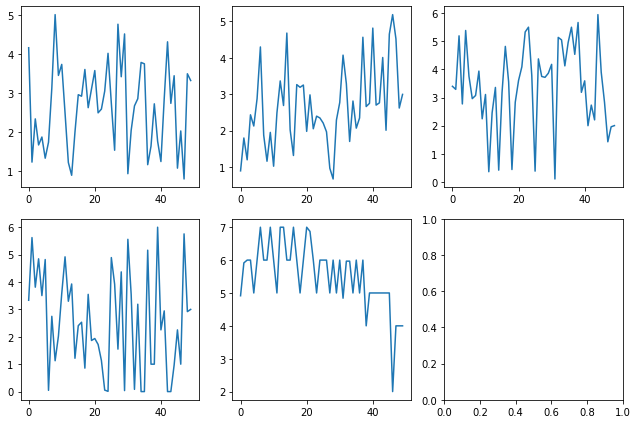

In [100]:
#temporal patterns

nrows = 2
ncols = int(np.ceil(n_clusters/2))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*3, nrows*3))

for cluster, ax in enumerate(axes.flatten()):
  if cluster < n_clusters:
    cluster_inds = np.squeeze(np.argwhere(seasonal_clustering.labels_ == cluster))
    # ax.plot(cluster_input[cluster_inds,:].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
    ax.plot(cluster_patterns[cluster,:])

    # ax.set_title(cluster_names[cluster])
    # ax.set_ylim((0,n_clusters))

plt.tight_layout()

plt.show()

In [199]:
#identify station pixels
Nyears = 68
Tmean_anomaly_mean_station = np.zeros((Nstations, Nyears))
Twinter_anomaly_mean_station = np.zeros((Nstations, Nyears))
P_anomaly_mean_station = np.zeros((Nstations, Nyears))
E_anomaly_mean_station = np.zeros((Nstations, Nyears))
PE_anomaly_mean_station = np.zeros((Nstations, Nyears))

grid_inds = np.reshape(np.arange(Npx),(Nlat,Nlon))
for station in range(Nstations):

  lon = stationLon[stationInds][stations_for_PCA][station]
  lat = stationLat[stationInds][stations_for_PCA][station]

  dlon = np.abs(eraLon - lon)
  dlat = np.abs(eraLat - lat)

  indLon = np.argmin(dlon)
  indLat = np.argmin(dlat)
  ind = grid_inds[indLat, indLon]

  Tmean_anomaly_mean_station[station,:] = Tmean_anomaly_mean[ind,:]
  # Twinter_anomaly_mean_station[station,:] = Twinter_anomaly_mean[ind,:]
  PE_anomaly_mean_station[station,:] = PE_anomaly_mean[ind,:]

Tmean_anomaly_mean_station = np.delete(Tmean_anomaly_mean_station, 28, -1)
# Twinter_anomaly_mean_station = np.delete(Twinter_anomaly_mean_station, 28, -1)
P_anomaly_mean_station = np.delete(P_anomaly_mean_station, 28, -1)
E_anomaly_mean_station = np.delete(E_anomaly_mean_station, 28, -1)
PE_anomaly_mean_station = np.delete(PE_anomaly_mean_station, 28, -1)

In [200]:
Nstations, Nyears

(120, 68)

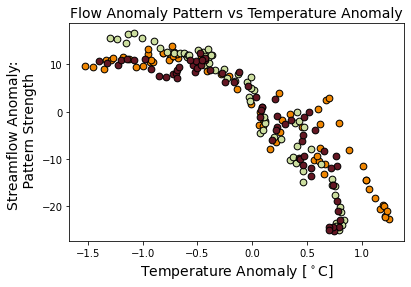

In [201]:
saveIt = 0

component = 0
fig, ax = plt.subplots()
# for station in range(Nstations):

clusters = [0,1,5]
# clusters = [0,1,2,3,4,5]
# clusters = [2]

for cluster in range(n_clusters_seasonal):

  if cluster in clusters:

    inds = np.squeeze(np.argwhere(seasonal_clustering.labels_[stations_for_PCA] == cluster))
    xx = np.mean(Tmean_anomaly_mean_station[inds,:], axis = 0)
    yy = np.mean(PCs_mat[:,inds,component], axis = 1)
    ax.scatter(xx, yy, color = rgbas_array[cluster,:], edgecolor = 'k', s = 45, label = cluster_names[cluster])

ax.set_xlabel('Temperature Anomaly [$^\circ$C]', fontsize = fs)
ax.set_ylabel('Streamflow Anomaly: \n Pattern Strength', fontsize = fs)
ax.set_title('Flow Anomaly Pattern vs Temperature Anomaly', fontsize = fs)
# ax.legend(fontsize = fs)

if saveIt:
  plt.savefig('southern_central_northern_temp_driven.png', bbox_inches = 'tight', dpi = 300)

plt.show()

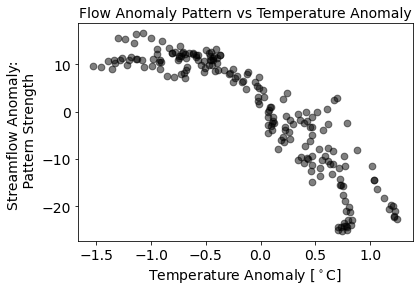

In [218]:
saveIt = 1

component = 0
fig, ax = plt.subplots()

clusters = [0,1,5]
# clusters = [0,1,2,3,4,5]
# clusters = [2]

for cluster in range(n_clusters_seasonal):

  if cluster in clusters:

    inds = np.squeeze(np.argwhere(seasonal_clustering.labels_[stations_for_PCA] == cluster))
    xx = np.mean(Tmean_anomaly_mean_station[inds,:], axis = 0)
    yy = np.mean(PCs_mat[:,inds,component], axis = 1)
    ax.scatter(xx, yy, edgecolor = 'k', s = 45, alpha = 0.5, color = 'k')

ax.set_xlabel('Temperature Anomaly [$^\circ$C]', fontsize = fs)
ax.set_ylabel('Streamflow Anomaly: \n Pattern Strength', fontsize = fs)
ax.set_title('Flow Anomaly Pattern vs Temperature Anomaly', fontsize = fs)
ax.tick_params(labelsize = fs)
# ax.legend(fontsize = fs)

if saveIt:
  plt.savefig('southern_central_northern_temp_driven.png', bbox_inches = 'tight', dpi = 300)

plt.show()

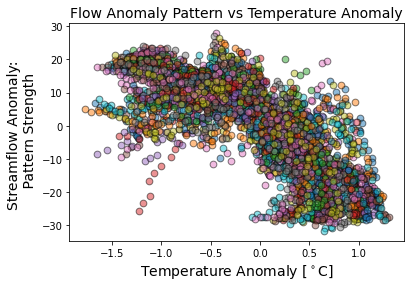

In [213]:
saveIt = 0

component = 0
fig, ax = plt.subplots()

clusters = [0,1,5]
# clusters = [0,1,2,3,4,5]
clusters = [1,5]

for cluster in range(n_clusters_seasonal):

  if cluster in clusters:

    inds = np.squeeze(np.argwhere(seasonal_clustering.labels_[stations_for_PCA] == cluster))

    for ind in inds:
      xx = Tmean_anomaly_mean_station[ind,:]
      yy = PCs_mat[:,ind,component]
      ax.scatter(xx, yy, edgecolor = 'k', s = 45, alpha = 0.5)

ax.set_xlabel('Temperature Anomaly [$^\circ$C]', fontsize = fs)
ax.set_ylabel('Streamflow Anomaly: \n Pattern Strength', fontsize = fs)
ax.set_title('Flow Anomaly Pattern vs Temperature Anomaly', fontsize = fs)
ax.tick_params(labelsize = fs-4)
# ax.legend(fontsize = fs)

if saveIt:
  plt.savefig('southern_central_northern_temp_driven.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [105]:
np.shape(PCs_mat)

(67, 120, 10)

In [306]:
np.shape(xx), np.shape(yy)

((2, 67), (47, 2))

ValueError: ignored

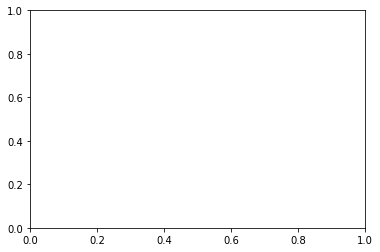

In [307]:
saveIt = 0

component = 1
fig, ax = plt.subplots()
# for station in range(Nstations):

clusters = [0,1,5]
clusters = [0,1,2,3,4,5]

for cluster in range(n_clusters_seasonal):

  if cluster in clusters:

    inds = np.squeeze(np.argwhere(labels[stations_for_PCA] == cluster))
    xx = np.mean(PE_anomaly_mean_station[inds,:], axis = 0)*1000
    cc = cStations#np.mean(Tmean_anomaly_mean_station[inds,:], axis = 0)

    yy = np.mean(PCs_mat[:,inds,component], axis = 1)
    ax.scatter(xx[10:-10], yy, c=cc[10:-10], edgecolor = 'k', s = 45, label = cluster_names[cluster])

ax.set_xlabel('PE Anomaly [mm]', fontsize = fs)
ax.set_ylabel('Streamflow Anomaly: \n Pattern Strength', fontsize = fs)
ax.set_title('Flow Anomaly Pattern vs Temperature Anomaly', fontsize = fs)

if saveIt:
  plt.savefig('southern_central_northern_temp_driven.png', bbox_inches = 'tight', dpi = 300)

plt.show()

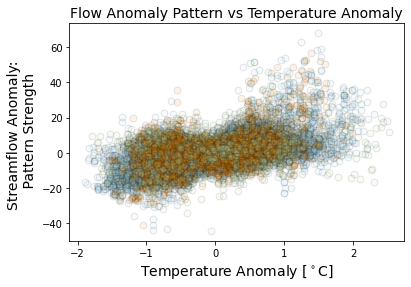

In [ ]:
saveIt = 0

component_climate = 0
component_flow = 1
fig, ax = plt.subplots()
for station in range(Nstations):

  cluster = labels[stations_for_PCA][station]
  if cluster <6:

    xx = PE_anomaly_mean_station[station,:]
    xx = Tmean_anomaly_mean_station[station,:]
    yy = PCs_mat[:,station,component_flow]
    ax.scatter(xx, yy, color = cStations[station], edgecolor = 'k', s = 45, alpha = 0.1)

ax.set_xlabel('Temperature Anomaly [$^\circ$C]', fontsize = fs)
ax.set_ylabel('Streamflow Anomaly: \n Pattern Strength', fontsize = fs)
ax.set_title('Flow Anomaly Pattern vs Temperature Anomaly', fontsize = fs)

if saveIt:
  plt.savefig('southern_central_northern_temp_driven.png', bbox_inches = 'tight', dpi = 300)

plt.show()

# Anticipated Signals of Change

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


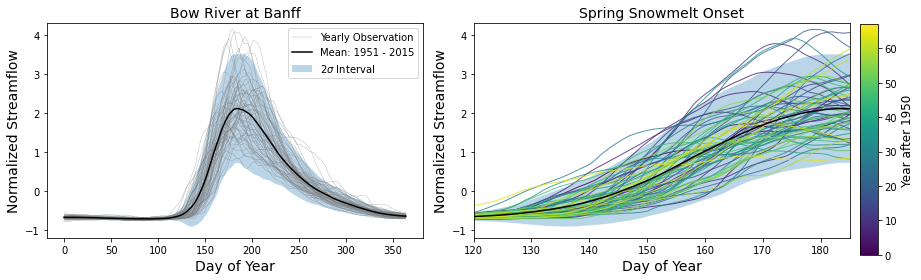

In [149]:
saveIt = 0

ind = 157
# ind = 6

f = np.copy(f_seasonal_yearly_obs[:,ind,:].T) #rows are years, columns are days
for year in range(len(f)):
  f[year,:] = pd.Series(f[year,:]).rolling(window = 30, min_periods = 1).mean()
f_std = np.nanstd(f, axis = 0)
f_mean = np.nanmean(f, axis = 0)
f_max = np.nanmax(f, axis = 0)
f_min = np.nanmin(f, axis = 0)

cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = len(f[:,0]))

fs = 14

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax[0].fill_between(range(365),f_mean + 2*f_std, f_mean - 2*f_std, alpha = 0.3, label = '2$\sigma$ Interval')
ax[0].plot(f[0,:],'gray', linewidth = 0.25, label = 'Yearly Observation')
ax[0].plot(f.T,'gray', linewidth = 0.25)
ax[0].plot(f_mean,'k', label = 'Mean: 1951 - 2015')
ax[0].set_xlabel('Day of Year', fontsize = fs)
ax[0].set_ylabel('Normalized Streamflow', fontsize = fs)
ax[0].legend(fontsize = fs - 4)
ax[0].set_title('Bow River at Banff', fontsize = fs)
ax[0].set_ylim((-1.2, 4.3))

ax[1].fill_between(range(365),f_mean + 2*f_std, f_mean - 2*f_std, alpha = 0.3, label = '2$\sigma$ Interval')
ax[1].plot(f[0,:],'gray', linewidth = 0.25, label = 'Yearly Observation')
for year in range(len(f[:,0])):
  ax[1].plot(f[year,:],'gray', linewidth = 1, alpha = 0.8, color = cmap(norm(year)))
ax[1].plot(f_mean,'k', label = 'Mean: 1951 - 2015')
# ax[1].legend()
ax[1].set_xlim((120,185))
ax[1].set_xlabel('Day of Year', fontsize = fs)
ax[1].set_ylabel('Normalized Streamflow', fontsize = fs)
ax[1].set_title('Spring Snowmelt Onset', fontsize = fs)
ax[1].set_ylim((-1.2, 4.3))

width = 0.02
height = 0.8
dh = (1-height)/2
dw = (1-width)/2
ax_cb = fig.add_axes([1.,dh,width,height])
cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
ax_cb.set_ylabel('Year after 1950', fontsize = fs-2)
# fig.colorbar(cmap = cmap, norm = norm)

plt.tight_layout()

if saveIt:
  plt.savefig('bow_seasonal_yearly_colour.png', dpi = 300, bbox_inches = 'tight')

plt.show()



In [150]:
N_steps = 10

N_shifts = N_steps
N_days_per_shift = 2
f_shifts = np.zeros((N_shifts, 365))

N_scales = N_steps
frac_scale = 0.02
f_scales = np.zeros((N_scales, 365))

#streamflow shift
start = 0
f_pad = np.pad(f_mean, 2*N_shifts*N_days_per_shift, mode = 'edge')[3*N_shifts*N_days_per_shift:]
for shift in range(N_shifts):

  # f_shifts[shift, :365-start] = np.copy(f_mean[start:])
  # f_shifts[shift, 365-start:] = np.copy(f_mean[:start])

  f_shifts[shift,:] = np.copy(f_pad[start:start+365])

  start += N_days_per_shift

# f_shifts[:,:N_shifts*N_days_per_shift] = np.nan
# f_shifts[:,-N_shifts*N_days_per_shift:] = np.nan

#streamflow scale
for scale in range(N_scales):
  f_scales[scale,:] = f_mean * (1 - scale*frac_scale)

#both at once
N_shiftscale = N_steps
N_days_per_shift = 1
frac_scale = 0.01
f_shiftscales = np.zeros((N_shiftscale, 365))
start = 0
for kk in range(N_shiftscale):
  shift = kk*N_days_per_shift
  scale = kk*frac_scale
  # f_shiftscales[kk, :365-shift] = np.copy(f_mean[shift:])
  f_shiftscales[kk,:] = f_pad[shift:shift+365]
  f_shiftscales[kk,:] *= (1 - scale)
# f_shiftscales[:,:N_shifts*N_days_per_shift] = np.nan
# f_shiftscales[:,-N_shifts*N_days_per_shift:] = np.nan#f_shiftscales[:,N_shifts*N_days_per_shift-2]#np.nan
# f_shiftscales = f_shiftscales[:,N_shifts*N_days_per_shift:-N_shifts*N_days_per_shift]

#calculate difference through time (between endpoints), normalize at each day
d_shift = f_shifts[-1,:] - f_shifts[0,:]
d_shift /= np.nanstd(f_shifts, axis = 0)

d_scales = f_scales[-1,:] - f_scales[0,:]
d_scales /= np.nanstd(f_scales, axis = 0)

d_shiftscales = f_shiftscales[-1,:] - f_shiftscales[0,:]
d_shiftscales /= np.nanstd(f_shiftscales, axis = 0)

#calculate yearly anomaly
f_anomaly = np.zeros(np.shape(f_shiftscales))
f_anomaly_norm = np.zeros(np.shape(f_shiftscales))
f_mean = np.nanmean(f_shiftscales, axis = 0)
f_std = np.nanstd(f_shiftscales, axis = 0)
for kk in range(N_shiftscale):
  f_anomaly[kk,:] = f_shiftscales[kk,:] - f_mean
  f_anomaly_norm[kk,:] = f_anomaly[kk,:] / f_std

f_anomaly_norm[np.isnan(f_anomaly_norm)] = 0
PCA_synthetic = PCA(n_components = 2).fit(f_anomaly_norm)
PCs_synthetic = PCA_synthetic.transform(f_anomaly_norm)
frac_var = PCA_synthetic.explained_variance_ratio_
eigvecs_syn = PCA_synthetic.components_

print(frac_var, np.sum(frac_var))

[0.97695279 0.02285633] 0.999809123275812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [151]:
shift

9

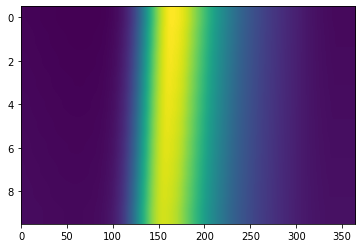

In [152]:
plt.imshow(f_shiftscales, aspect = 'auto')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


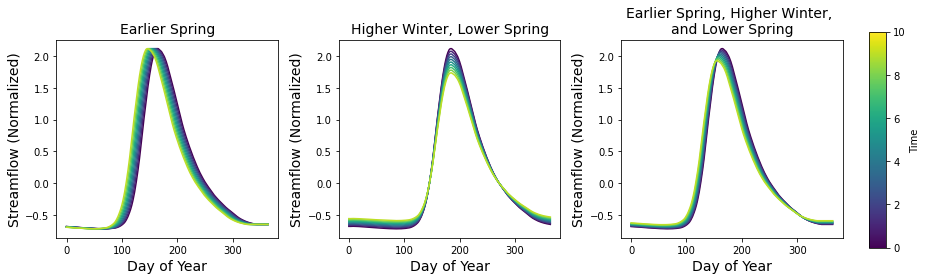

In [153]:
#visualize flow

saveIt = 0

cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = N_steps)

fig, axes = plt.subplots(nrows = 1, ncols =3, figsize = (12,4))

for step in range(N_steps):

  color = cmap(norm(step))
  
  axes[0].plot(f_shifts[step,:], color = color)
  axes[0].set_xlabel('Day of Year', fontsize = fs)
  axes[0].set_ylabel('Streamflow (Normalized)', fontsize = fs)
  axes[0].set_title('Earlier Spring', fontsize = fs)

  axes[1].plot(f_scales[step,:], color = color)
  axes[1].set_xlabel('Day of Year', fontsize = fs)
  axes[1].set_ylabel('Streamflow (Normalized)', fontsize = fs)
  axes[1].set_title('Higher Winter, Lower Spring', fontsize = fs)
  
  axes[2].plot(f_shiftscales[step,:], color = color)
  axes[2].set_xlabel('Day of Year', fontsize = fs)
  axes[2].set_ylabel('Streamflow (Normalized)', fontsize = fs)
  axes[2].set_title('Earlier Spring, Higher Winter, \nand Lower Spring', fontsize = fs)

#add colorbar
width = 0.02
height = 0.75
dh = (1-height)/2
dw = (1-width)/2
ax_cb = fig.add_axes([1.01,dh,width,height])
cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
ax_cb.set_ylabel('Time')

fig.tight_layout()

if saveIt:
  plt.savefig('synthetic_warming_flow.png', dpi = 300, bbox_inches = 'tight')

plt.show()

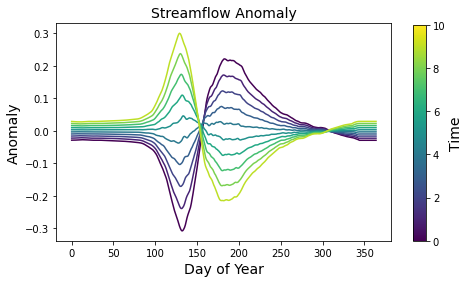

In [154]:
#flow anomaly

saveIt = 0

fig, ax = plt.subplots()
for step in range(N_steps):
  color = cmap(norm(step))
  ax.plot(f_anomaly[step,:], color = color)
ax.set_xlabel('Day of Year', fontsize = fs)
ax.set_ylabel('Anomaly', fontsize = fs)
ax.set_title('Streamflow Anomaly', fontsize = fs)

#add colorbar
width = 0.03
height = 0.75
dh = (1-height)/2
dw = (1-width)/2
ax_cb = fig.add_axes([0.95,dh,width,height])
cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
ax_cb.set_ylabel('Time', fontsize = fs)

if saveIt:
  plt.savefig('synthetic_warming_anomaly.png', dpi = 300, bbox_inches = 'tight')

plt.show()

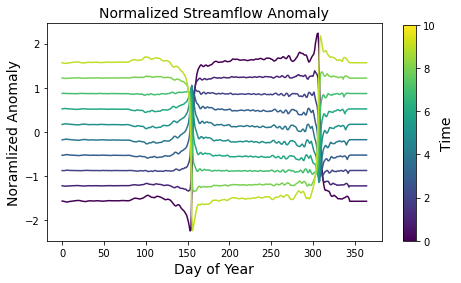

In [155]:
#normalized anomaly

saveIt = 0

fig, ax = plt.subplots()
for step in range(N_steps):
  color = cmap(norm(step))
  # if step == N_steps-1:
  ax.plot(f_anomaly_norm[step,:], color = color)
ax.set_xlabel('Day of Year', fontsize = fs)
ax.set_ylabel('Noramlized Anomaly', fontsize = fs)
ax.set_title('Normalized Streamflow Anomaly', fontsize = fs)

#add colorbar
width = 0.03
height = 0.75
dh = (1-height)/2
dw = (1-width)/2
ax_cb = fig.add_axes([0.95,dh,width,height])
cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
ax_cb.set_ylabel('Time', fontsize = fs)

if saveIt:
  plt.savefig('synthetic_warming_normalized_anomaly9.png', dpi = 300, bbox_inches = 'tight')

plt.show()

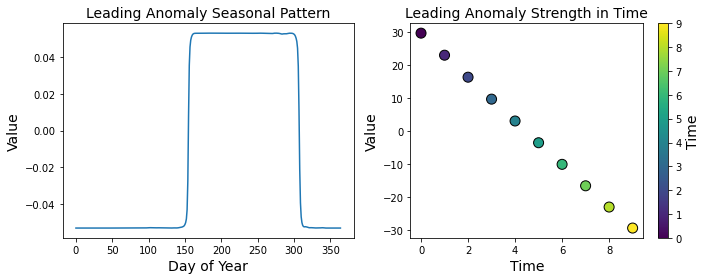

In [156]:
#leading mode of variability

saveIt = 0

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
axes[0].plot(eigvecs_syn[0,:])
axes[0].set_xlabel('Day of Year', fontsize = fs)
axes[0].set_ylabel('Value', fontsize = fs)
axes[0].set_title('Leading Anomaly Seasonal Pattern', fontsize = fs)


cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = N_steps)

s = axes[1].scatter(range(N_shiftscale),PCs_synthetic[:,0], c = range(N_shiftscale), s = 100, edgecolor = 'k', cmap = cmap)
cb = plt.colorbar(s)
cb.ax.set_ylabel('Time', fontsize = fs)
axes[1].set_xlabel('Time', fontsize = fs)
axes[1].set_ylabel('Value', fontsize = fs)
axes[1].set_title('Leading Anomaly Strength in Time', fontsize = fs)

plt.tight_layout()

if saveIt:
  plt.savefig('synthetic_warming_anomaly_mode.png', dpi = 300, bbox_inches = 'tight')

plt.show()

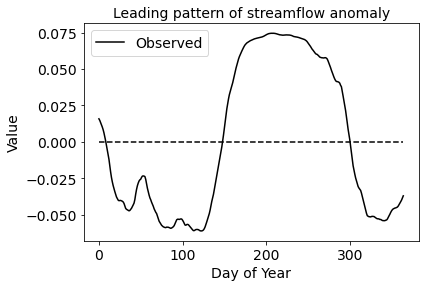

In [167]:
#plot observed mode pattern

saveIt = 1

component = 0

fig, ax = plt.subplots()
ax.plot(eigvecs[component,:], label = 'Observed', color = 'k')
# ax.plot(eigvecs_syn[component,:], label = 'Synthetic')
ax.plot(np.arange(365), np.zeros(365), 'k--')
ax.set_xlabel('Day of Year', fontsize = fs)
ax.set_ylabel('Value', fontsize = fs)
ax.set_title('Leading pattern of streamflow anomaly', fontsize = fs)
ax.tick_params(labelsize = fs)
ax.legend(fontsize = fs)

if saveIt:
  plt.savefig('warming_pattern_obs.png', bbox_inches = 'tight', dpi = 300)

plt.show()

# Emergence of Flow Anomaly Mode

In [ ]:
full_stations = np.arange(len(stationInds))

In [ ]:
np.shape(data_to_format)

(365, 120, 69)

In [ ]:
#do PCA

years_in_PCA = np.array([10,20,30,40,50,60])
years_in_PCA = np.arange(5,68)
eigvecs_warm = np.zeros((len(years_in_PCA), 365))
frac_var_warm = np.zeros(len(years_in_PCA))

#window starting at 1951 and working forward
warming_modes = [1, 2, 2, 1, 0, 0]
scale = [1, 1, -1, 1, 1, 1]

#window starting at 2020 and working backward
warming_modes = [0, 0, 0, 0, 0, 0]
scale = [1, 1, 1, 1, 1, 1]
warming_modes = [0 for kk in range(len(years_in_PCA))]
scale = [1 for kk in range(len(years_in_PCA))]

for jj, Nyears in enumerate(years_in_PCA):

  #fill missing observations with model output, do PCA
  good_cluster_inds = np.argwhere( ((labels==0)|(labels==1)|(labels==5)) & (NSE_modern>=0.7))
  stations_for_PCA = np.squeeze(np.intersect1d(full_stations, good_cluster_inds))

  data_to_format = np.copy(seasonal_window_anomaly_norm[:,stations_for_PCA,:])
  data_to_format_obs = np.copy(seasonal_window_anomaly_norm_obs[:,stations_for_PCA,:])

  Ndays = 365
  Nstations = np.shape(data_to_format)[1]

  PCA_input_mod = np.zeros((Nstations*Nyears, Ndays))
  PCA_input_obs = np.zeros((Nstations*Nyears, Ndays))

  kk = 0
  for station in range(Nstations):
    for year in range(Nyears):
      PCA_input_mod[kk,:] = data_to_format[:,station,-year]
      PCA_input_obs[kk,:] = data_to_format_obs[:,station,-year]
      kk+=1

  PCA_input_obs[np.isinf(PCA_input_obs)] = 0
  PCA_input_obs[np.isnan(PCA_input_obs)] = PCA_input_mod[np.isnan(PCA_input_obs)]
  PCA_input = np.copy(PCA_input_obs)

  #develop PCA on model output (temporally complete)
  n_components = 5#np.min(np.shape(PCA_input))
  pca = PCA(n_components = n_components).fit(PCA_input)
  frac_var = pca.explained_variance_ratio_
  eigvecs = pca.components_

  #model and observations
  PCs = pca.transform(PCA_input)

  eigvecs_warm[jj,:] = eigvecs[warming_modes[jj],:] * scale[jj]
  frac_var_warm[jj] = frac_var[warming_modes[jj]]



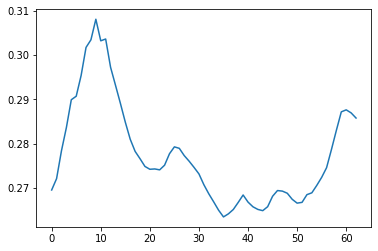

In [ ]:
plt.plot(frac_var_warm)

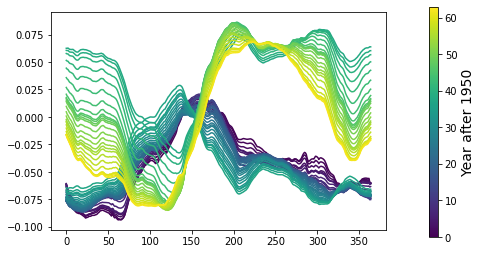

In [ ]:
cmap = cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = len(years_in_PCA))

fig, ax = plt.subplots()

for kk in range(len(years_in_PCA)):
  color = cmap(norm(kk))
  if eigvecs_warm[kk,100]>0:
    eigvecs_warm[kk,:] *= -1
  ax.plot(eigvecs_warm[kk,:], color = color)

width = 0.02
height = 0.8
dh = (1-height)/2
dw = (1-width)/2
ax_cb = fig.add_axes([1.,dh,width,height])
cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
ax_cb.set_ylabel('Year after 1950', fontsize = fs-6)

plt.show()

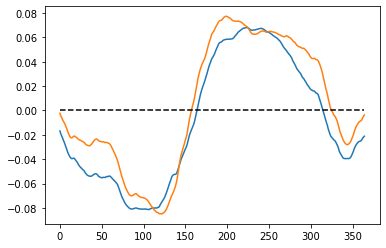

In [ ]:
# plt.plot(eigvecs[0,:].T)
# plt.plot(eigvecs[1,:].T)
plt.plot(eigvecs[0,:].T)
plt.plot(eigvecs_warm[-10,:])
plt.plot(np.arange(365), np.zeros(365), 'k--')
# plt.plot(eigvecs[2,:].T)

plt.show()

ValueError: ignored

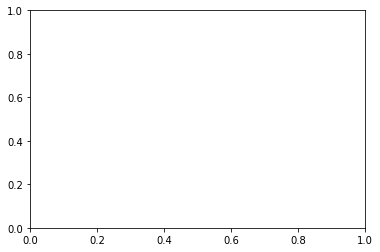

In [ ]:
plt.scatter(np.mean(PCA_input[-years:,:], axis = 1), PCs[:,0])

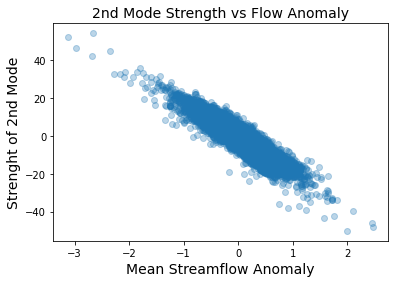

In [ ]:
saveIt = 0

fig, ax = plt.subplots()
ax.scatter(np.mean(PCA_input, axis = 1), PCs[:,1], alpha = 0.3)
ax.set_xlabel('Mean Streamflow Anomaly', fontsize = fs)
ax.set_ylabel('Strenght of 2nd Mode', fontsize = fs)
ax.set_title('2nd Mode Strength vs Flow Anomaly', fontsize = fs)

if saveIt:
  plt.savefig('2nd_mode_PCs.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
PCs_mat = np.zeros((Nyears, Nstations, n_components))
for component in range(n_components):
  PCs_mat[:,:,component] = np.reshape(PCs[:,component], (Nstations,Nyears)).T

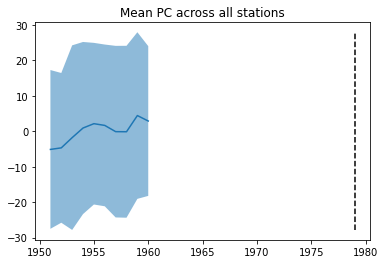

In [ ]:
component = 0

# x1 = np.mean(PCs_mod_mat, axis = -1)
# x1_std = np.std(PCs_mod_mat, axis = -1)

# x2 = np.mean(PCs_obs_mat, axis = -1)
# x2_std = np.std(PCs_obs_mat, axis = -1)

x2 = np.mean(PCs_mat[:,:,component], axis = -1)
x2_std = np.std(PCs_mat[:,:,component], axis = -1)
err = 2*x2_std

yrs = np.arange(1951,1951+Nyears)
plt.plot(yrs, x2)
plt.fill_between(yrs, x2+err, x2-err, alpha = 0.5)
plt.plot([1979, 1979], [np.min(x2-err), np.max(x2+err)], 'k--')
plt.title('Mean PC across all stations')

plt.show()

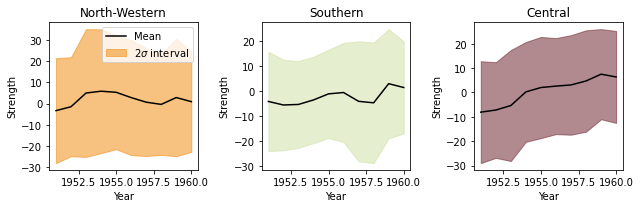

In [ ]:
#PCs by cluster

saveIt = 0

component = 0

nrows = 2
ncols = int(np.ceil(n_clusters_seasonal/nrows))
# fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols,3*nrows))

nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols,3*nrows))
clusters = [0,1,5]
for kk, ax in enumerate(axes.flatten()):

  cluster = clusters[kk]
  inds = np.squeeze(np.argwhere(labels[stations_for_PCA] == cluster))
  # inds = np.squeeze(np.array([np.argwhere(stations_for_PCA==ind) for ind in inds]))

  if np.size(inds) > 0:
    xx = np.mean(PCs_mat[:, inds, component], axis = -1)
    xx_std = np.std(PCs_mat[:,inds, component], axis = -1)
    err = 1*xx_std
    
    ax.plot(yrs, xx, 'k', label = 'Mean')
    # ax.fill_between(yrs, xx+err, xx-err, alpha = 0.5, color = rgbas_array[cluster,:])
    ax.fill_between(yrs, xx+2*err, xx-2*err, alpha = 0.5, color = rgbas_array[cluster,:], label = '2$\sigma$ interval')

    if kk == 0:
      ax.legend()

  
  ax.set_xlabel('Year')
  ax.set_ylabel('Strength')
  ax.set_title(cluster_names[cluster])

plt.tight_layout()

if saveIt:
  plt.savefig('PCs_by_cluster.png', bbox_inches = 'tight', dpi = 300)

# Extra BS lives below here

# Trend in freshet: Model

In [ ]:
y_predict = np.vstack([y_hind_predict, y_modern_predict])
eraDate = list(np.hstack([eraDate_hind, eraDate_modern]))
stations = range(len(stationInds))

In [ ]:
# #OLD: calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

# Nyears = int(len(y_predict)/365) + 1
# Nstations = len(stations)

# q_peak = np.zeros((Nyears,Nstations))
# t_peak = np.zeros((Nyears,Nstations))
# t_half = np.zeros((Nyears,Nstations))

# for kk, station in enumerate(stations):
#   year = 1951
#   for hh in range(Nyears):

#     if year != 1979:

#       start = datetime(year,1,1)
#       fin = start + timedelta(365)
#       start_ind = eraDate.index(start)
#       if (year == 1978) | (year == 2015):
#         fin = start + timedelta(364)
#       fin_ind = eraDate.index(fin)

#       q = np.squeeze(np.copy(y_predict[start_ind:fin_ind, station]))
#       q = np.asarray(pd.Series(q).rolling(window = 30, min_periods = 1).mean())
#       q -= np.min(q)

#       maxima = np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True] #true if local maxima -- use local maxima since global maxima may find precip peak, not freshet peak
#       maxima_ind = np.squeeze(np.argwhere(maxima == True)) #indices of local maxima
#       maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]
#       if len(maxima_ind.reshape(-1,1)) == 0:
#         maxima_ind = np.argmax(q)

#       maxima_ind = np.argmax(q)

      

#       t_peak[hh,kk] = np.min(maxima_ind)

#       q_peak[hh,kk] = q[int(t_peak[hh,kk])]
#       qq = q - 0.5*q_peak[hh,kk]

#       # OLD: t_half[hh,kk] = np.min( np.argsort( np.abs(qq) )[:20] )#np.min(np.argwhere(np.abs(qq) < 0.1))

#       # t_half[hh,kk] = np.min( np.argwhere( (np.argsort( np.abs(qq) )[:20]) > 20 ) )

#       earliest_freshet_day = 40 #prevent early-winter artifacts from triggering freshet detection

#       if t_peak[hh,kk] > earliest_freshet_day:

#         q_until_peak = q[:int(t_peak[hh,kk])]
#         q_until_peak[:earliest_freshet_day] = np.min(q_until_peak)

#         qq = q_until_peak - 0.25*q_peak[hh,kk]
#         t_half[hh,kk] = np.argsort(np.abs(qq))[0]
    
#     year+=1

# #remove 1979
# t_half = np.delete(t_half, 28, 0)
# t_peak = np.delete(t_peak, 28, 0)
# years = np.delete(np.arange(1951, 2016), 28,0)

In [ ]:
Nyears

69

In [ ]:
#NEW: calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

Nyears = int(len(y_predict)/365) #+ 1
Nstations = len(stations)

q_peak = np.zeros((Nyears,Nstations))
t_peak = np.zeros((Nyears,Nstations))
t_half = np.zeros((Nyears,Nstations))

for kk, station in enumerate(stations):
  year = 1951
  for hh in range(Nyears):

    if year != 1979:

      start = datetime(year,1,1)
      fin = start + timedelta(365)
      start_ind = eraDate.index(start)
      if (year == 1978) | (year == 2015):
        fin = start + timedelta(364)
      fin_ind = eraDate.index(fin)

      # q = np.squeeze(np.copy(y_predict[start_ind:fin_ind, station]))
      # q = np.asarray(pd.Series(q).rolling(window = 30, min_periods = 1).mean())
      # q -= np.min(q)

      q = np.squeeze(np.copy(seasonal_window[:,station,hh]))
      q -= np.min(q)

      # maxima = np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True] #true if local maxima -- use local maxima since global maxima may find precip peak, not freshet peak
      # maxima_ind = np.squeeze(np.argwhere(maxima == True)) #indices of local maxima
      # maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]
      # if len(maxima_ind.reshape(-1,1)) == 0:
      #   maxima_ind = np.argmax(q)

      maxima_ind = np.argmax(q)

      t_peak[hh,kk] = np.min(maxima_ind)

      q_peak[hh,kk] = q[int(t_peak[hh,kk])]

      q_peak_seas = np.max(flowseason_norm[kk,:])

      earliest_freshet_day = 90 #prevent early-winter artifacts from triggering freshet detection

      if t_peak[hh,kk] > earliest_freshet_day:

        q_until_peak = q[:int(t_peak[hh,kk])]
        q_until_peak[:earliest_freshet_day] = np.min(q_until_peak)

        qq = q_until_peak - 0.25*q_peak_seas#[hh,kk]
        qq = q_until_peak - 0.25*q_peak[hh,kk]
        t_half[hh,kk] = np.argsort(np.abs(qq))[0]
        # t_half[hh,kk] = np.min(np.argsort(np.abs(qq))[:5])

    year+=1

# #remove 1979
# t_half = np.delete(t_half, 28, 0)
# t_peak = np.delete(t_peak, 28, 0)
# years = np.delete(np.arange(1951, 2016), 28,0)

In [ ]:
# #NEW NEW: calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

# Nyears = int(len(y_predict)/365) + 1
# Nstations = len(stations)

# q_peak = np.zeros((Nyears,Nstations))
# t_peak = np.zeros((Nyears,Nstations))
# t_half = np.zeros((Nyears,Nstations))

# for kk, station in enumerate(stations): #for each station
#   year = 1951
#   for hh in range(Nyears-10): #for each year
    
#     q = np.zeros(364)

#     for ii in range(10): #for each year in a 10-year window past the current year

#       if year+ii != 1979:

#         start = datetime(year+ii,1,1)
#         fin = start + timedelta(365)
#         start_ind = eraDate.index(start)
#         if (year+ii == 1978) | (year+ii == 2015):
#           fin = start + timedelta(364)
#         fin_ind = eraDate.index(fin)

#         qii = np.squeeze(np.copy(y_predict[start_ind:fin_ind, station]))[:364]
#         qii = np.asarray(pd.Series(qii).rolling(window = 30, min_periods = 1).mean())
#         qii -= np.min(qii)

#         q += qii[:364]

#     maxima_ind = np.argmax(q)

#     t_peak[hh,kk] = np.min(maxima_ind)

#     q_peak[hh,kk] = q[int(t_peak[hh,kk])]

#     q_peak_seas = np.max(flowseason_norm[kk,:])

#     earliest_freshet_day = 90 #prevent early-winter artifacts from triggering freshet detection

#     if t_peak[hh,kk] > earliest_freshet_day:

#       q_until_peak = q[:int(t_peak[hh,kk])]
#       q_until_peak[:earliest_freshet_day] = np.min(q_until_peak)

#       qq = q_until_peak - 0.25*q_peak_seas#[hh,kk]
#       qq = q_until_peak - 0.25*q_peak[hh,kk]
#       t_half[hh,kk] = np.argsort(np.abs(qq))[0]
#       # t_half[hh,kk] = np.min(np.argsort(np.abs(qq))[:5])

#     year+=1

#remove 1979
t_half = np.delete(t_half, 28, 0)
t_peak = np.delete(t_peak, 28, 0)
years = np.delete(np.arange(1951, 2016), 28,0)

In [ ]:
np.shape(t_half)

(68, 265)

In [ ]:
# t_half = t_half[:-10,:]

In [ ]:
dt = t_peak - t_half

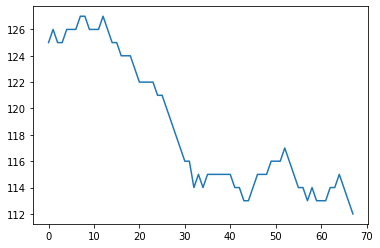

In [ ]:
plt.plot(t_half[:,110])

plt.show()

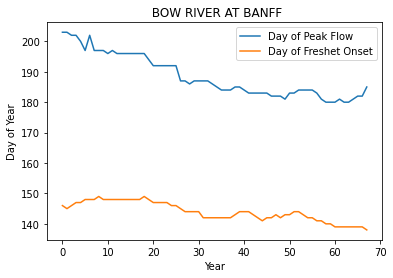

In [ ]:
saveIt = 0

ind = 157

plt.plot(t_peak[:,ind], label = 'Day of Peak Flow')
plt.plot(t_half[:,ind], label = 'Day of Freshet Onset')
plt.title(stationNames[ind])
plt.xlabel('Year')
plt.ylabel('Day of Year')
plt.legend()

if saveIt:
  plt.savefig('tpeak_thalf_example.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
#Mann-Kendall trends of modelled peak and freshet timing

freshet_trend_mod = np.zeros(len(stationInds))
freshet_p_mod = np.zeros(len(stationInds))

peak_trend_mod = np.zeros(len(stationInds))
peak_p_mod = np.zeros(len(stationInds))

for station in range(len(stationInds)):

  MK = mk.original_test(t_half[:,station])
  freshet_trend_mod[station] = MK.slope
  freshet_p_mod[station] = MK.p

  MK = mk.original_test(t_peak[:,station])
  peak_trend_mod[station] = MK.slope
  peak_p_mod[station] = MK.p

print(len(np.argwhere(freshet_p_mod < 0.1)))
print(len(np.argwhere(peak_p_mod < 0.1)))
print(np.median(freshet_trend_mod))
print(np.median(peak_trend_mod))


257
244
-0.16666666666666666
-0.15


In [ ]:
full_stations = np.squeeze(np.argwhere((labels==0)|(labels==1)|(labels==5)))

In [ ]:
#create cluster input

cluster_input = t_peak.T
cluster_input = t_half[:,full_stations].T - np.expand_dims(np.mean(t_half[:,full_stations], axis = 0), axis = 1)
# cluster_input = t_half.T

In [ ]:
for obs in range(len(cluster_input)):
  cluster_input[obs,:] = (cluster_input[obs,:] - np.mean(cluster_input[obs,:])) / np.std(cluster_input[obs,:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
np.shape(cluster_input)

(171, 68)

In [ ]:
cluster_names

['North-Western', 'Southern', 'North-Eastern', 'Coastal', 'Eastern', 'Central']

In [ ]:
cluster_input[np.isnan(cluster_input)] = 0

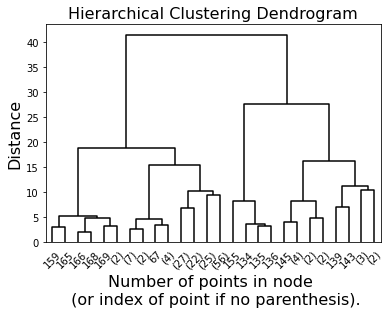

In [ ]:
#visualize dendrogram to inform number of clusters

saveIt = 0 #if save figure as a PNG file
saveEPS = 0 #if save figures as an EPS file

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)


# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

# plot line showing where we cut and choose clusters
# cutoff = 100
# linemin = 30
# linemax = 310
# plt.plot([linemin,linemax],[cutoff,cutoff], color = 'gray', linestyle = '--', linewidth = 3)

plt.xlabel("Number of points in node \n (or index of point if no parenthesis).", fontsize = 16)
plt.ylabel('Distance', fontsize = 16)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 16)

if saveIt: 
  plt.savefig('dendrogram_freshet_mod.png', dpi = 200, bbox_inches = 'tight')
if saveEPS:
  plt.savefig('dendrogram_freshet_mod.eps', format = 'eps', bbox_inches='tight')

plt.show()

In [ ]:
#from dendrogram, choose number of clusters and calculate mean pattern of each cluster

n_clusters_freshet = 6
freshet_clustering = AgglomerativeClustering(n_clusters = n_clusters_freshet).fit(cluster_input)

#calculate average of each cluster
freshet_cluster_patterns = np.empty((n_clusters_freshet, np.shape(cluster_input)[1]))
for cluster in range(n_clusters_freshet):
  cluster_inds = np.argwhere(freshet_clustering.labels_ == cluster)
  freshet_cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

In [ ]:
#details for plotting/visualizations 

#colours of each station
cStations_freshet = np.empty((len(cluster_input), 3))
for kk in range(len(cluster_input)):
  cStations_freshet[kk,:] = rgbs[freshet_clustering.labels_[kk]]
cStations_freshet /= 256

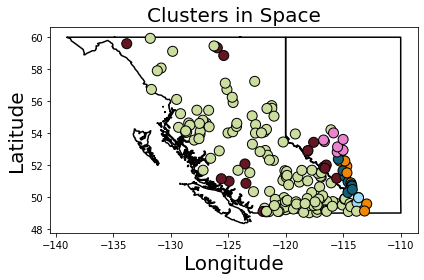

In [ ]:
#freshet patterns in space

saveIt = 0
saveEPS = 0

fs = 20 #fontsize

fig, ax = plt.subplots()

plot_prov_ax(prov=prov, ax = ax)
ax.scatter(stationLon[stationInds[full_stations]], 
           stationLat[stationInds[full_stations]], 
           c = cStations_freshet,#[full_stations], 
           s = 100, 
           linewidth = 1, 
           edgeColor = 'k', 
           zOrder = 3)
ax.set_xlabel('Longitude', fontsize = fs)
ax.set_ylabel('Latitude', fontsize = fs)
ax.set_title('Clusters in Space', fontsize = fs)

plt.tight_layout()

plt.show()

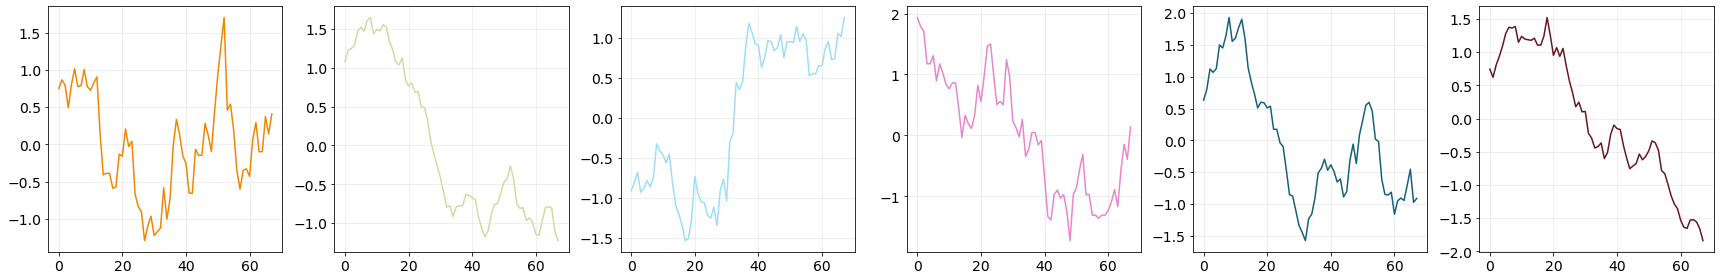

In [ ]:
#freshet patterns in time

nrows = 1
ncols = n_clusters_freshet

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols, 4*nrows))

for cluster, ax in enumerate(axes.flatten()):

  cluster_inds = np.squeeze(np.argwhere(freshet_clustering.labels_ == cluster))
  # ax.plot(cluster_input[cluster_inds,:365].T, linewidth = 0.25, alpha = 0.5, color = 'gray')
  # ax.plot(cluster_patterns[cluster,:365], color = rgbs_array[cluster], linewidth = 3)
  ax.plot(np.mean(cluster_input[cluster_inds,:], axis = 0), color = rgbas_array[cluster,:])
  ax.tick_params(labelsize = fs - 6)
  ax.grid(True, alpha = 0.25)

plt.tight_layout()

In [ ]:
# freshet_trend_mod = np.zeros(len(stationInds))

# for station in range(len(stationInds)):
#   yy = t_half[:,station].reshape(-1,1)
#   xx = np.arange(len(yy)).reshape(-1,1)
#   lm = LinearRegression().fit(X = xx, y = yy)
#   freshet_trend_mod[station] = lm.coef_

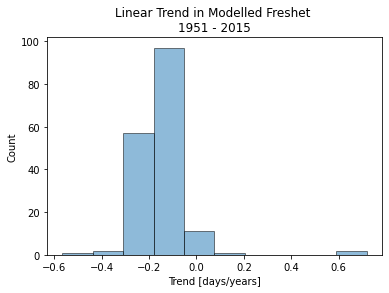

In [ ]:
saveIt = 0

plt.hist(freshet_trend_mod[full_stations], edgecolor = 'k', alpha = 0.5)
# sns.kdeplot(freshet_trend_mod[full_stations], alpha = 0.5)
plt.xlabel('Trend [days/years]')
plt.ylabel('Count')
plt.title('Linear Trend in Modelled Freshet \n1951 - 2015')

if saveIt:
  plt.savefig('freshet_trend_hist.png', bbox_inches = 'tight', dpi = 300)


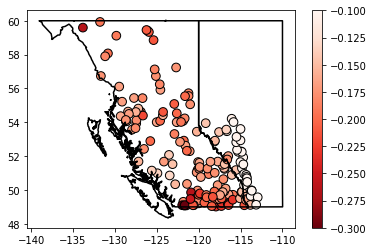

In [ ]:
saveIt = 0

vmin = -0.25#np.sort(freshet_trend_mod)[1]
vmax = 0

vmin = -0.3#np.sort(freshet_trend_mod)[0]
vmax = -0.1#np.sort(freshet_trend_mod)[-6]


fig, ax = plt.subplots()

plot_prov_ax(prov = prov, ax = ax)
plt.scatter(stationLon[stationInds][full_stations], 
            stationLat[stationInds][full_stations], 
            c = freshet_trend_mod[full_stations], 
            edgecolor = 'k',
            s = 75,
            cmap = 'Reds_r', 
            vmin = vmin, 
            vmax = vmax
            )
# plt.scatter(stationLon[stationInds][full_glaciers], stationLat[stationInds][full_glaciers], c = freshet_trend_mod[full_glaciers], vmin = vmin, vmax = vmax)
plt.colorbar()

if saveIt:
  plt.savefig('freshet_trend_map.png', bbox_inches = 'tight', dpi = 300)


# Trend in freshet: Observations

In [ ]:
#OLD: calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

years = int(len(F_long)/365) + 1
Nstations = len(stations)
Nstations = len(stationInds)

q_peak_obs = np.zeros((Nyears,Nstations))
t_peak_obs = np.zeros((Nyears,Nstations))
t_half_obs = np.zeros((Nyears,Nstations))

for station in stations:

  if hind_missing[station] < frac_max_missing_data:

    year = 1951
    
    for hh in range(Nyears):

      if year != 1979:

        start = datetime(year,1,1)
        fin = start + timedelta(365)
        start_ind = flowDate_long.index(start)
        if (year == 1978) | (year == 2015):
          fin = start + timedelta(364)
        fin_ind = flowDate_long.index(fin)

        q = np.squeeze(np.copy(F_long[start_ind:fin_ind, station]))
        q = q[1:]
        q -= np.nanmean(q)
        q /= np.nanstd(q)
        q = np.asarray(pd.Series(q).rolling(window = 60, min_periods = 1).mean())
        q -= np.nanmin(q)

        # maxima = np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True] #true if local maxima -- use local maxima since global maxima may find precip peak, not freshet peak
        # maxima_ind = np.squeeze(np.argwhere(maxima == True)) #indices of local maxima
        # print(len(q[maxima_ind]))
        # # maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]
        # if len(maxima_ind.reshape(-1,1)) == 1:#0:
        #   maxima_ind = np.argmax(q)
        # else:
        #   maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]

        if len(np.argwhere(np.isnan(q))) != len(q): #if not all missing

          maxima_ind = np.nanargmax(q)

          t_peak_obs[hh,station] = np.min(maxima_ind)

          q_peak_obs[hh,station] = q[int(t_peak_obs[hh,station])]
          # qq = q - 0.5*q_peak_obs[hh,station]
          # t_half_obs[hh,station] = np.nanmin(np.argsort(np.abs(qq))[:30])#np.min(np.argwhere(np.abs(qq) < 0.2))


          earliest_freshet_day = 90 #prevent early-winter artifacts from triggering freshet detection

          if t_peak_obs[hh,station] > earliest_freshet_day:
          
            q_until_peak = q[:int(t_peak_obs[hh,station])]
            q_until_peak[:earliest_freshet_day] = np.nanmin(q_until_peak)

            qq = q_until_peak - 0.25*q_peak_obs[hh,station]
            t_half_obs[hh,station] = np.argsort(np.abs(qq))[0]

      year+=1

#set missing years from 0 to nan
for station in stations:
  t_half_obs[np.argwhere(t_half_obs[:,station]==0), station] = np.nan

#remove 1979
t_half_obs = np.delete(t_half_obs, 28, 0)
t_peak_obs = np.delete(t_peak_obs, 28, 0)
years_long = np.delete(np.arange(1951, 2016), 28, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#NEW: calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

years = int(len(F_long)/365) + 1
Nstations = len(stations)
Nstations = len(stationInds)

q_peak_obs = np.zeros((Nyears,Nstations))
t_peak_obs = np.zeros((Nyears,Nstations))
t_half_obs = np.zeros((Nyears,Nstations))

for station in stations:

  if hind_missing[station] < frac_max_missing_data:

    year = 1951
    
    for hh in range(Nyears):

      if year != 1979:

        start = datetime(year,1,1)
        fin = start + timedelta(365)
        start_ind = flowDate_long.index(start)
        if (year == 1978) | (year == 2015):
          fin = start + timedelta(364)
        fin_ind = flowDate_long.index(fin)

        # q = np.squeeze(np.copy(F_long[start_ind:fin_ind, station]))
        # q = q[1:]
        # q -= np.nanmean(q)
        # q /= np.nanstd(q)
        # q = np.asarray(pd.Series(q).rolling(window = 30, min_periods = 1).mean())
        # q -= np.nanmin(q)

        q = np.squeeze(np.copy(seasonal_window_obs[:,station,hh]))
        q -= np.nanmin(q)

        # maxima = np.r_[True, q[1:] > q[:-1]] & np.r_[q[:-1] > q[1:], True] #true if local maxima -- use local maxima since global maxima may find precip peak, not freshet peak
        # maxima_ind = np.squeeze(np.argwhere(maxima == True)) #indices of local maxima
        # print(len(q[maxima_ind]))
        # # maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]
        # if len(maxima_ind.reshape(-1,1)) == 1:#0:
        #   maxima_ind = np.argmax(q)
        # else:
        #   maxima_ind = maxima_ind[np.squeeze(np.argwhere(q[maxima_ind] > 0.5*(np.max(q))))]

        if len(np.argwhere(np.isnan(q))) != len(q): #if not all missing

          maxima_ind = np.nanargmax(q)

          t_peak_obs[hh,station] = np.min(maxima_ind)

          q_peak_obs[hh,station] = q[int(t_peak_obs[hh,station])]

          q_peak_obs_seas = np.max(flowseason_norm[station,:])
          # qq = q - 0.5*q_peak_obs[hh,station]
          # t_half_obs[hh,station] = np.nanmin(np.argsort(np.abs(qq))[:30])#np.min(np.argwhere(np.abs(qq) < 0.2))


          earliest_freshet_day = 90 #prevent early-winter artifacts from triggering freshet detection

          if t_peak_obs[hh,station] > earliest_freshet_day:
          
            q_until_peak = q[:int(t_peak_obs[hh,station])]
            q_until_peak[:earliest_freshet_day] = np.nanmin(q_until_peak)

            qq = q_until_peak - 0.25*q_peak_obs_seas#[hh,station]
            qq = q_until_peak - 0.25*q_peak_obs[hh,station]
            t_half_obs[hh,station] = np.argsort(np.abs(qq))[0]
            # t_half_obs[hh,station] = np.min(np.argsort(np.abs(qq))[:5])

      year+=1

#set missing years from 0 to nan
for station in stations:
  t_half_obs[np.argwhere(t_half_obs[:,station]==0), station] = np.nan

#remove 1979
t_half_obs = np.delete(t_half_obs, 28, 0)
t_peak_obs = np.delete(t_peak_obs, 28, 0)
years_long = np.delete(np.arange(1951, 2016), 28, 0)

#set missing years from 0 to nan
for station in stations:
  t_half_obs[np.argwhere(t_half_obs[:,station]==0), station] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: All-NaN slice encountered


In [ ]:
full_stations

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  84,  85,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 167, 168, 170, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 210, 211, 212, 213, 214, 215, 216, 219,
       220, 244])

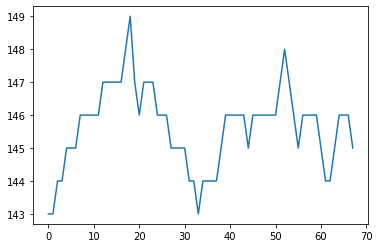

In [ ]:
plt.plot(t_half_obs[:,157])

In [ ]:
#postprocess by removing outliers

for station in range(len(stationInds)):
  sigma = np.nanstd(t_half_obs[:,station])
  mu = np.nanmean(t_half_obs[:,station])
  zs = (t_half_obs[:,station] - mu) / sigma
  outlier_inds = np.squeeze(np.argwhere(np.abs(zs) > 2))
  t_half_obs[outlier_inds, station] = np.nan
  # print(np.nanmax(np.abs(zs)))

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
np.size(outlier_inds)

0

In [ ]:
# #NEW NEW: calculate the timing of freshet: day reaches (Q_max - Q_min) / 2

# years = int(len(F_long)/365) + 1
# Nstations = len(stations)
# Nstations = len(stationInds)

# q_peak_obs = np.zeros((Nyears,Nstations))
# t_peak_obs = np.zeros((Nyears,Nstations))
# t_half_obs = np.zeros((Nyears,Nstations))

# for station in stations:

#   if hind_missing[station] < frac_max_missing_data:

#     year = 1951

#     qiis = np.zeros((10,363))
#     for hh in range(Nyears-10):
    
#       # q = np.zeros(363)

#       for ii in range(10):

#         if year+ii != 1979:

#           start = datetime(year+ii,1,1)
#           fin = start + timedelta(365)
#           start_ind = eraDate.index(start)
#           if (year+ii == 1978) | (year+ii == 2015):
#             fin = start + timedelta(364)
#           fin_ind = eraDate.index(fin)

#           # qii = np.squeeze(np.copy(y_predict[start_ind:fin_ind, station]))[:364]
#           # qii = np.asarray(pd.Series(qii).rolling(window = 30, min_periods = 1).mean())
#           # qii -= np.min(qii)

#           qii = np.squeeze(np.copy(F_long[start_ind:fin_ind, station]))
#           qii = qii[1:]
#           qii -= np.nanmean(qii)
#           qii /= np.nanstd(qii)
#           qii = np.asarray(pd.Series(qii).rolling(window = 30, min_periods = 1).mean())
#           qii -= np.nanmin(qii)

#           qiis[ii,:] = qii[:363]

#       q = np.nanmean(qiis, axis = 0)

#       maxima_ind = np.argmax(q)

#     # for hh in range(Nyears):

#     #   if year != 1979:

#     #     start = datetime(year,1,1)
#     #     fin = start + timedelta(365)
#     #     start_ind = flowDate_long.index(start)
#     #     if (year == 1978) | (year == 2015):
#     #       fin = start + timedelta(364)
#     #     fin_ind = flowDate_long.index(fin)

#     #     q = np.squeeze(np.copy(F_long[start_ind:fin_ind, station]))
#     #     q = q[1:]
#     #     q -= np.nanmean(q)
#     #     q /= np.nanstd(q)
#     #     q = np.asarray(pd.Series(q).rolling(window = 30, min_periods = 1).mean())
#     #     q -= np.nanmin(q)


#       if len(np.argwhere(np.isnan(q))) != len(q): #if not all missing

#         maxima_ind = np.nanargmax(q)

#         t_peak_obs[hh,station] = np.min(maxima_ind)

#         q_peak_obs[hh,station] = q[int(t_peak_obs[hh,station])]

#         q_peak_obs_seas = np.max(flowseason_norm[station,:])
#         # qq = q - 0.5*q_peak_obs[hh,station]
#         # t_half_obs[hh,station] = np.nanmin(np.argsort(np.abs(qq))[:30])#np.min(np.argwhere(np.abs(qq) < 0.2))


#         earliest_freshet_day = 90 #prevent early-winter artifacts from triggering freshet detection

#         if t_peak_obs[hh,station] > earliest_freshet_day:
        
#           q_until_peak = q[:int(t_peak_obs[hh,station])]
#           q_until_peak[:earliest_freshet_day] = np.nanmin(q_until_peak)

#           qq = q_until_peak - 0.25*q_peak_obs_seas#[hh,station]
#           qq = q_until_peak - 0.25*q_peak_obs[hh,station]
#           t_half_obs[hh,station] = np.argsort(np.abs(qq))[0]
#           # t_half_obs[hh,station] = np.min(np.argsort(np.abs(qq))[:5])

#       year+=1

# #set missing years from 0 to nan
# for station in stations:
#   t_half_obs[np.argwhere(t_half_obs[:,station]==0), station] = np.nan

# #remove 1979
# t_half_obs = np.delete(t_half_obs, 28, 0)
# t_peak_obs = np.delete(t_peak_obs, 28, 0)
# years_long = np.delete(np.arange(1951, 2016), 28, 0)

# #set missing years from 0 to nan
# for station in stations:
#   t_half_obs[np.argwhere(t_half_obs[:,station]==0), station] = np.nan

In [ ]:
# t_half_obs = t_half_obs[:-10,:]

In [ ]:
cluster_inds = np.squeeze(np.argwhere(labels == 6))
inds = np.intersect1d(full_stations,cluster_inds)
inds

array([ 13,  14,  15, 137, 138, 140, 141, 144])

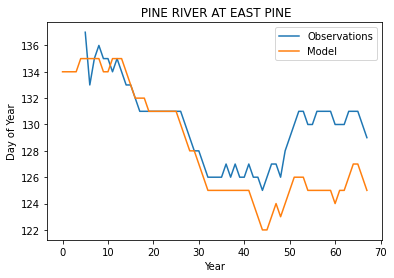

In [ ]:
saveIt = 0

station = 157
station = 6
stationName = stationNames[station]
station_long = np.squeeze(np.argwhere([name.startswith(stationName) for name in stationNames_long]))

plt.plot(t_half_obs[:,station], label = 'Observations')
plt.plot(t_half[:,station], label = 'Model')
plt.title(stationName)
plt.xlabel('Year')
plt.ylabel('Day of Year')
plt.legend()

if saveIt:
  plt.savefig('Bow_river_freshet_mod_obs.png', bbox_inches = 'tight', dpi = 300)


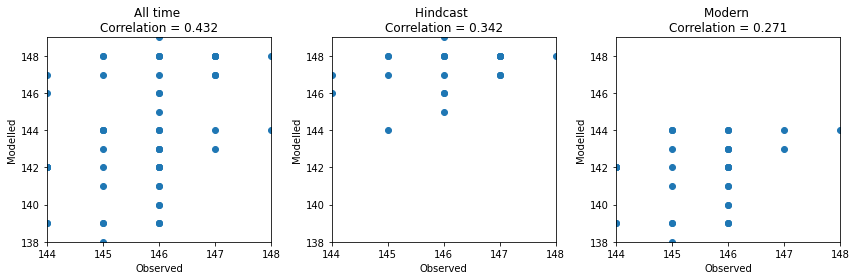

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

Nyears_hind = len(np.arange(1951,1979))

# all time
xx = t_half_obs[:,station]
yy = t_half[:,station]
df = pd.DataFrame({'x' : xx, 'y' : yy})
corr = df.corr(method = 'spearman')['x']['y']
axes[0].scatter(xx, yy)
axes[0].set_title('All time \nCorrelation = ' + str(np.round(corr, decimals = 3)))
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Modelled')
axes[0].set_xlim((np.nanmin(t_half_obs[:,station]), np.nanmax(t_half_obs[:,station])))
axes[0].set_ylim((np.nanmin(t_half[:,station]), np.nanmax(t_half[:,station])))

# hindcast
xx = t_half_obs[:Nyears_hind,station]
yy = t_half[:Nyears_hind,station]
df = pd.DataFrame({'x' : xx, 'y' : yy})
corr = df.corr(method = 'spearman')['x']['y']
axes[1].scatter(xx, yy)
axes[1].set_title('Hindcast \nCorrelation = ' + str(np.round(corr, decimals = 3)))
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Modelled')
axes[1].set_xlim((np.nanmin(t_half_obs[:,station]), np.nanmax(t_half_obs[:,station])))
axes[1].set_ylim((np.nanmin(t_half[:,station]), np.nanmax(t_half[:,station])))

# modern
xx = t_half_obs[Nyears_hind:,station]
yy = t_half[Nyears_hind:,station]
df = pd.DataFrame({'x' : xx, 'y' : yy})
corr = df.corr(method = 'spearman')['x']['y']
axes[2].scatter(xx, yy)
axes[2].set_title('Modern \nCorrelation = ' + str(np.round(corr, decimals = 3)))
axes[2].set_xlabel('Observed')
axes[2].set_ylabel('Modelled')
axes[2].set_xlim((np.nanmin(t_half_obs[:,station]), np.nanmax(t_half_obs[:,station])))
axes[2].set_ylim((np.nanmin(t_half[:,station]), np.nanmax(t_half[:,station])))

plt.tight_layout()

plt.show()

In [ ]:
data_begins = np.zeros(len(stationInds))
for station in range(len(stationInds)):
  missing_years = np.squeeze(np.argwhere(np.isnan(t_half_obs[:,station])))

  if np.size(missing_years) > 0: #if there are missing years

    if np.size(missing_years) > 1: #if multiple missing years

      dmissing_years = missing_years[1:] - missing_years[:-1] #years between subsequent missing years

      if np.max(dmissing_years) > 1: #if there are multi-year gaps between missing years, find last year of the earlier missing period

        last_missing_year_early = np.min(np.argwhere(dmissing_years>1))
        data_begins[station] = last_missing_year_early + 1

      else: #if there are no multi-year gaps
        data_begins[station] = np.max(missing_years)

    else: #if there is only the one missing year
      if missing_years != 63:
        data_begins[station] = np.max(missing_years)

In [ ]:
# calculate hindcast and modern correlations between measured/modelled freshet time

freshet_corr_hind = np.zeros(len(stationInds))
freshet_corr_modern = np.zeros(len(stationInds))

Nyears_hind = len(range(1951,1979))
Nyears_modern = len(range(1980,2016))

for station in stations:

  if hind_missing[station] < frac_max_missing_data:

    df = pd.DataFrame({'x' : t_half_obs[:Nyears_hind, station], 'y' : t_half[:Nyears_hind, station]})
    freshet_corr_hind[station] = df.corr(method='spearman')['x']['y']

    df = pd.DataFrame({'x' : t_half_obs[Nyears_hind:, station], 'y' : t_half[Nyears_hind:, station]})
    freshet_corr_modern[station] = df.corr(method='spearman')['x']['y']

d_freshet_corr = freshet_corr_hind - freshet_corr_modern

In [ ]:
#Mann-Kendall trends of observed peak and freshet timing

freshet_trend_obs = np.zeros(len(stationInds))
freshet_p_obs = np.zeros(len(stationInds))
freshet_tau_obs = np.zeros(len(stationInds))

peak_trend_obs = np.zeros(len(stationInds))
peak_p_obs = np.zeros(len(stationInds))
peak_tau_obs = np.zeros(len(stationInds))

for station in range(len(stationInds)):

  if station in full_stations:

    # MK = mk.original_test(t_half_obs[int(data_begins[station]):,station])
    MK = mk.original_test(t_half_obs[:,station])
    freshet_trend_obs[station] = MK.slope
    freshet_p_obs[station] = MK.p
    freshet_tau_obs[station] = MK.Tau

    # MK = mk.original_test(t_peak_obs[int(data_begins[station]):,station])
    MK = mk.original_test(t_peak_obs[29:,station])
    peak_trend_obs[station] = MK.slope
    peak_p_obs[station] = MK.p
    peak_tau_obs[station] = MK.Tau

print(len(np.argwhere(freshet_p_mod < 0.1)))
print(len(np.argwhere(peak_p_mod < 0.1)))
print(np.median(freshet_trend_obs[full_stations]))
print(np.median(peak_trend_obs[full_stations]))
print(np.median(freshet_tau_obs[full_stations]))

ZeroDivisionError: ignored

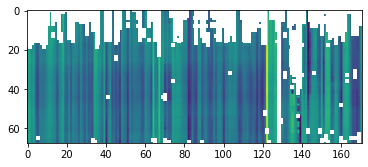

In [ ]:
plt.imshow(t_half_obs[:,full_stations])

In [ ]:
np.shape(t_half_obs), station, t_half_obs[:,station]

((68, 265),
 85,
 array([117., 121., 119., 119., 120., 121., 119., 126., 130., 129., 130.,
        128., 131., 132., 132., 132., 132., 131., 132., 131., 131., 131.,
        130., 131., 128., 128., 128., 125., 120., 118., 117., 115., 112.,
        112., 110., 110., 110., 111., 111., 111., 109., 105., 106., 105.,
        106., 105., 112., 115., 117., 119., 119., 118., 119., 120., 118.,
        118., 118., 117., 117., 116., 116., 118., 117., 120., 121., 121.,
        112.,  nan]))

In [ ]:
#Mann-Kendall trends of modelled peak and freshet timing, just over period when observations are present

freshet_trend_mod = np.zeros(len(stationInds))
freshet_p_mod = np.zeros(len(stationInds))
freshet_tau_mod = np.zeros(len(stationInds))

peak_trend_mod = np.zeros(len(stationInds))
peak_p_mod = np.zeros(len(stationInds))
peak_tau_mod = np.zeros(len(stationInds))

for station in range(len(stationInds)):

  if station in full_stations:

    MK = mk.original_test(t_half[int(data_begins[station]):,station])
    # MK = mk.original_test(t_half[29:,station])
    freshet_trend_mod[station] = MK.slope
    freshet_p_mod[station] = MK.p
    freshet_tau_mod[station] = MK.Tau

    MK = mk.original_test(t_peak[int(data_begins[station]):,station])
    # MK = mk.original_test(t_peak[29:,station])
    peak_trend_mod[station] = MK.slope
    peak_p_mod[station] = MK.p
    peak_tau_obs[station] = MK.Tau

print(len(np.argwhere(freshet_p_mod < 0.1)))
print(len(np.argwhere(peak_p_mod < 0.1)))
print(np.median(freshet_trend_mod))
print(np.median(peak_trend_mod))


ZeroDivisionError: ignored

In [ ]:
d_freshet_trend = freshet_trend_mod - freshet_trend_obs
d_freshet_corr = freshet_corr_hind - freshet_corr_modern

d_freshet_tau = freshet_tau_mod - freshet_tau_obs

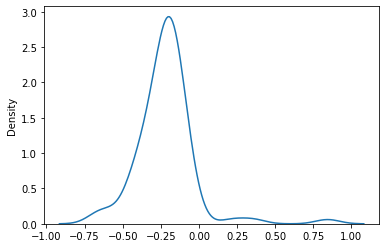

In [ ]:
sns.kdeplot(d_freshet_trend[full_stations])

In [ ]:
cluster_inds = np.squeeze(np.argwhere(labels == 6))
inds = np.intersect1d(full_stations,cluster_inds)
inds

array([ 13,  14,  15, 137, 138, 140, 141, 144])

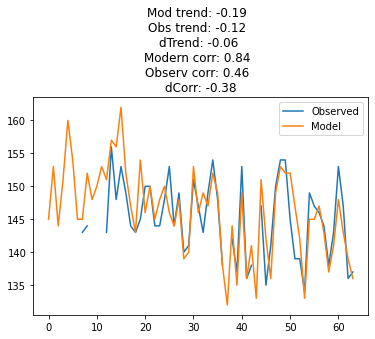

In [ ]:
ind = 138

# plt.plot(t_half_obs[:,full_stations[ind]], label = 'Observed')
# plt.plot(t_half[:,full_stations[ind]], label = 'Model')
# plt.title('Mod trend: ' + str(np.round(freshet_trend_mod[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\nObs trend: ' + str(np.round(freshet_trend_obs[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\ndTrend: ' + str(np.round(d_freshet_trend[full_stations[ind]], decimals = 2)) + ' ' + 
#           '\nModern corr: ' + str(np.round(freshet_corr_modern[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\nObserv corr: ' + str(np.round(freshet_corr_hind[full_stations[ind]], decimals = 2)) + '  ' + 
#           '\ndCorr: ' + str(np.round(d_freshet_corr[full_stations[ind]], decimals = 2)))
# plt.legend()


plt.plot(t_half_obs[:,ind], label = 'Observed')
plt.plot(t_half[:,ind], label = 'Model')
plt.title('Mod trend: ' + str(np.round(freshet_trend_mod[ind], decimals = 2)) + '  ' + 
          '\nObs trend: ' + str(np.round(freshet_trend_obs[ind], decimals = 2)) + '  ' + 
          '\ndTrend: ' + str(np.round(d_freshet_trend[ind], decimals = 2)) + ' ' + 
          '\nModern corr: ' + str(np.round(freshet_corr_modern[ind], decimals = 2)) + '  ' + 
          '\nObserv corr: ' + str(np.round(freshet_corr_hind[ind], decimals = 2)) + '  ' + 
          '\ndCorr: ' + str(np.round(d_freshet_corr[ind], decimals = 2)))
plt.legend()

plt.show()

(1825.0, 5475.0)

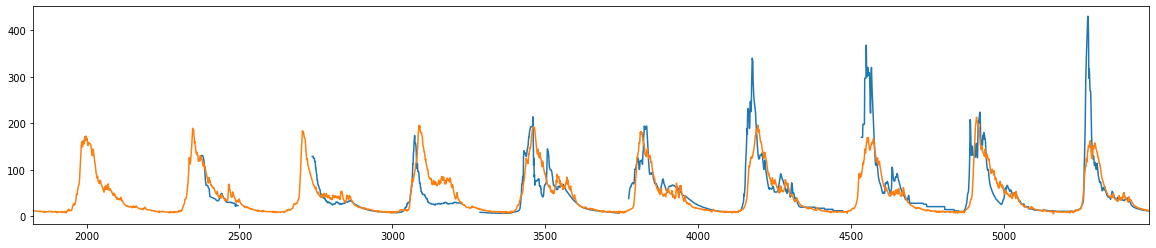

In [ ]:
plt.subplots(figsize=(20,4))
plt.plot(F_long[:,ind])
yy = y_predict[:,ind]*Fstd[ind] + Fmean[ind]
plt.plot(yy)

y1 = 5
y2 = 15
plt.xlim((y1*365,y2*365))

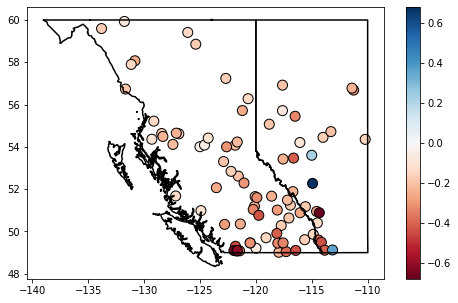

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

cc = freshet_corr_modern
# cc = d_freshet_corr
cc = d_freshet_trend

vmax = np.nanmax(np.sort(np.abs(cc))[:-1])
vmin = -vmax

plot_prov_ax(prov, ax)
plt.scatter(stationLon[stationInds[full_stations]], 
            stationLat[stationInds[full_stations]], 
            c = cc[full_stations], 
            s = 100, cmap = 'RdBu', edgecolor = 'k', vmin = vmin, vmax = vmax)
plt.colorbar()

(0.0, 1.0)

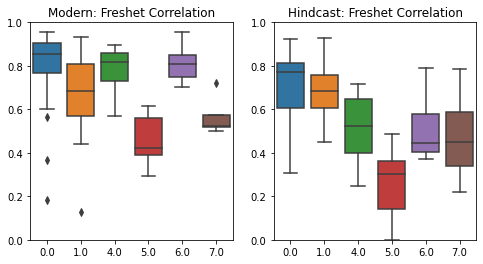

In [ ]:
#freshet correlation by regime

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize  =(8,4))

sns.boxplot(x = labels[full_stations], 
            y = freshet_corr_modern[full_stations],
            ax = axes[0])
axes[0].set_title('Modern: Freshet Correlation')
axes[0].set_ylim((0,1))

sns.boxplot(x = labels[full_stations], 
            y = freshet_corr_hind[full_stations],
            ax = axes[1])
axes[1].set_title('Hindcast: Freshet Correlation')
axes[1].set_ylim((0,1))



No handles with labels found to put in legend.
No handles with labels found to put in legend.


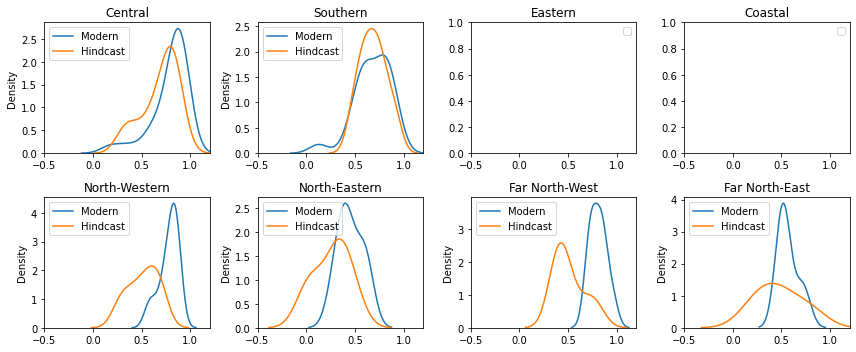

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 5))

for cluster, ax in enumerate(axes.flatten()):
  cluster_inds = np.squeeze(np.argwhere(labels == cluster))
  inds = np.intersect1d(full_stations,cluster_inds)
  sns.kdeplot(freshet_corr_modern[inds], ax = ax, label = 'Modern')
  # ax.hist(freshet_corr_modern[inds])
  sns.kdeplot(freshet_corr_hind[inds], ax = ax, label = 'Hindcast')
  ax.set_xlim((-0.5,1.2))
  ax.set_title(cluster_names[cluster])
  ax.legend()

plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


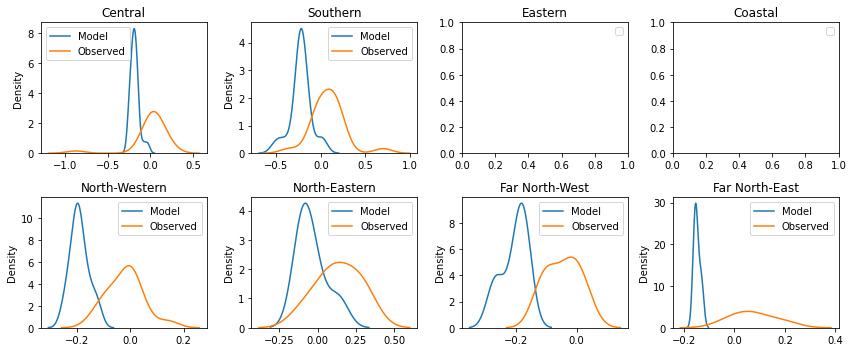

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 5))

for cluster, ax in enumerate(axes.flatten()):
  
  cluster_inds = np.squeeze(np.argwhere(labels == cluster))
  inds = np.intersect1d(full_stations,cluster_inds)
  # inds = np.intersect1d(a,cluster_inds)

  sns.kdeplot(freshet_trend_mod[inds], ax = ax, label = 'Model')
  # ax.hist(freshet_corr_modern[inds])
  sns.kdeplot(freshet_trend_obs[inds], ax = ax, label = 'Observed')
  # ax.set_xlim((-0.5,1.2))
  ax.set_title(cluster_names[cluster])
  ax.legend()

plt.tight_layout()

In [ ]:
d_freshet_trend[inds]

array([ 0.02083333, -0.29710145, -0.0215311 , -0.25362319])

In [ ]:
a = np.intersect1d(full_stations, np.argwhere(np.abs(d_freshet_trend) < 0.1))

# a = np.intersect1d(full_stations, np.argwhere(d_freshet_corr < 0.1))

len(a)

11

In [ ]:
# #linear regression

# freshet_trend_obs = np.zeros(len(stationInds))

# for station in range(len(stationInds)):
#   yy = t_half_obs[:,station].reshape(-1,1)
#   yy = yy[np.squeeze(np.argwhere(-1*np.isnan(yy)))].reshape(-1,1)
#   xx = np.arange(len(yy)).reshape(-1,1)
#   lm = LinearRegression().fit(X = xx, y = yy)
#   freshet_trend_mod[station] = lm.coef_

In [ ]:
#linear regression

# freshet_trend_obs = np.zeros(len(stationInds))

for station in np.array([157]):#range(len(stationInds)):
  yy = t_half_obs[:,station].reshape(-1,1)
  # yy = yy[np.squeeze(np.argwhere(-1*np.isnan(yy)))].reshape(-1,1)
  xx = np.arange(len(yy)).reshape(-1,1)
  lm = LinearRegression().fit(X = xx, y = yy)
  print(lm.coef_)

ValueError: ignored

In [ ]:
cluster_freshet_mod = np.zeros((n_clusters_seasonal,64))
cluster_freshet_obs = np.zeros((n_clusters_seasonal,64))

cluster_freshet_trend_obs = np.zeros(n_clusters_seasonal)
cluster_freshet_trend_mod = np.zeros(n_clusters_seasonal)

for kk in range(n_clusters_seasonal):
  
  cluster_inds = np.squeeze(np.argwhere(labels == kk))
  inds = np.intersect1d(cluster_inds, full_stations)

  if len(inds) > 0:

    cluster_freshet_mod[kk,:] = np.mean(t_half[:,inds], axis = -1)
    cluster_freshet_obs[kk,:] = np.nanmean(t_half_obs[:,inds], axis = -1)

    MK = mk.original_test(cluster_freshet_mod[kk,:])
    cluster_freshet_trend_mod[kk] = MK.slope
    # cluster_freshet_p_mod[kk] = MK.p

    MK = mk.original_test(cluster_freshet_obs[kk,:])
    cluster_freshet_trend_obs[kk] = MK.slope
    # cluster_freshet_p_obs[kk] = MK.p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [ ]:
from scipy import stats

slope_obs = np.zeros(len(full_stations))
slope_mod = np.zeros(len(full_stations))

for ind in range(len(full_stations)):

  varx = np.delete(np.arange(1951, 2016), 28, 0)
  vary = t_half_obs[:,full_stations[ind]]
  mask = ~np.isnan(varx) & ~np.isnan(vary)
  # if len(mask) < len(varx):
  slope_obs[ind], intercept, r_value, p_value, std_err = stats.linregress(varx[mask], vary[mask])

  varx = np.delete(np.arange(1951, 2016), 28, 0)
  vary = t_half[:,full_stations[ind]]
  mask = ~np.isnan(varx) & ~np.isnan(vary)
  # if len(mask) < len(varx):
  slope_mod[ind], intercept, r_value, p_value, std_err = stats.linregress(varx[mask], vary[mask])

# print(slope_obs)
# print(slope_mod)
# print(freshet_trend_obs[full_stations[ind]])
# print(freshet_trend_mod[full_stations[ind]])

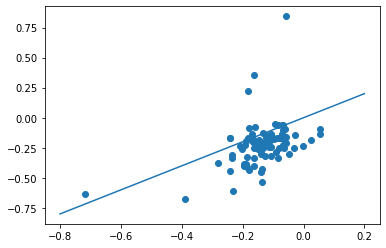

In [ ]:
d1 = slope_mod - slope_obs

plt.scatter(d1, d_freshet_trend[full_stations])
plt.plot([-0.8,0.2],[-0.8,0.2])

In [ ]:
cluster_freshet_trend_mod, cluster_freshet_trend_obs

(array([-0.15452308, -0.22670718,  0.        ,  0.        , -0.17647059,
        -0.07120811, -0.18572797, -0.16666667]),
 array([-0.06679771, -0.05277383,  0.        ,  0.        , -0.16622103,
         0.02272727, -0.11678247, -0.03661152]))

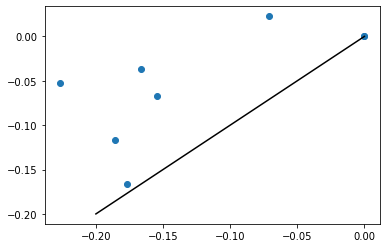

In [ ]:
plt.scatter(cluster_freshet_trend_mod, cluster_freshet_trend_obs)
plt.plot([-0.2,0], [-0.2,0], 'k')

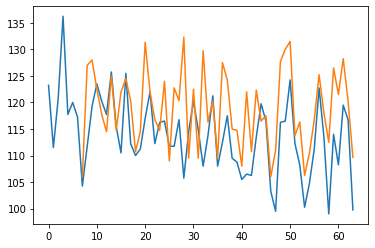

In [ ]:
cluster = 7

plt.plot(cluster_freshet_mod[cluster,:])
plt.plot(cluster_freshet_obs[cluster,:])

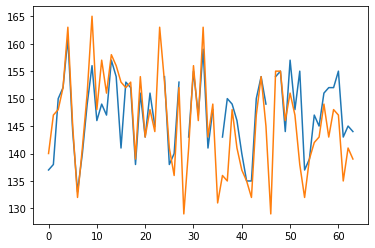

In [ ]:
tt = t_half_obs[:,157]
# tts = pd.Series(tt).rolling(window = 10).mean()
plt.plot(tt)
# plt.plot(tts)
plt.plot(t_half[:,157])

In [ ]:
freshet_trend_obs[157], freshet_trend_mod[157]

(0.0, -0.17647058823529413)

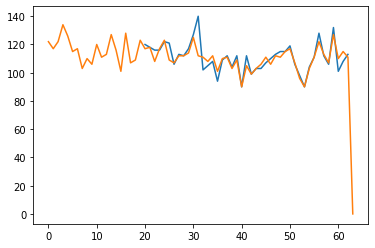

In [ ]:
ind = 20

tt = t_half_obs[:,full_stations[ind]]
# tts = pd.Series(tt).rolling(window = 10).mean()
plt.plot(tt)
# plt.plot(tts)
plt.plot(t_half[:,full_stations[ind]])

(array([ 1.,  0.,  0.,  1.,  9., 42., 26.,  4.,  0.,  1.]),
 array([-0.875     , -0.71769943, -0.56039886, -0.40309829, -0.24579772,
        -0.08849715,  0.06880342,  0.22610399,  0.38340456,  0.54070513,
         0.6980057 ]),
 <a list of 10 Patch objects>)

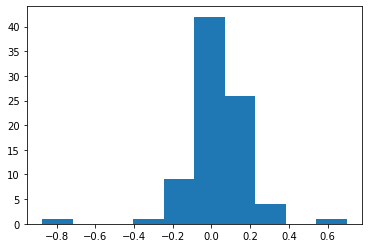

In [ ]:
plt.hist(freshet_trend_obs[full_stations])

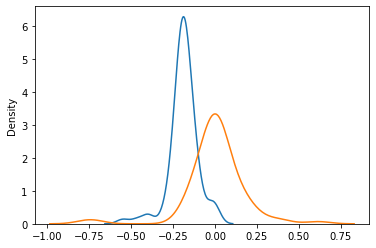

In [ ]:
sns.kdeplot(freshet_trend_mod[full_stations])
sns.kdeplot(freshet_trend_obs[full_stations])

In [ ]:
sig_obs = np.squeeze(np.argwhere(freshet_p_obs < 0.05))
sig_mod = np.squeeze(np.argwhere(freshet_p_mod < 0.05))

In [ ]:
inds = np.intersect1d(full_stations, sig_obs)

Text(0, 0.5, 'Modelled')

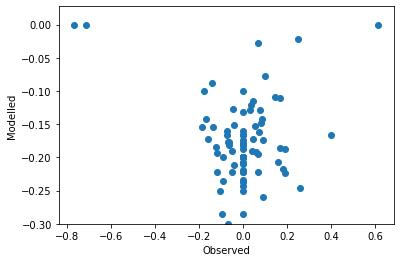

In [ ]:
# plt.scatter(freshet_trend_obs[full_stations], freshet_trend_mod[full_stations])
plt.scatter(freshet_trend_obs[full_stations], freshet_trend_mod[full_stations])
# plt.plot([-0.3,0.3], [-0.3,0.3], 'k')
plt.ylim(bottom = -0.3)
plt.xlabel('Observed')
plt.ylabel('Modelled')

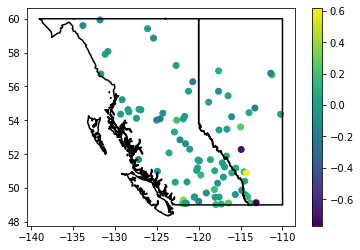

In [ ]:
# vmin = -0.5#np.sort(freshet_trend_mod)[1]
# vmax = -0.


fig, ax = plt.subplots()

plot_prov_ax(prov = prov, ax = ax)
plt.scatter(stationLon[stationInds][full_stations], stationLat[stationInds][full_stations], c = freshet_trend_obs[full_stations])#, vmin = vmin, vmax = vmax)
plt.colorbar()

# Compare decadal-scale changes to seasonal: Model

In [ ]:
# full_stations = np.intersect1d(full_stations, np.argwhere(NSE_hind > 0.7))
# full_stations = np.arange(0,len(stationInds))

In [ ]:
#calculate seasonal flow (365-day long flows of each year, starting on Jan 1)

y_all_predict = np.vstack([y_hind_predict, y_modern_predict])
date_all = np.vstack([np.reshape(eraDate_hind, (-1,1)), np.reshape(eraDate_modern, (-1,1))])

delta = timedelta(days = 364)
year_start = 1951
year_fin = 2015

f_seasonal = np.zeros((365, len(stationInds)))
f_seasonal_yearly = np.zeros((365, len(stationInds), len(range(year_start, year_fin))))

kk = 0
for nn, year in enumerate(range(year_start, year_fin+1)):
  
  if year != 1979:

    start_date = datetime(year, 1, 1)
    fin_date = start_date + delta

    start_ind = np.argwhere(date_all==start_date)[0][0]
    fin_ind = np.argwhere(date_all==fin_date)[0][0]

    f = y_all_predict[start_ind:fin_ind+1,:]

    if year==year_fin: #last year missing final day -- fill in with second last day
      f_new = np.zeros((365,265))
      f_new[:-1,:] = f
      f_new[-1,:] = f_new[-2,:]
      f = f_new

    f_seasonal += f
    f_seasonal_yearly[:,:,kk] = f

    kk+=1

f_seasonal /= nn

#calculate early period vs modern period seasonal flow of each cluster
seasonal_early = np.mean(f_seasonal_yearly[:,:,:35], axis = -1)
seasonal_modern = np.mean(f_seasonal_yearly[:,:,-35:], axis = -1)

seasonal_early_clusters = np.zeros((365,n_clusters_seasonal))
seasonal_modern_clusters = np.zeros((365,n_clusters_seasonal))

for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(labels==cluster))
  inds = np.intersect1d(full_stations, inds)
  seasonal_early_clusters[:,cluster] = np.mean(seasonal_early[:,inds], axis = -1)
  seasonal_modern_clusters[:,cluster] = np.mean(seasonal_modern[:,inds], axis = -1)

ValueError: ignored

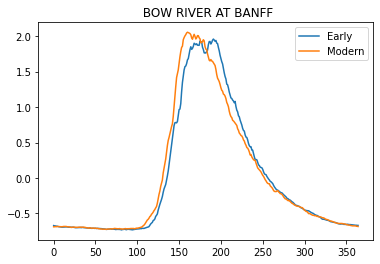

In [ ]:
ind = 157
x1 = np.mean(f_seasonal_yearly[:,:,:30], axis = -1)
x2 = np.mean(f_seasonal_yearly[:,:,-30:], axis = -1)
plt.plot(x1[:,ind], label = 'Early')
plt.plot(x2[:,ind], label = 'Modern')
plt.title(stationNames[stationInds][ind])
plt.legend()

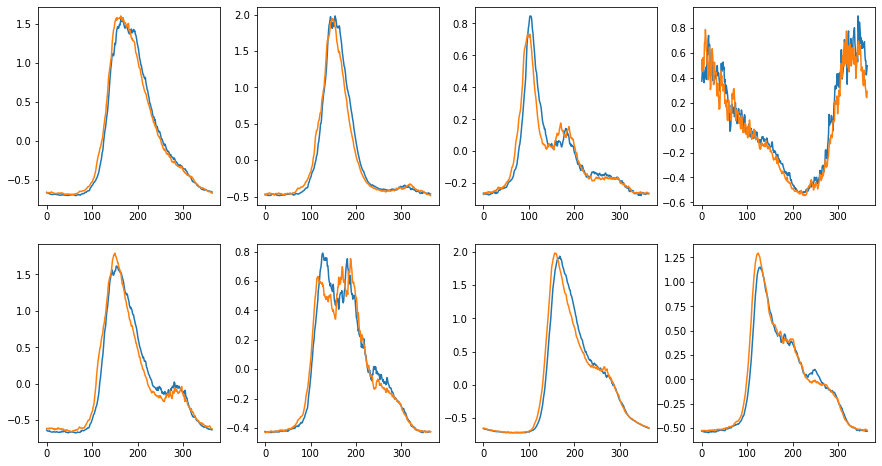

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15,8))

for cluster, ax in enumerate(axes.flatten()):
  ax.plot(seasonal_early_clusters[:,cluster])
  ax.plot(seasonal_modern_clusters[:,cluster])

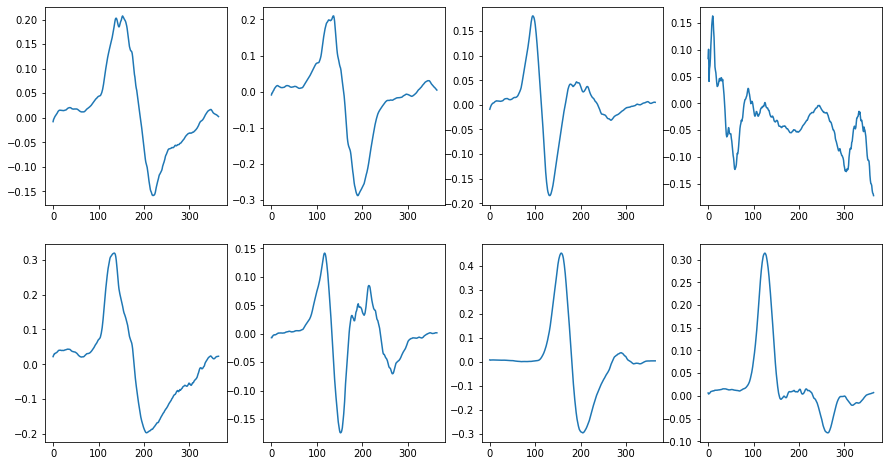

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15,8))

for cluster, ax in enumerate(axes.flatten()):
  xx = seasonal_modern_clusters[:,cluster] - seasonal_early_clusters[:,cluster]
  ax.plot(pd.Series(xx).rolling(window = 30, min_periods = 1).mean())
  # ax.plot(seasonal_modern_clusters[:,cluster])

In [ ]:
N_years_window = 20
start_year0 = 1951
start_year = np.copy(start_year0)
fin_year = start_year + N_years_window

seasonal_window = np.zeros((365, len(stationInds), 64 - N_years_window + 1 - (start_year0 - 1951)))

start_ind = 0
kk = 0
while fin_year <= 2015:
  seasonal_window[:,:,kk] = np.mean(f_seasonal_yearly[:,:,start_ind:start_ind+N_years_window], axis = -1)
  kk+=1
  start_ind += 1
  start_year += 1
  fin_year = start_year + N_years_window


In [ ]:
seasonal_window_clusters = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))

for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(labels==cluster))
  inds = np.intersect1d(full_stations, inds)
  seasonal_window_clusters[:,cluster,:] = np.mean(seasonal_window[:,inds,:], axis = 1)

In [ ]:
# fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15,8))

# colors = cm.get_cmap('viridis', 64 - N_years_window + 1 - (start_year0 - 1951))

# for cluster, ax in enumerate(axes.flatten()):
#   for kk in range(64 - N_years_window + 1 - (start_year0 - 1951)):
#     xx = seasonal_window_clusters[:,cluster,kk] - seasonal_window_clusters[:,cluster,0]
#     ax.plot(pd.Series(xx).rolling(window = 30, min_periods = 1).mean(), color = colors(kk))

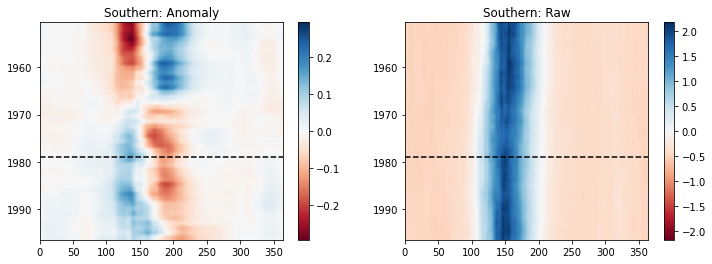

In [ ]:
cluster = 1

Nhind_years = len(np.arange(1951,1979))
extent = [0,364,2016.5 - N_years_window, 1950.5]

xx_seas =np.expand_dims(np.mean(seasonal_window_clusters[:,cluster,:], axis = -1), axis = -1)
xx = seasonal_window_clusters[:,cluster,:] - xx_seas
xx = xx.T
for year in range(len(xx)):
  xx[year,:] = pd.Series(xx[year,:]).rolling(window = 30, min_periods = 1).mean()


plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

plt.subplot(121)
vmax = np.max(np.abs(xx))
vmin = - vmax 
plt.imshow(xx, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax, extent = extent)
plt.plot(range(365), 1979*np.ones(365), 'k--')
plt.colorbar()
plt.title(cluster_names[cluster] + ': Anomaly')

plt.subplot(122)
xx_raw = seasonal_window_clusters[:,cluster,:].T
vmax = np.max(np.abs(xx_raw))
vmin = - vmax 
plt.imshow(xx_raw, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
plt.plot(range(365), 1979*np.ones(365), 'k--')
plt.colorbar()
plt.title(cluster_names[cluster] + ': Raw')

plt.show()

#Compare decadal-scale changes to seasonal: Observation

In [ ]:
F_long_norm = np.zeros(np.shape(F_long))
for station in range(len(stationInds)):
  F_long_norm[:,station] = (F_long[:,station] - Fmean[station]) / Fstd[station]

In [ ]:
#OBSERVATION: calculate seasonal flow (365-day long flows of each year, starting on Jan 1)

date_all = np.asarray(flowDate_long)
delta = timedelta(days = 364)
year_start = 1951
year_fin = 2015

f_seasonal_obs = np.zeros((365, len(stationInds)))
f_seasonal_yearly_obs = np.zeros((365, len(stationInds), len(range(year_start, year_fin))))
missing_data = np.zeros((365, len(stationInds), len(range(year_start, year_fin))))

kk = 0
for nn, year in enumerate(range(year_start, year_fin+1)):
  
  if year != 1979:

    start_date = datetime(year, 1, 1)
    fin_date = start_date + delta

    start_ind = np.argwhere(date_all==start_date)[0][0]
    fin_ind = np.argwhere(date_all==fin_date)[0][0]

    f = F_long_norm[start_ind:fin_ind+1,:]

    # if year==year_fin: #last year missing final day -- fill in with second last day
    #   f_new = np.zeros((365,265))
    #   f_new[:-1,:] = f
    #   f_new[-1,:] = f_new[-2,:]
    #   f = f_new

    # f_seasonal += f
    f_seasonal_yearly_obs[:,:,kk] = f

    for missing_index in np.argwhere(np.isnan(f)):
      missing_data[missing_index[0], missing_index[1], kk] = 1

    kk+=1

# f_seasonal_obs /= nn


seasonal_early_obs = np.nanmean(f_seasonal_yearly_obs[:,:,:35], axis = -1)
seasonal_modern_obs = np.nanmean(f_seasonal_yearly_obs[:,:,-35:], axis = -1)

seasonal_early_obs_clusters = np.zeros((365,n_clusters_seasonal))
seasonal_modern_obs_clusters = np.zeros((365,n_clusters_seasonal))

for cluster in range(n_clusters_seasonal):
  inds = np.squeeze(np.argwhere(labels==cluster))
  inds = np.intersect1d(full_stations, inds)
  seasonal_early_obs_clusters[:,cluster] = np.nanmean(seasonal_early_obs[:,inds], axis = -1)
  seasonal_modern_obs_clusters[:,cluster] = np.nanmean(seasonal_modern_obs[:,inds], axis = -1)

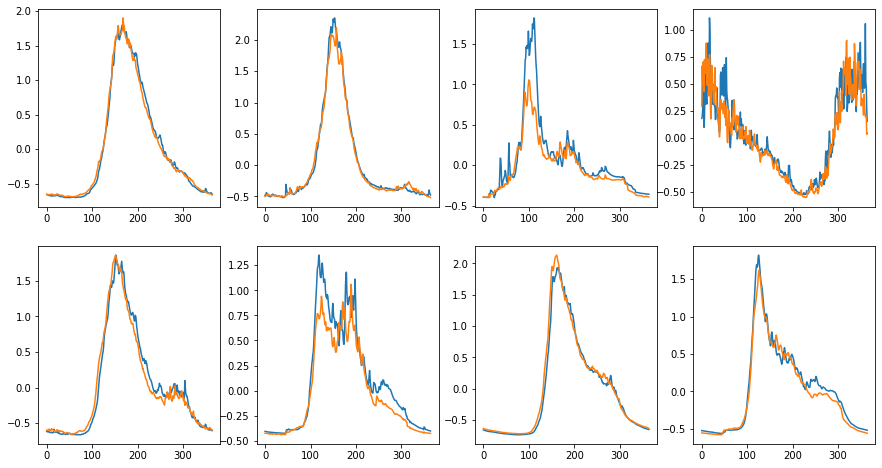

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15,8))

for cluster, ax in enumerate(axes.flatten()):
  ax.plot(seasonal_early_obs_clusters[:,cluster])
  ax.plot(seasonal_modern_obs_clusters[:,cluster])

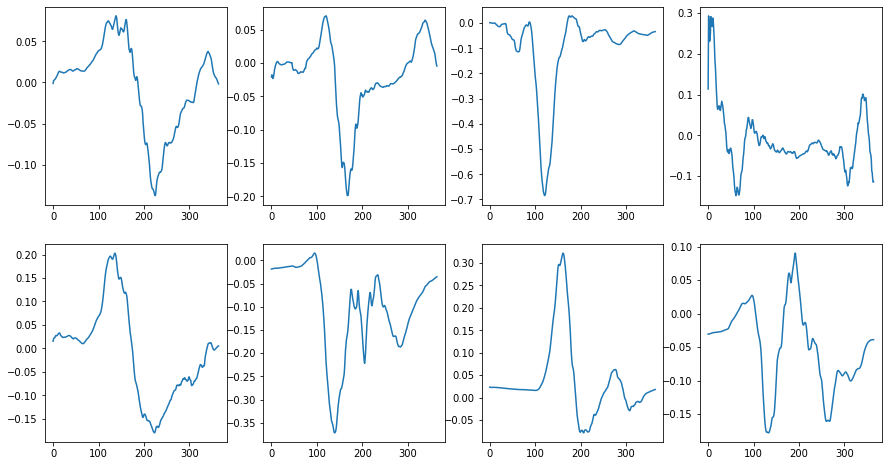

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15,8))

for cluster, ax in enumerate(axes.flatten()):
  xx = seasonal_modern_obs_clusters[:,cluster] - seasonal_early_obs_clusters[:,cluster]
  ax.plot(pd.Series(xx).rolling(window = 30, min_periods = 1).mean())
  # ax.plot(seasonal_modern_clusters[:,cluster])

In [ ]:
N_years_window = 20
start_year0 = 1951
start_year = np.copy(start_year0)
fin_year = start_year + N_years_window

seasonal_window_obs = np.zeros((365, len(stationInds), 64 - N_years_window + 1 - (start_year0 - 1951)))
missing_window = np.zeros((365, len(stationInds), 64 - N_years_window + 1 - (start_year0 - 1951)))

start_ind = 0
kk = 0
while fin_year <= 2015:
  seasonal_window_obs[:,:,kk] = np.nanmean(f_seasonal_yearly_obs[:,:,start_ind:start_ind+N_years_window], axis = -1)
  missing_window[:,:,kk] = np.sum(missing_data[:,:,start_ind:start_ind+N_years_window], axis = -1)
  kk+=1
  start_ind += 1
  start_year += 1
  fin_year = start_year + N_years_window


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


In [ ]:
seasonal_window_anomaly = np.zeros(np.shape(seasonal_window))
seasonal_window_anomaly_obs = np.zeros(np.shape(seasonal_window_obs))

seasonal_window_anomaly_norm = np.zeros(np.shape(seasonal_window))
seasonal_window_anomaly_norm_obs = np.zeros(np.shape(seasonal_window_obs))

for station in range(len(stationInds)):
  
  seasonal = np.expand_dims(np.nanmean(seasonal_window[:,station,:], axis = -1), axis = -1)
  seasonal_window_anomaly[:,station,:] = seasonal_window[:,station,:] - seasonal

  seasonal_obs = np.expand_dims(np.nanmean(seasonal_window_obs[:,station,:], axis = -1), axis = -1)
  seasonal_window_anomaly_obs[:,station,:] = seasonal_window_obs[:,station,:] - seasonal_obs

  for year in range(len(seasonal_window_obs[0,0,:])):

    seasonal_window_anomaly[:,station,year] = pd.Series(seasonal_window_anomaly[:,station,year]).rolling(window = 30, min_periods = 1).mean()
    seasonal_window_anomaly_obs[:,station,year] = pd.Series(seasonal_window_anomaly_obs[:,station,year]).rolling(window = 30, min_periods = 1).mean()

    seasonal_window[:,station,year] = pd.Series(seasonal_window[:,station,year]).rolling(window = 30, min_periods = 1).mean()
    seasonal_window_obs[:,station,year] = pd.Series(seasonal_window_obs[:,station,year]).rolling(window = 30, min_periods = 1).mean()

  std = np.expand_dims(np.std(seasonal_window[:,station,:], axis = -1), axis = -1)
  seasonal_window_anomaly_norm[:,station,:] = seasonal_window_anomaly[:,station,:] / std

  std = np.expand_dims(np.nanstd(seasonal_window_obs[:,station,:], axis = -1), axis = -1)
  seasonal_window_anomaly_norm_obs[:,station,:] = seasonal_window_anomaly_obs[:,station,:] / std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
seasonal_window_obs_clusters = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))
missing_window_clusters = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))
missing_window_clusters_norm = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))

seasonal_window_anomaly_obs_clusters = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))
seasonal_window_anomaly_clusters = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))

seasonal_window_anomaly_norm_obs_clusters = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))
seasonal_window_anomaly_norm_clusters = np.zeros((365,n_clusters_seasonal,64 - N_years_window + 1 - (start_year0 - 1951)))

for cluster in range(n_clusters_seasonal):

  inds = np.squeeze(np.argwhere(labels==cluster))
  inds = np.intersect1d(full_stations, inds)

  seasonal_window_obs_clusters[:,cluster,:] = np.nanmean(seasonal_window_obs[:,inds,:], axis = 1)
  seasonal_window_anomaly_obs_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly_obs[:,inds,:], axis = 1)
  seasonal_window_anomaly_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly[:,inds,:], axis = 1)
  seasonal_window_anomaly_norm_obs_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly_norm_obs[:,inds,:], axis = 1)
  seasonal_window_anomaly_norm_clusters[:,cluster,:] = np.nanmean(seasonal_window_anomaly_norm[:,inds,:], axis = 1)

  missing_window_clusters[:,cluster,:] = np.sum(missing_window[:,inds,:], axis = 1)
  missing_window_clusters_norm[:,cluster,:] = np.copy(missing_window_clusters[:,cluster,:]) / (len(inds) * N_years_window)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
# fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (15,8))

# colors = cm.get_cmap('viridis', 64 - N_years_window + 1 - (start_year0 - 1951))

# for cluster, ax in enumerate(axes.flatten()):
#   for kk in range(64 - N_years_window + 1 - (start_year0 - 1951)):
#     xx = seasonal_window_obs_clusters[:,cluster,kk] - seasonal_window_obs_clusters[:,cluster,0]
#     ax.plot(pd.Series(xx).rolling(window = 30, min_periods = 1).mean(), color = colors(kk))

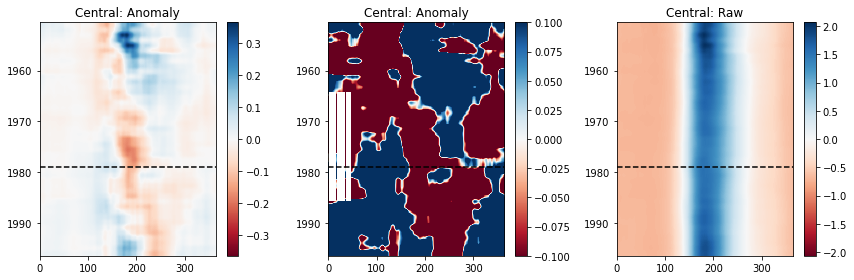

In [ ]:
cluster = 0

# xx_seas =np.expand_dims(np.mean(seasonal_window_obs_clusters[:,cluster,:], axis = -1), axis = -1)
# xx = seasonal_window_obs_clusters[:,cluster,:] - xx_seas
# xx = xx.T
# for year in range(len(xx)):
#   xx[year,:] = pd.Series(xx[year,:]).rolling(window = 30, min_periods = 1).mean()


plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

plt.subplot(131)
xx = seasonal_window_anomaly_obs_clusters[:,cluster,:].T
vmax = np.nanmax(np.abs(xx))
vmin = - vmax 
plt.imshow(xx, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
plt.plot(range(365), 1979*np.ones(365), 'k--')
plt.colorbar()
plt.title(cluster_names[cluster] + ': Anomaly')

plt.subplot(132)
xx = seasonal_window_anomaly_norm_obs_clusters[:,cluster,:].T
vmax = np.nanmax(np.abs(xx))
vmin = - vmax 
plt.imshow(xx, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
plt.plot(range(365), 1979*np.ones(365), 'k--')
plt.colorbar()
plt.title(cluster_names[cluster] + ': Anomaly')

plt.subplot(133)
xx_raw = seasonal_window_obs_clusters[:,cluster,:].T
vmax = np.nanmax(np.abs(xx_raw))
vmin = - vmax 
plt.imshow(xx_raw, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
plt.plot(range(365), 1979*np.ones(365), 'k--')
plt.colorbar()
plt.title(cluster_names[cluster] + ': Raw')

plt.tight_layout()

plt.show()

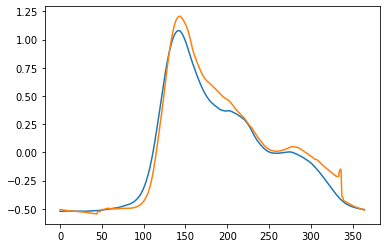

In [ ]:
cluster = 7
plt.plot(seasonal_window_clusters[:,cluster,-1])
plt.plot(seasonal_window_obs_clusters[:,cluster,-1])

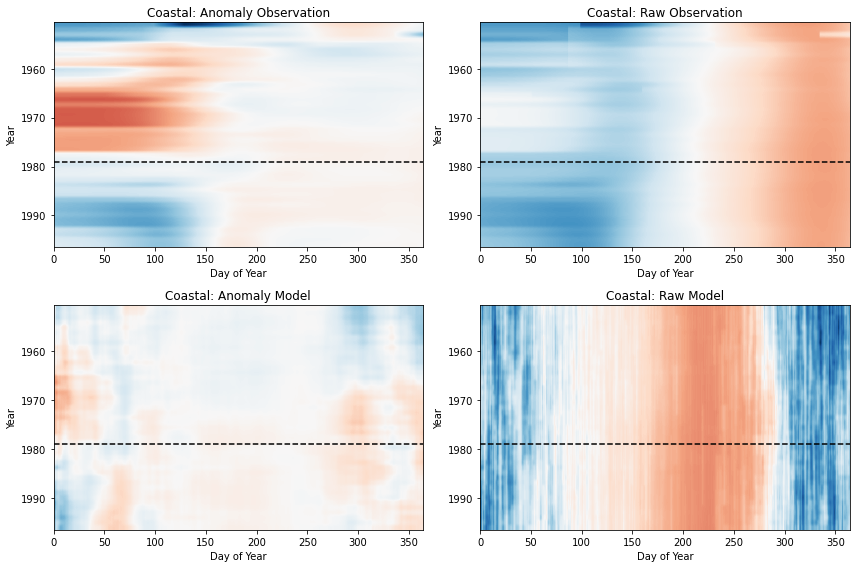

In [ ]:
saveIt = 0

cluster = 3

xx_seas_obs =np.expand_dims(np.nanmean(seasonal_window_obs_clusters[:,cluster,:], axis = -1), axis = -1)
xx_obs = seasonal_window_obs_clusters[:,cluster,:] - xx_seas_obs
xx_obs = xx_obs.T
for year in range(len(xx_obs)):
  xx_obs[year,:] = pd.Series(xx_obs[year,:]).rolling(window = 30, min_periods = 1).mean()
xx_raw_obs = seasonal_window_obs_clusters[:,cluster,:].T

xx_seas =np.expand_dims(np.nanmean(seasonal_window_clusters[:,cluster,:], axis = -1), axis = -1)
xx = seasonal_window_clusters[:,cluster,:] - xx_seas
xx = xx.T
for year in range(len(xx)):
  xx[year,:] = pd.Series(xx[year,:]).rolling(window = 30, min_periods = 1).mean()
xx_raw = seasonal_window_clusters[:,cluster,:].T


fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
im = axes[0][0].imshow(xx_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][0].plot(range(365), 1979*np.ones(365), 'k--')
# cb = plt.colorbar(im)
axes[0][0].set_title(cluster_names[cluster] + ': Anomaly Observation')
axes[0][0].set_xlabel('Day of Year')
axes[0][0].set_ylabel('Year')

vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[0][1].imshow(xx_raw_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][1].plot(range(365), 1979*np.ones(365), 'k--')
# plt.colorbar()
axes[0][1].set_title(cluster_names[cluster] + ': Raw Observation')
axes[0][1].set_xlabel('Day of Year')
axes[0][1].set_ylabel('Year')

vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
im = axes[1][0].imshow(xx, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[1][0].plot(range(365), 1979*np.ones(365), 'k--')
# plt.colorbar()
axes[1][0].set_title(cluster_names[cluster] + ': Anomaly Model')
axes[1][0].set_xlabel('Day of Year')
axes[1][0].set_ylabel('Year')

vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[1][1].imshow(xx_raw, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[1][1].plot(range(365), 1979*np.ones(365), 'k--')
# plt.colorbar()
axes[1][1].set_title(cluster_names[cluster] + ': Raw Model')
axes[1][1].set_xlabel('Day of Year')
axes[1][1].set_ylabel('Year')

# #plot missing data contours
# levels = np.arange(0.1,1.1,0.2)
# contour = axes[0,0].contour(missing_window_clusters_norm[:,cluster,:].T, levels = levels, colors = 'k', extent = extent)
# ax.clabel(contour, inline = True, fontsize = 10)
# contour = axes[0,1].contour(missing_window_clusters_norm[:,cluster,:].T, levels = levels, colors = 'k', extent = extent)
# ax.clabel(contour, inline = True, fontsize = 10)

plt.tight_layout()

if saveIt:
  plt.savefig('mod_obs_anomaly_clusters.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [ ]:
np.argwhere(labels==3)

array([[ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 83],
       [ 86],
       [136]])

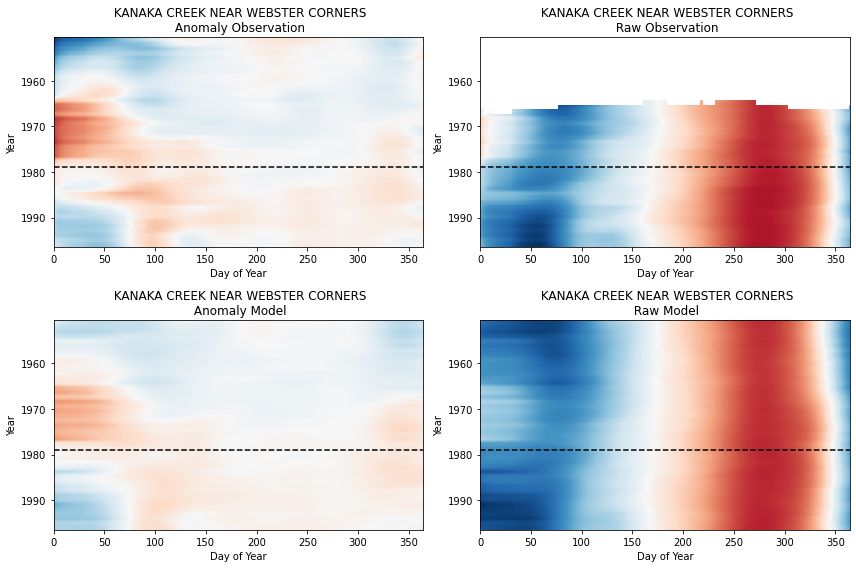

In [ ]:
saveIt = 0

station = 86

# xx_seas_obs =np.expand_dims(np.nanmean(seasonal_window_obs[:,cluster,:], axis = -1), axis = -1)
# xx_obs = seasonal_window_obs[:,cluster,:] - xx_seas_obs
# xx_obs = xx_obs.T
# for year in range(len(xx_obs)):
#   xx_obs[year,:] = pd.Series(xx_obs[year,:]).rolling(window = 30, min_periods = 1).mean()
xx_raw_obs = seasonal_window_obs[:,station,:].T

# xx_seas = np.expand_dims(np.mean(seasonal_window[:,cluster,:], axis = -1), axis = -1)
# xx = seasonal_window[:,cluster,:] - xx_seas
# xx = xx.T
# for year in range(len(xx)):
#   xx[year,:] = pd.Series(xx[year,:]).rolling(window = 30, min_periods = 1).mean()
xx_raw = seasonal_window[:,station,:].T

#mask
xx_obs[missing_window_clusters_norm[:,cluster,:].T > 0.2] = np.nan
xx_raw_obs[missing_window_clusters_norm[:,cluster,:].T > 0.2] = np.nan
# xx[missing_window_clusters_norm[:,cluster,:].T > 0.5] = np.nan
# xx_raw[missing_window_clusters_norm[:,cluster,:].T > 0.5] = np.nan

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

#observation: anomaly
vmax = np.nanmax([np.abs(seasonal_window_anomaly[:,station,:]), np.abs(seasonal_window_anomaly_obs[:,station,:])])
vmin = - vmax 
im = axes[0][0].imshow(seasonal_window_anomaly_obs[:,station,:].T, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][0].plot(range(365), 1979*np.ones(365), 'k--')
axes[0][0].set_title(stationNames[stationInds][station] + '\n Anomaly Observation')
axes[0][0].set_xlabel('Day of Year')
axes[0][0].set_ylabel('Year')

#observation: raw flow
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[0][1].imshow(xx_raw_obs, aspect = 'auto', cmap = 'RdBu', extent = extent, vmin = vmin, vmax = vmax)
axes[0][1].plot(range(365), 1979*np.ones(365), 'k--')
axes[0][1].set_title(stationNames[stationInds][station] + '\n Raw Observation')
axes[0][1].set_xlabel('Day of Year')
axes[0][1].set_ylabel('Year')

#model: anomaly
vmax = np.nanmax([np.abs(seasonal_window_anomaly[:,station,:]), np.abs(seasonal_window_anomaly_obs[:,station,:])])
vmin = - vmax 
im = axes[1][0].imshow(seasonal_window_anomaly[:,station,:].T, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax, extent = extent)
axes[1][0].plot(range(365), 1979*np.ones(365), 'k--')
axes[1][0].set_title(stationNames[stationInds][station] + '\n Anomaly Model')
axes[1][0].set_xlabel('Day of Year')
axes[1][0].set_ylabel('Year')

#model: raw flow
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
im = axes[1][1].imshow(xx_raw, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax, extent = extent)
axes[1][1].plot(range(365), 1979*np.ones(365), 'k--')
axes[1][1].set_title(stationNames[stationInds][station] + '\n Raw Model')
axes[1][1].set_xlabel('Day of Year')
axes[1][1].set_ylabel('Year')

plt.tight_layout()

if saveIt:
  plt.savefig('mod_obs_anomaly_stations.png', bbox_inches = 'tight', dpi = 300)

plt.show()

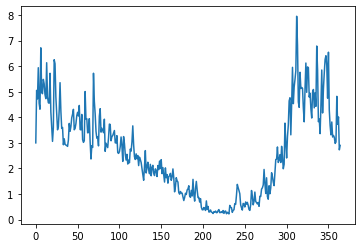

In [ ]:
plt.plot(flowseason[86,:])

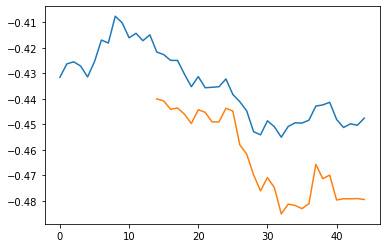

In [ ]:
# plt.plot(seasonal_window_anomaly[140,station,:])
# plt.plot(seasonal_window_anomaly_obs[140,station,:])

plt.plot(seasonal_window[290,station,:])
plt.plot(seasonal_window_obs[290,station,:])

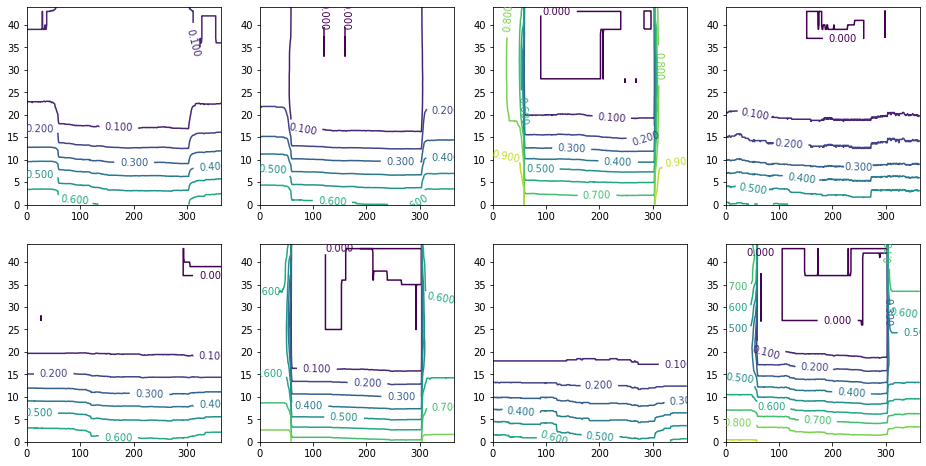

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (16,8))
levels = np.arange(0,1.1,0.1)
for kk, ax in enumerate(axes.flatten()):
  contour = ax.contour(missing_window_clusters_norm[:,kk,:].T, levels = levels)
  ax.clabel(contour, inline = True, fontsize = 10)
  # if kk < 2:
  #   cb = plt.colorbar(contour, ax = ax)

In [ ]:
np.shape(seasonal_window_obs_clusters)

(365, 8, 45)

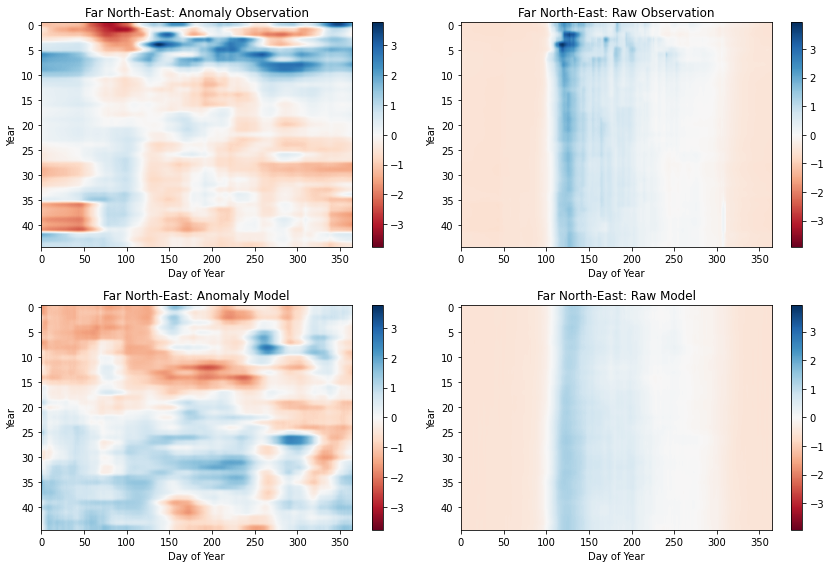

In [ ]:
saveIt = 0

cluster = 7

#observed
xx_seas_obs =np.expand_dims(np.nanmean(seasonal_window_obs_clusters[:,cluster,:], axis = -1), axis = -1)
xx_obs = seasonal_window_obs_clusters[:,cluster,:] - xx_seas_obs
xx_obs = xx_obs.T
xx_obs /= np.nanstd(xx_obs, axis = 0)
for year in range(len(xx_obs)):
  xx_obs[year,:] = pd.Series(xx_obs[year,:]).rolling(window = 30, min_periods = 1).mean()
xx_raw_obs = seasonal_window_obs_clusters[:,cluster,:].T

#modelled
xx_seas =np.expand_dims(np.nanmean(seasonal_window_clusters[:,cluster,:], axis = -1), axis = -1)
xx = seasonal_window_clusters[:,cluster,:] - xx_seas
xx = xx.T
xx /= np.nanstd(xx, axis = 0)
for year in range(len(xx)):
  xx[year,:] = pd.Series(xx[year,:]).rolling(window = 30, min_periods = 1).mean()
xx_raw = seasonal_window_clusters[:,cluster,:].T

# #mask
# xx_obs[missing_window_clusters_norm[:,cluster,:].T > 0.2] = np.nan
# xx_raw_obs[missing_window_clusters_norm[:,cluster,:].T > 0.2] = np.nan
# # xx[missing_window_clusters_norm[:,cluster,:].T > 0.5] = np.nan
# # xx_raw[missing_window_clusters_norm[:,cluster,:].T > 0.5] = np.nan

#visualize
plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

plt.subplot(221)
vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
plt.imshow(xx_obs, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title(cluster_names[cluster] + ': Anomaly Observation')
plt.xlabel('Day of Year')
plt.ylabel('Year')

plt.subplot(222)
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
plt.imshow(xx_raw_obs, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title(cluster_names[cluster] + ': Raw Observation')
plt.xlabel('Day of Year')
plt.ylabel('Year')


plt.subplot(223)

vmax = np.nanmax([np.abs(xx), np.abs(xx_obs)])
vmin = - vmax 
plt.imshow(xx, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title(cluster_names[cluster] + ': Anomaly Model')
plt.xlabel('Day of Year')
plt.ylabel('Year')

plt.subplot(224)
vmax = np.nanmax([np.abs(xx_raw), np.abs(xx_raw_obs)])
vmin = - vmax 
plt.imshow(xx_raw, aspect = 'auto', cmap = 'RdBu', vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title(cluster_names[cluster] + ': Raw Model')
plt.xlabel('Day of Year')
plt.ylabel('Year')

# levels = np.arange(0.1,1.1,0.1)
# contour = axes[0,0].contour(missing_window_clusters_norm[:,cluster,:].T, levels = levels, colors = 'k')
# ax.clabel(contour, inline = True, fontsize = 10)
# contour = axes[0,1].contour(missing_window_clusters_norm[:,cluster,:].T, levels = levels, colors = 'k')
# ax.clabel(contour, inline = True, fontsize = 10)


plt.tight_layout()

if saveIt:
  plt.savefig('mod_obs_anomaly.png', bbox_inches = 'tight', dpi = 300)

plt.show()